# target推定 評価可視化

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

from keras_model import *
from target_train import TargetTrain
import keras

def load_image(paths,gray_flag=0):
    #pathを受け取って画像を返す
    img_feature = []
    for path in paths:
        x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if x is None:
            x = np.array([0]*32*96)
        x = x.reshape(32,96,1)
        img_feature.append(x / 255.0)
    return np.array(img_feature,dtype=np.float32)

import glob
import pandas as pd
import cv2
import numpy as np
if __name__ == '__main__':
    sp_files = sorted(glob.glob('/mnt/aoni02/katayama/dataset/DATA2019/sp/*csv'))
    feature_files = sorted(glob.glob('/mnt/aoni02/katayama/dataset/DATA2019/feature/*csv'))

    x_spA=x_spB=y1=y2=[]
    x_img=y3=[]
    x_target=y=[]

    #for sp_f,f in zip(sp_files[60:],feature_files[60:]):
    #for sp_f,f in zip(sp_files[13:40],feature_files[13:40]):
    #for sp_f,f in zip(sp_files[70:],feature_files[70:]):
    #for sp_f,f in zip(sp_files[80:],feature_files[80:]):
    for sp_f,f in zip(sp_files[53:],feature_files[53:]):
        df = pd.read_csv(sp_f)
        x_spA = np.append(x_spA,df.iloc[:-1,:256].values,axis=0) if len(x_spA) != 0 else df.iloc[:,:256].values[:-1]
        x_spB = np.append(x_spB,df.iloc[:-1,256:].values,axis=0) if len(x_spB) != 0 else df.iloc[:,256:].values[:-1]
        length = len(df)

        df = pd.read_csv(f)
        y1 = np.append(y1,df['utter_A'].values[:length-1]) if len(y1) != 0 else df['utter_A'].values[:length-1]
        y2 = np.append(y2,df['utter_B'].values[:length-1]) if len(y2) != 0 else df['utter_B'].values[:length-1]
        y3 = np.append(y3,df['gaze'].values[:length-1]) if len(y3) != 0 else df['gaze'].values[:length-1]
        x_img = np.append(x_img,load_image(df['path'].values[:length-1]),axis=0) if len(x_img) != 0 else load_image(df['path'].values[:length-1])
        label = df['target'].map(lambda x:0 if x =='A' else 1).values
        x_target = np.append(x_target,label[:length-1],axis=0) if len(x_target) != 0 else label[:length-1]
        y = np.append(y,label[1:length]) if len(y) != 0 else label[1:length]
    print(x_spA.shape,x_img.shape,y.shape)
    x_target = x_target.reshape(-1,1)

    model = TargetTrain()
    model.summary()
    #model.load_weights('../keras/result/target/train13-60/weights.28-0.38.hdf5')
    #model.load_weights('../keras/result/target/train40-91/weights.26-0.43.hdf5')
    #model.load_weights('../keras/result/target/train20-70/weights.24-0.42.hdf5')
    #model.load_weights('../keras/result/target/train30-80/weights.21-0.50.hdf5')
    model.load_weights('../keras/result/target/train13-53/weights.04-0.36.hdf5')

(77816, 256) (77816, 32, 96, 1) (77816,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 32, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 92, 32)   832         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 88, 32)   25632       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 44, 32)   0           conv2d_2[0][0]                   
____________________________________________________________________

In [9]:
model.load_weights('../keras/result/target/train13-53/weights.04-0.36.hdf5')

x_tar = x_target[:1]
y_pred = []
for i in range(len(y)):
    pred = model.predict(
                            [
                                x_spA[i:i+1],
                                x_spB[i:i+1],
                                x_img[i:i+1],
                                x_tar[i:i+1].reshape(1,1)
                            ]
    )
    #print(pred[0])
    y_pred.append(pred[0][0])
    x_tar = np.append(x_tar,0) if pred[0] < 0.5 else np.append(x_tar,1)
#print(y_pred)

In [10]:
from sklearn.metrics import accuracy_score,classification_report
label = [1 if i > 0.5 else 0 for i in y_pred]

print(accuracy_score(y,label))
print(classification_report(y,label))

0.4667677598437339
              precision    recall  f1-score   support

           0       0.54      0.01      0.02     41566
           1       0.47      0.99      0.63     36250

   micro avg       0.47      0.47      0.47     77816
   macro avg       0.50      0.50      0.33     77816
weighted avg       0.50      0.47      0.31     77816



In [19]:
(0.729 + 0.869 + 0.816 + 0.886 + 0.66) / 5

0.792

/home/katayama/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


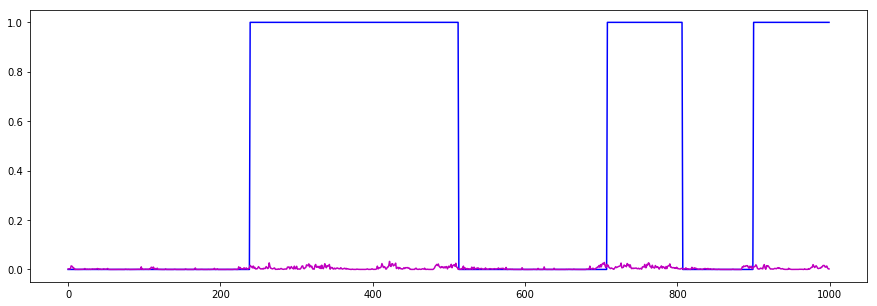

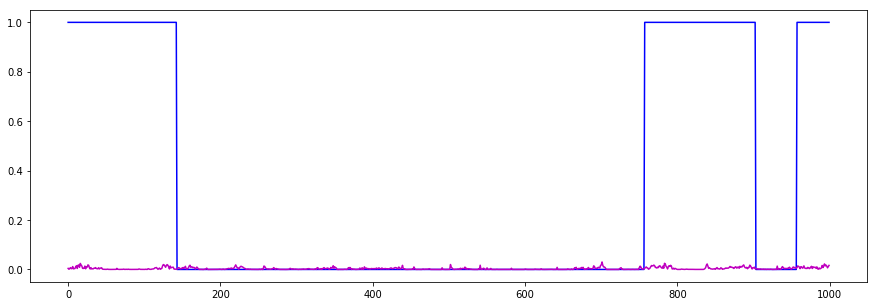

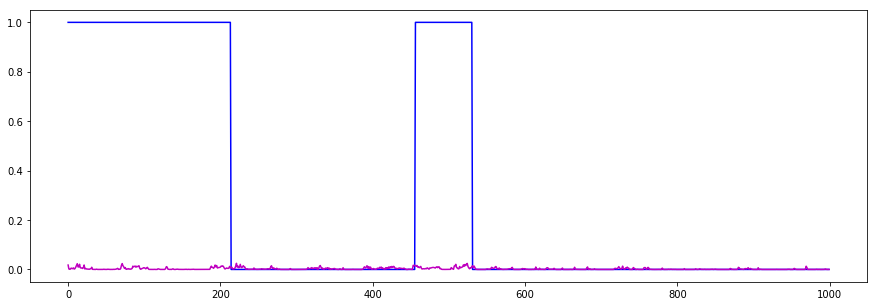

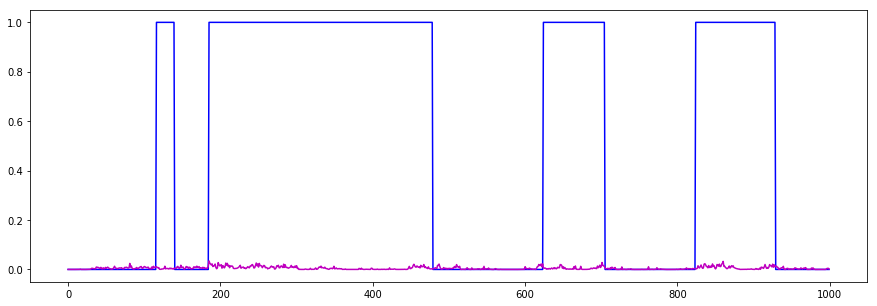

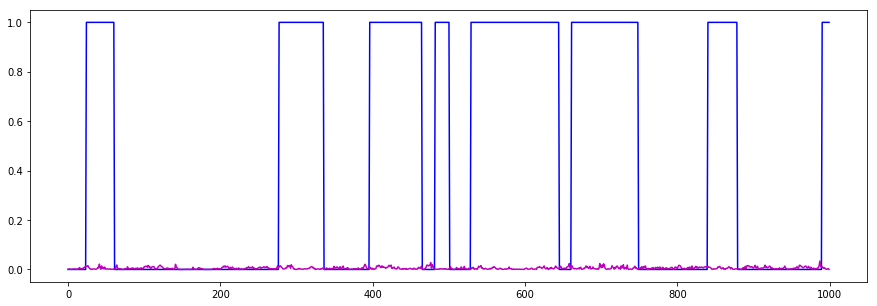

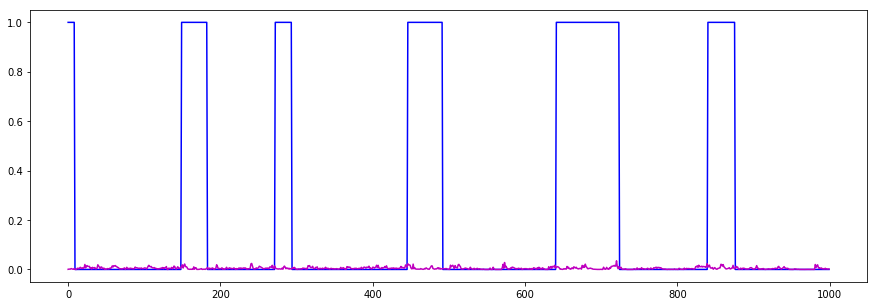

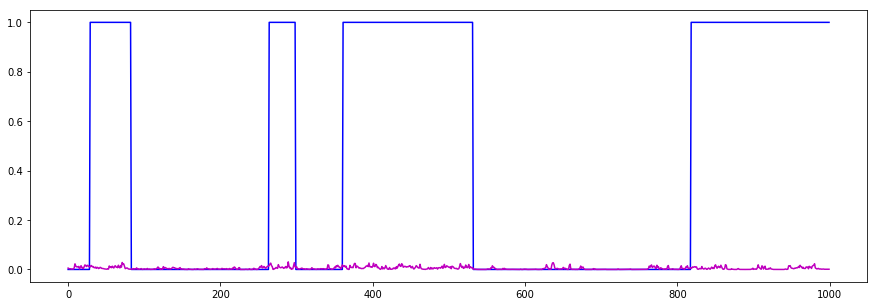

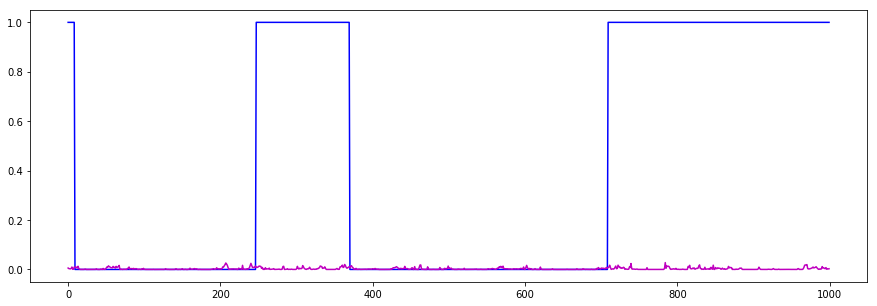

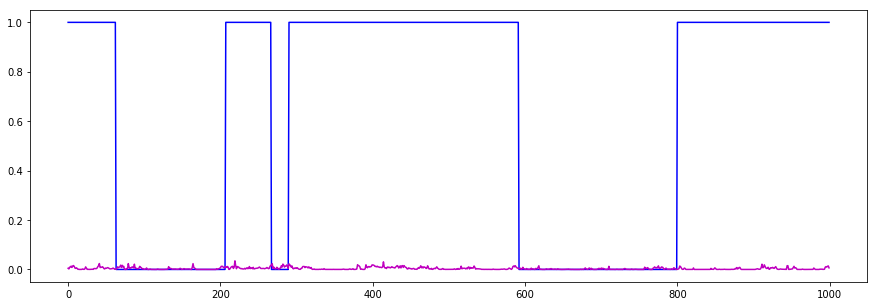

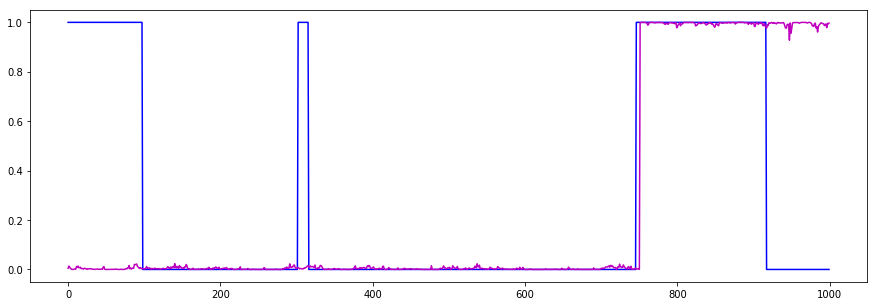

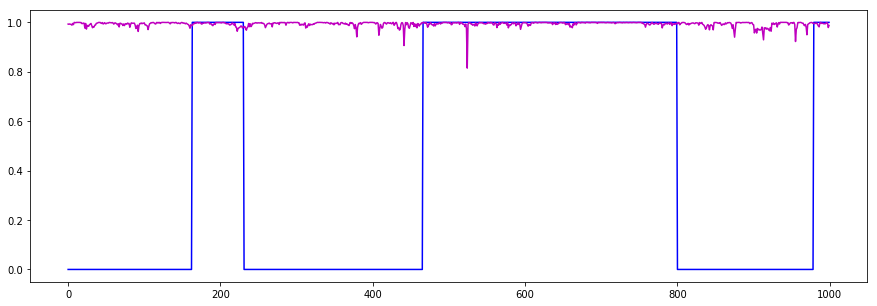

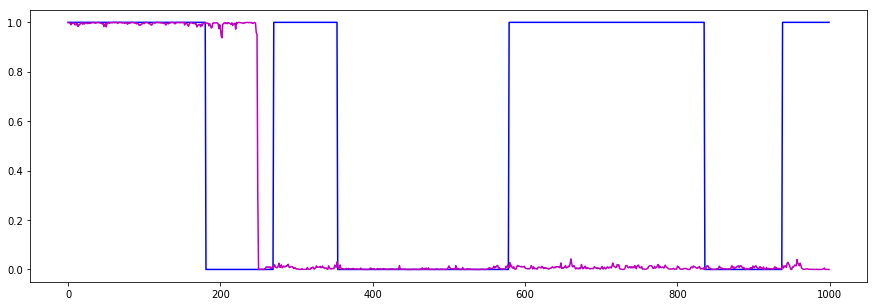

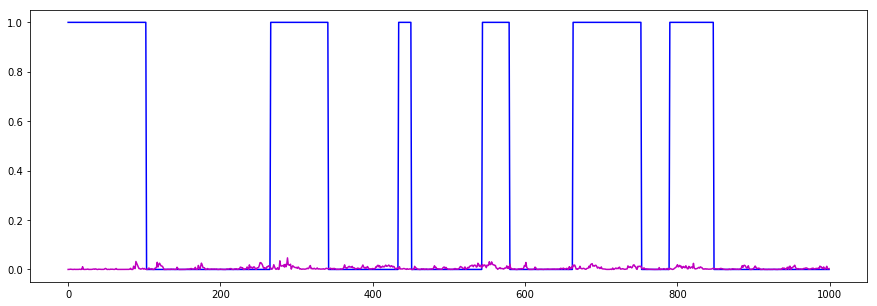

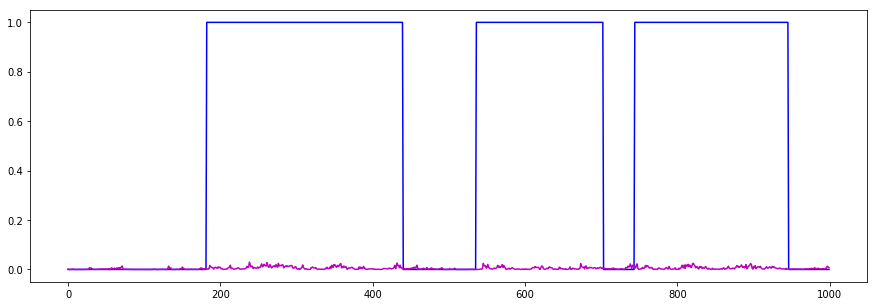

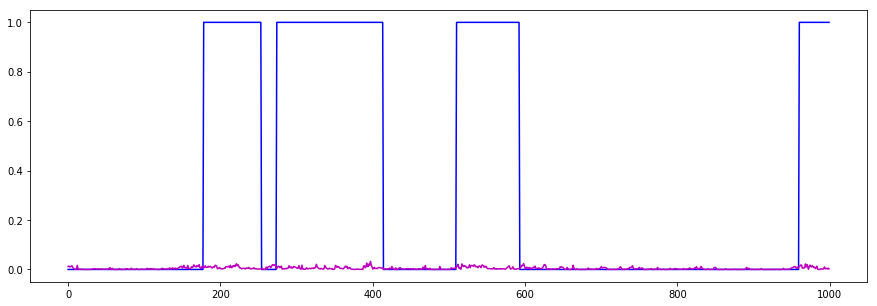

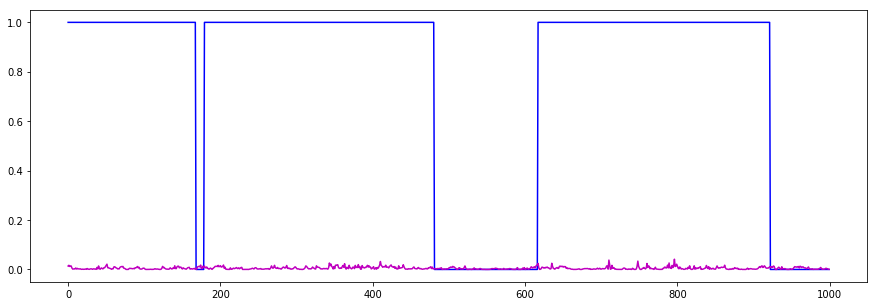

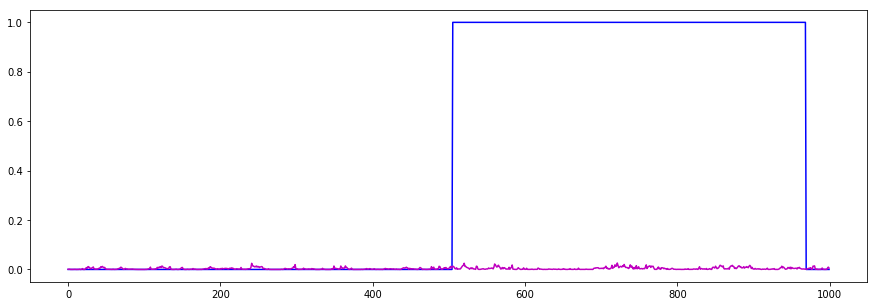

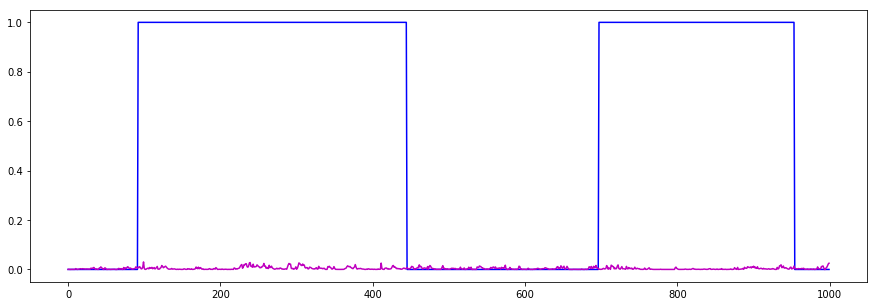

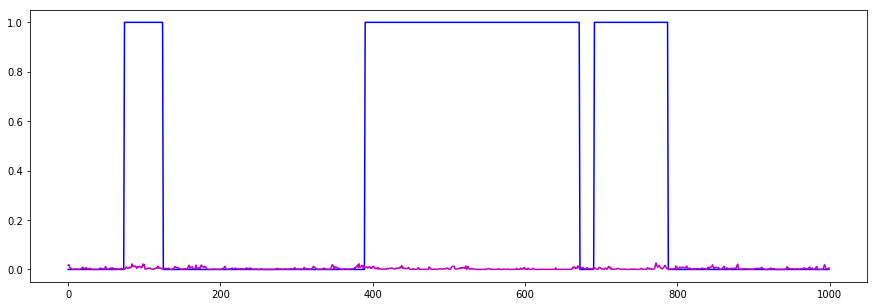

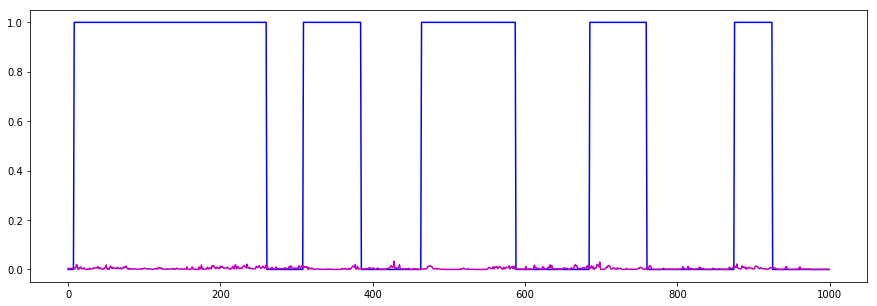

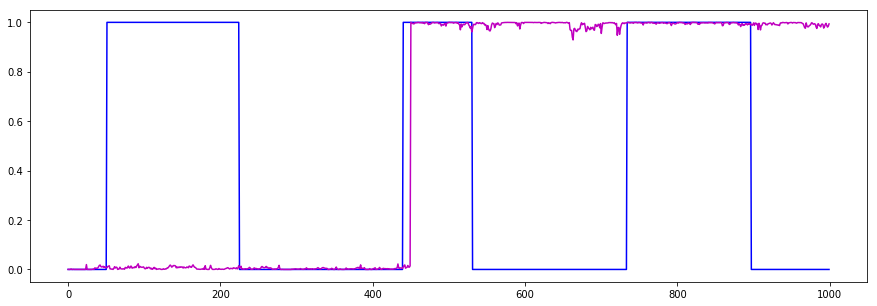

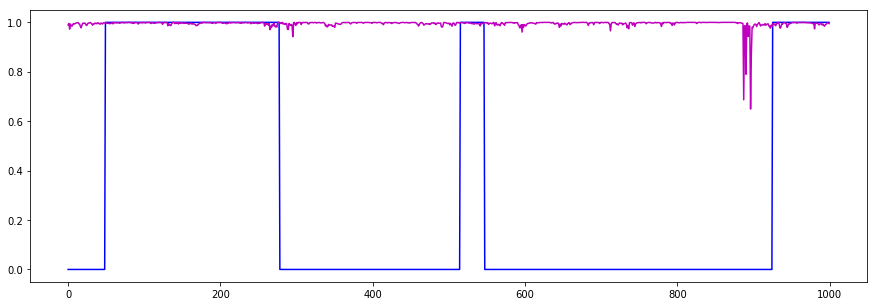

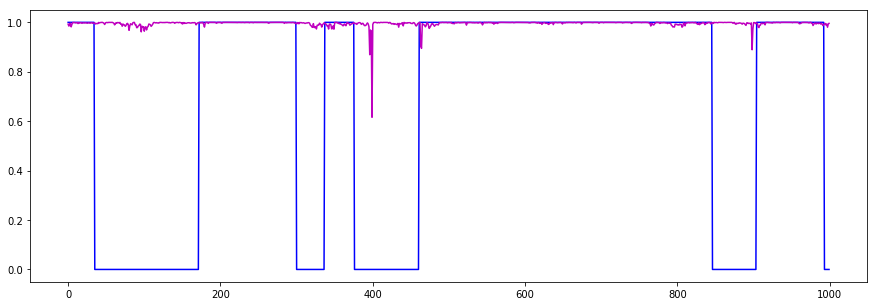

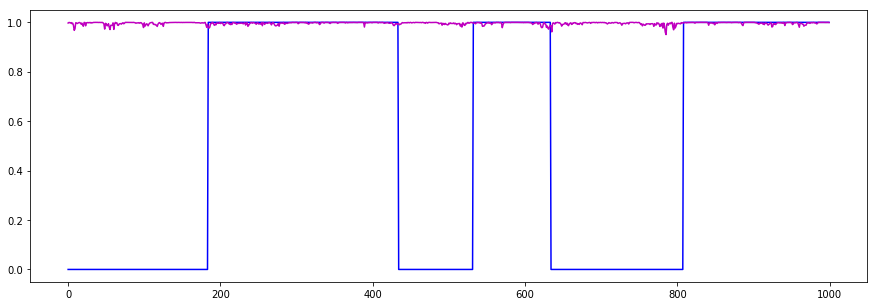

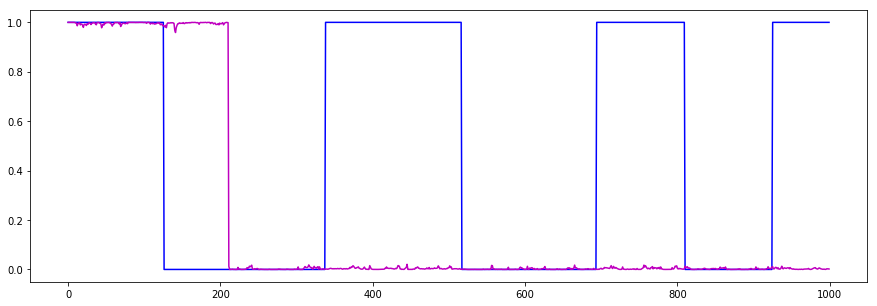

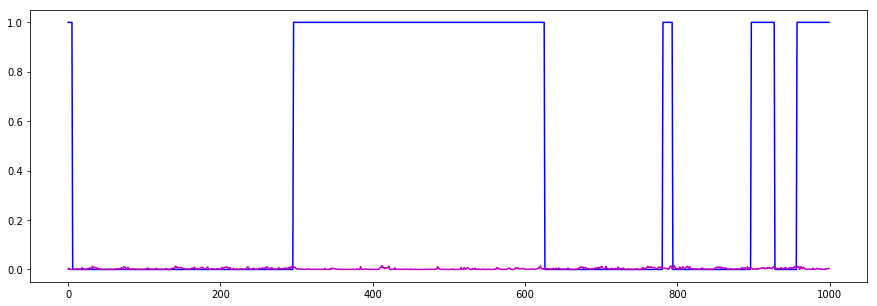

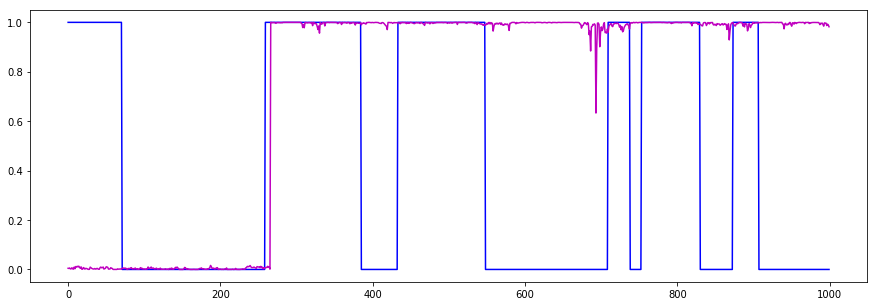

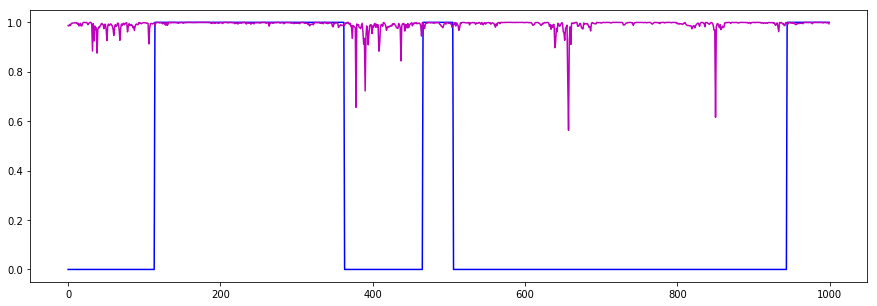

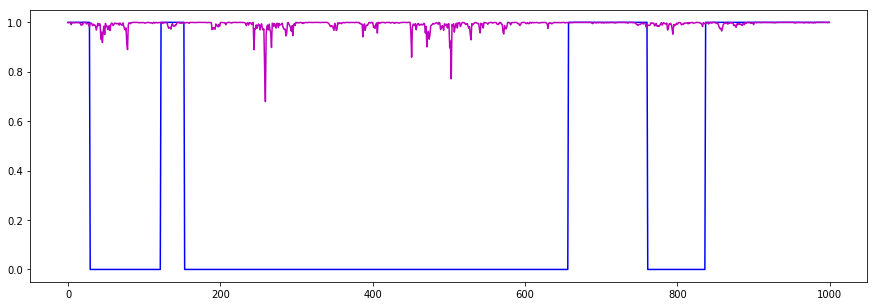

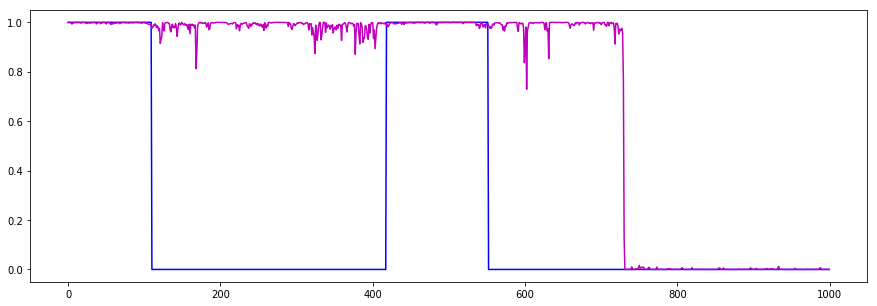

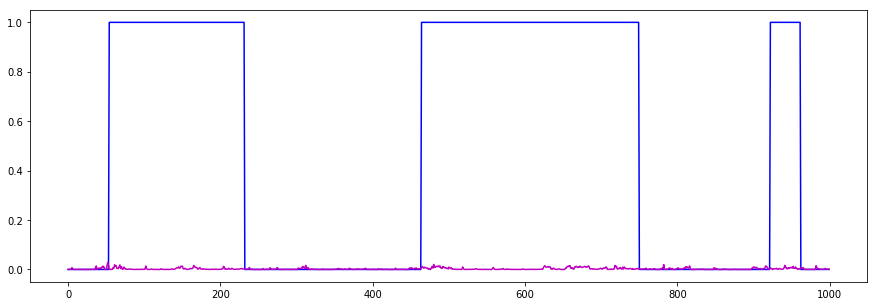

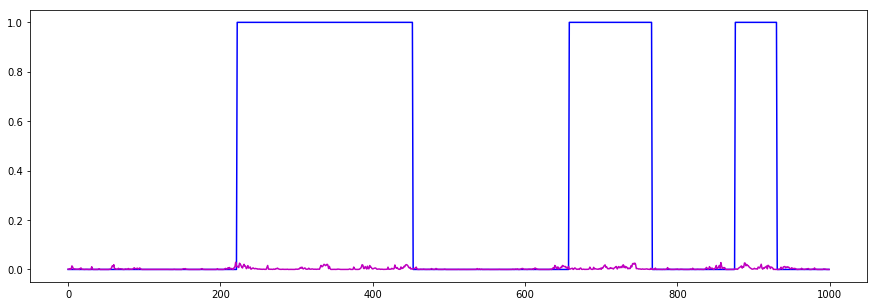

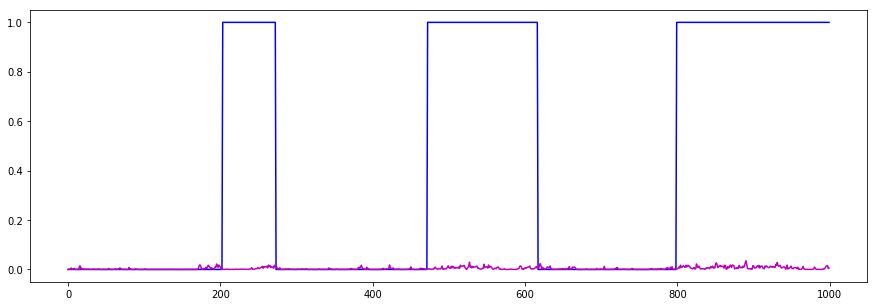

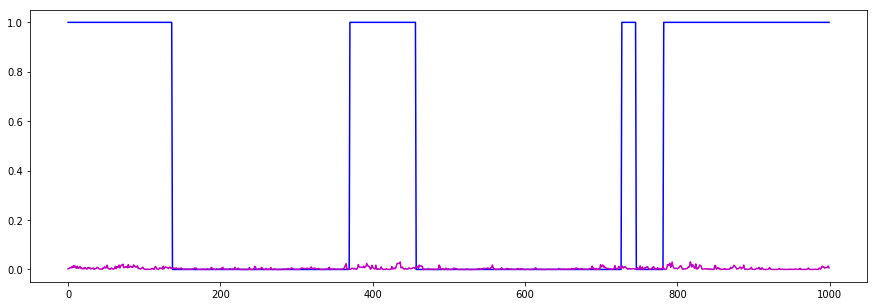

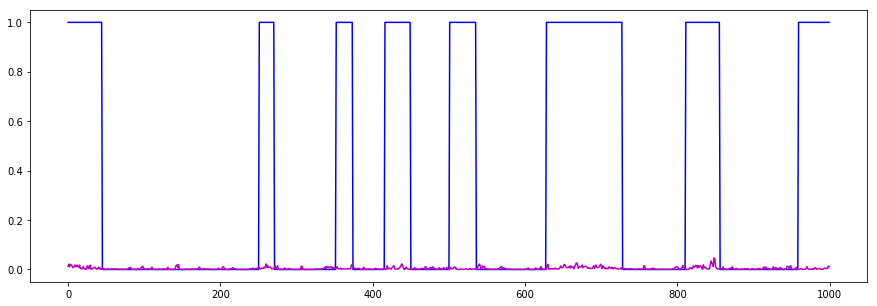

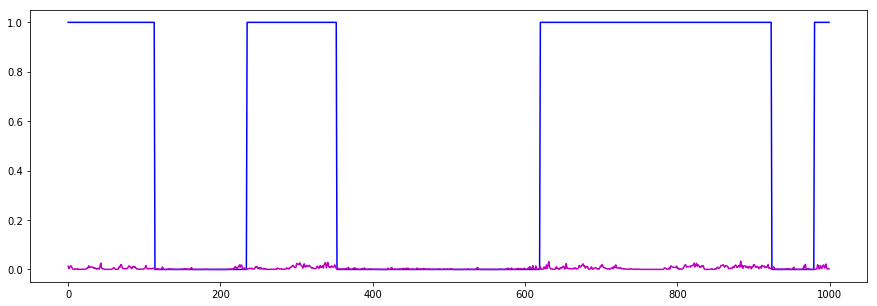

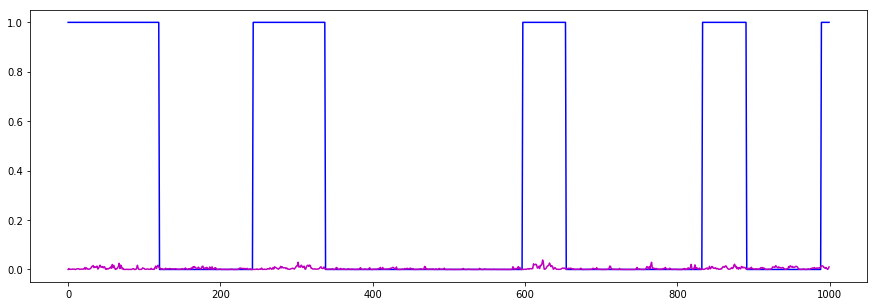

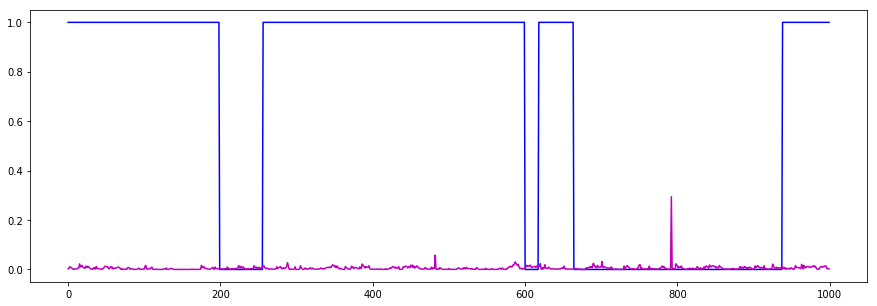

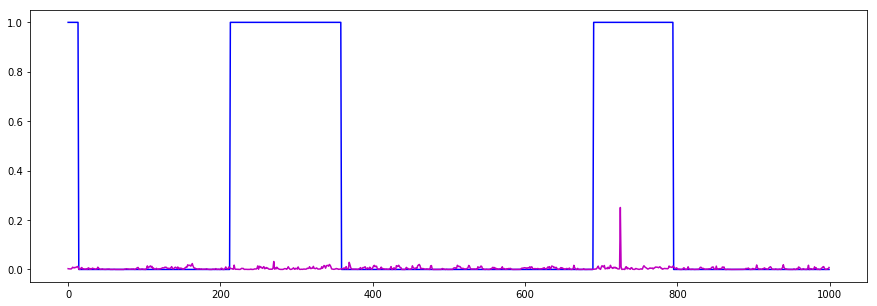

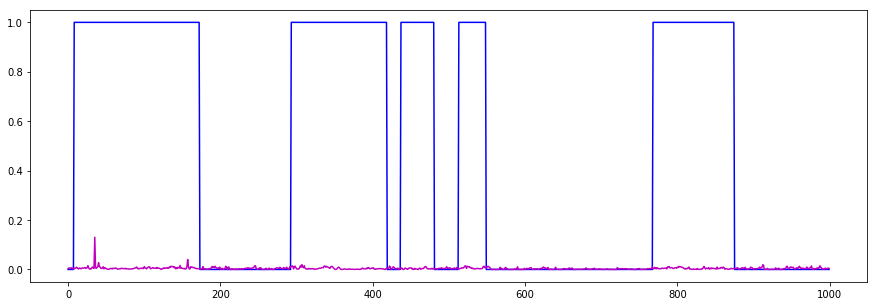

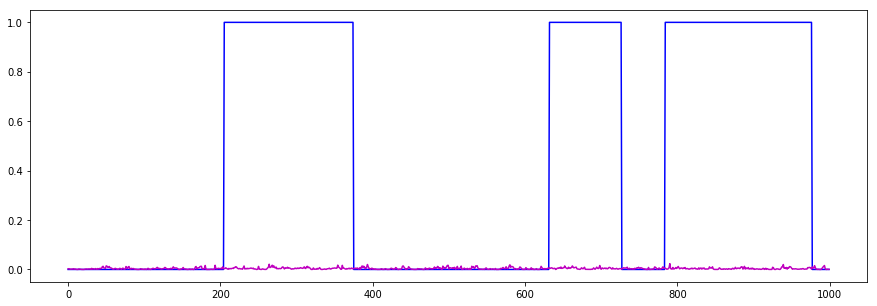

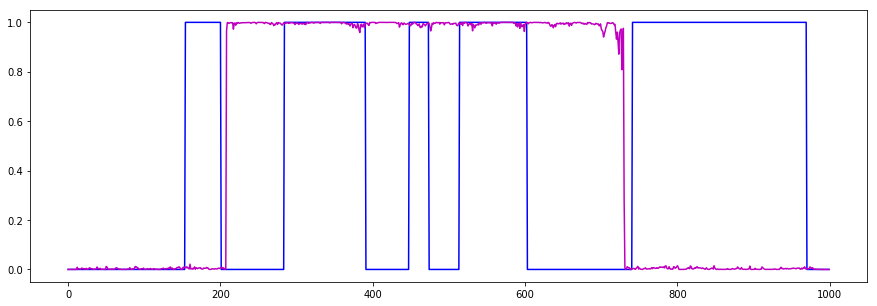

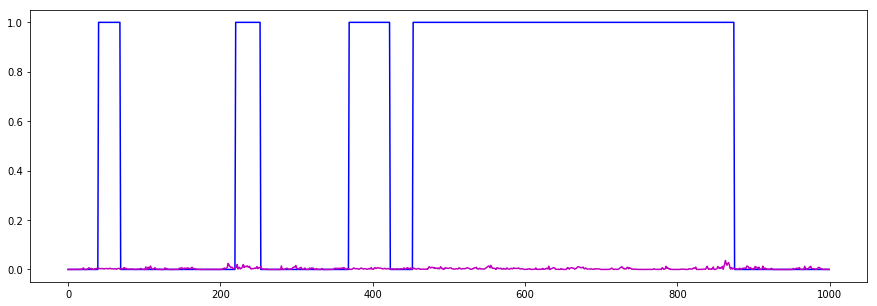

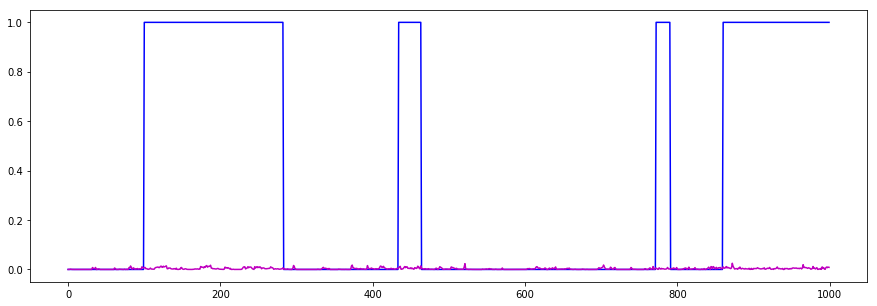

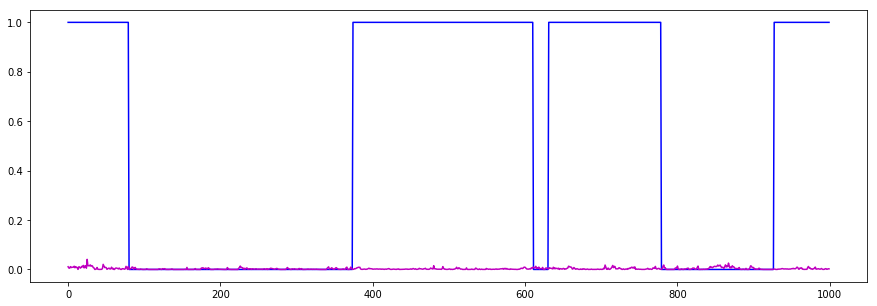

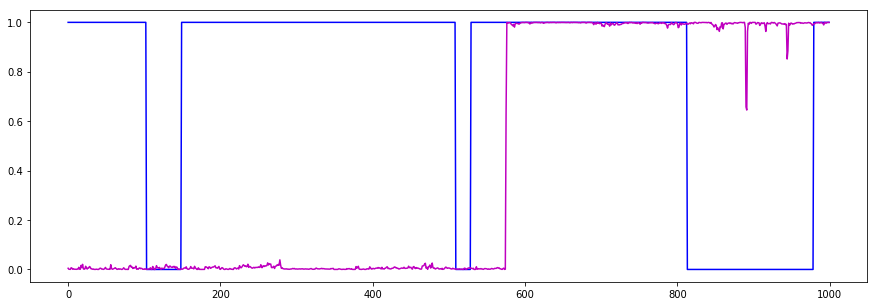

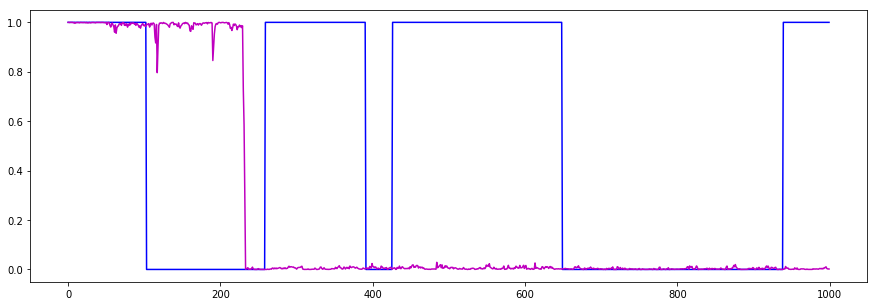

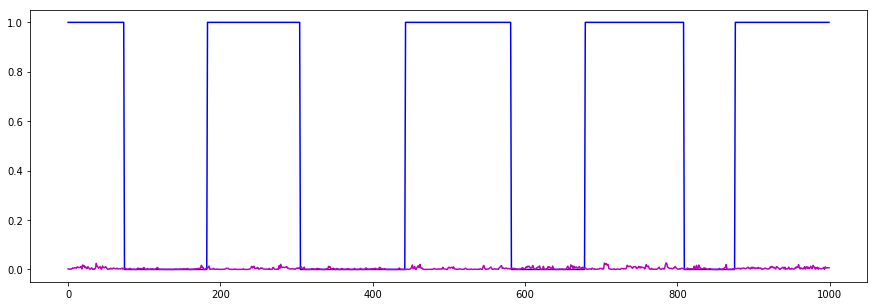

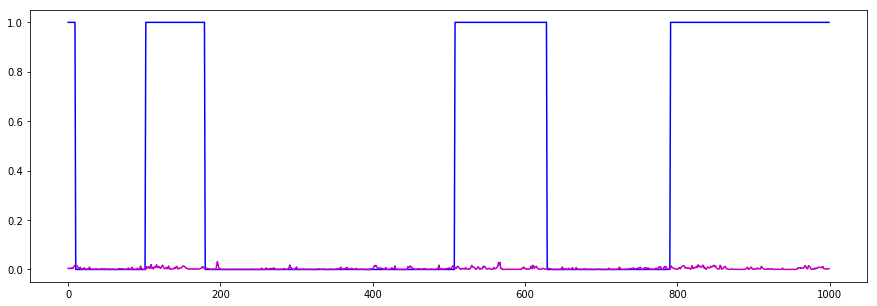

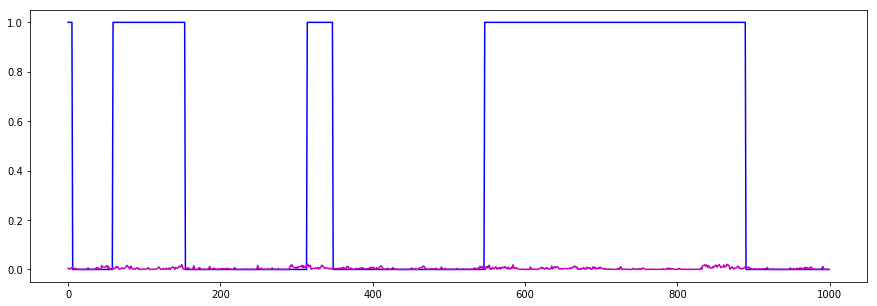

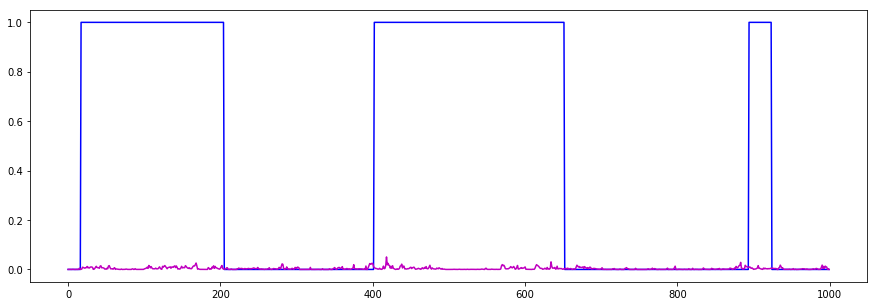

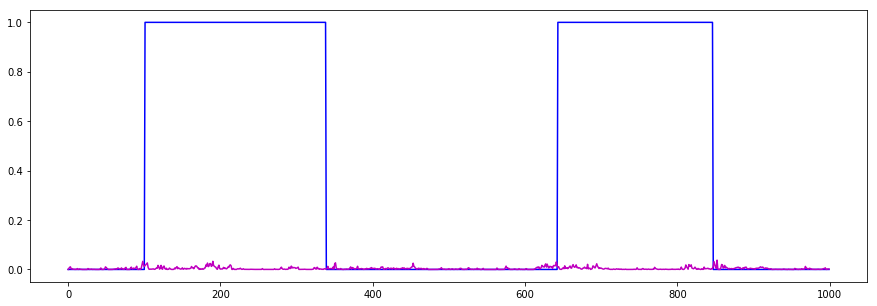

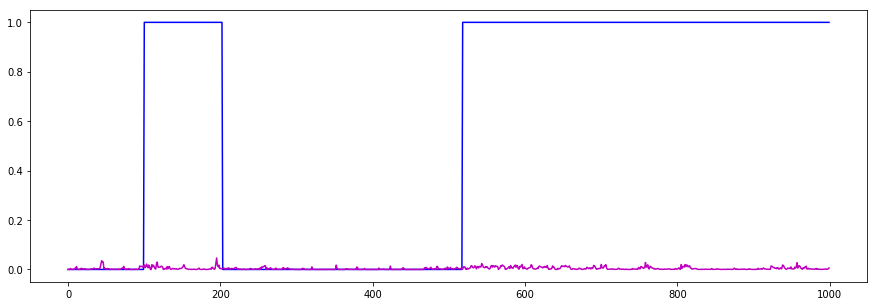

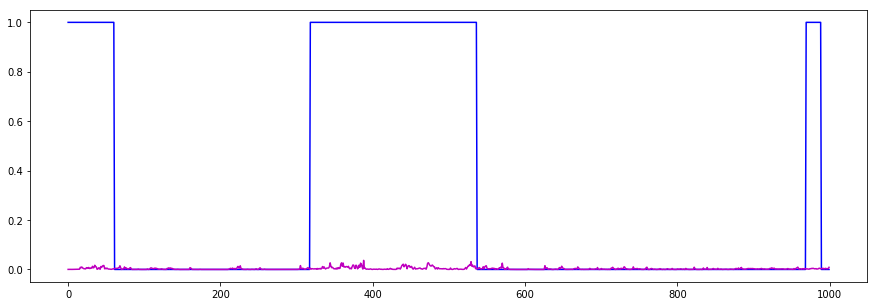

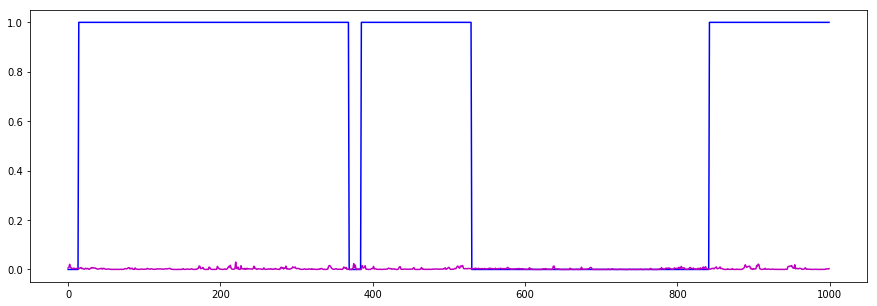

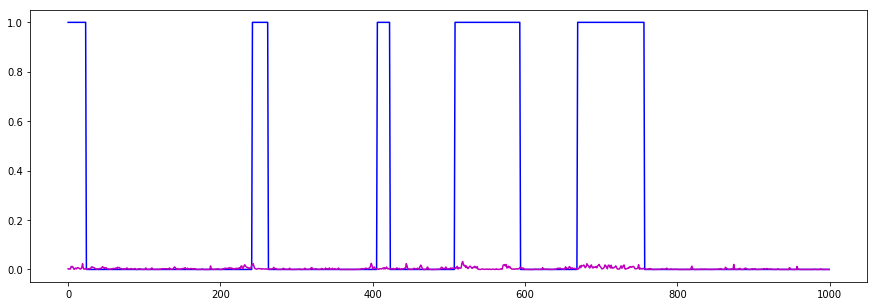

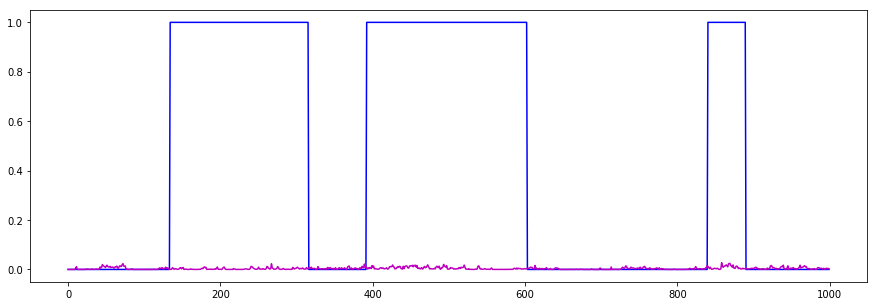

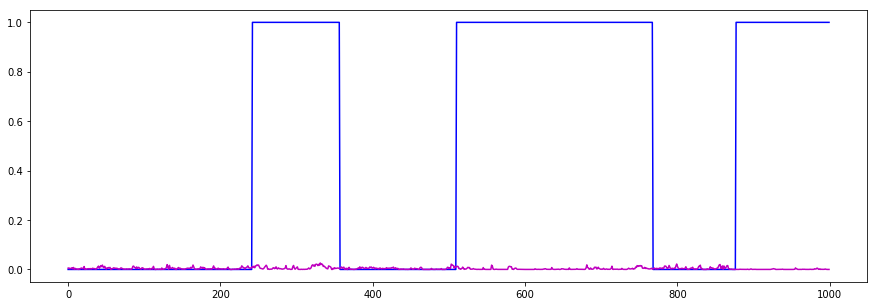

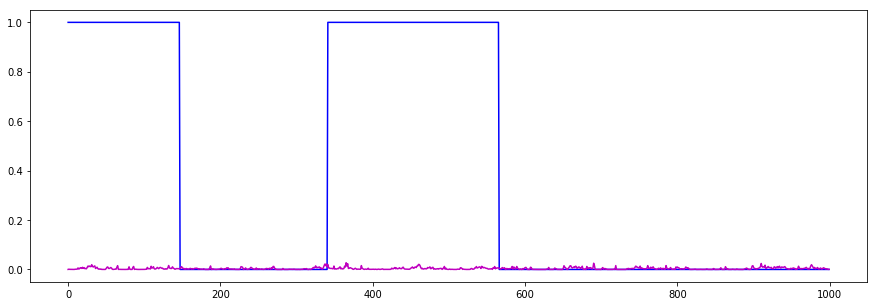

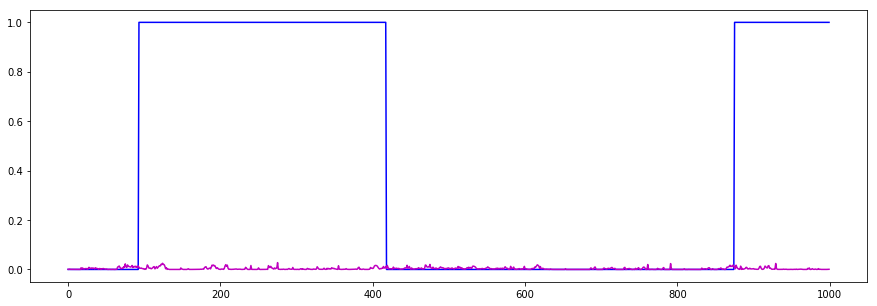

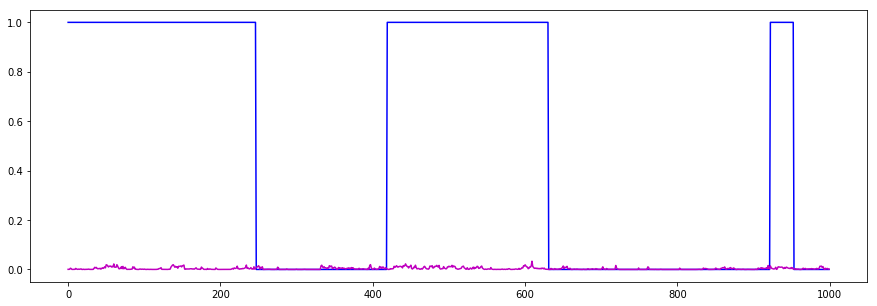

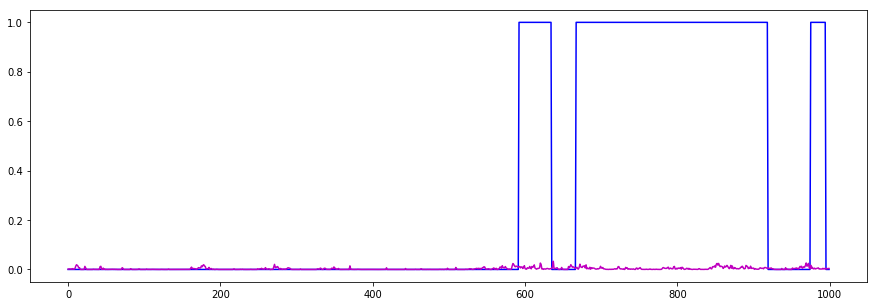

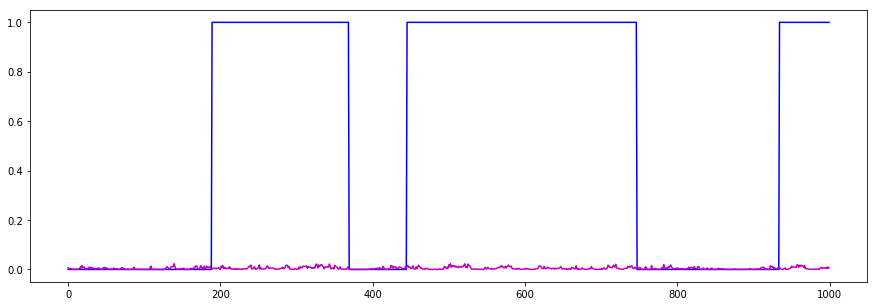

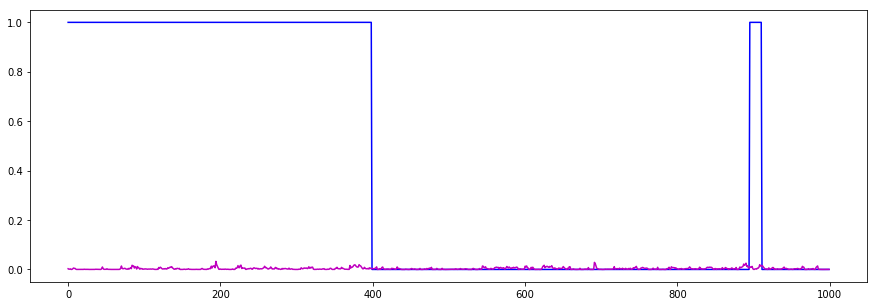

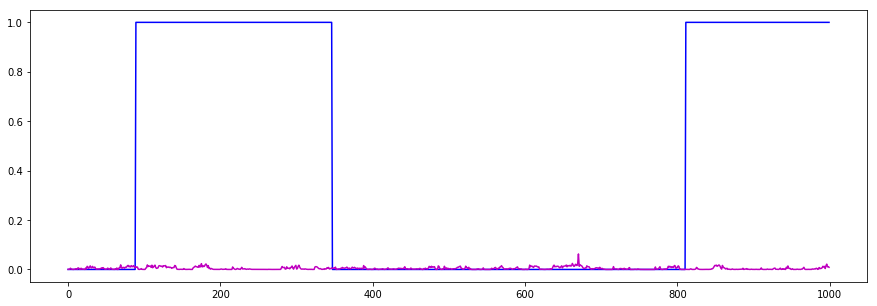

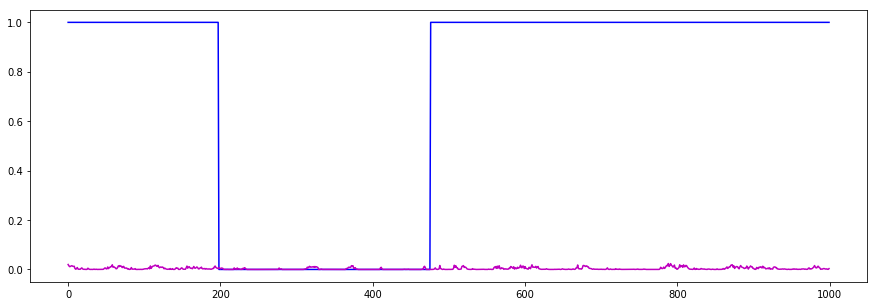

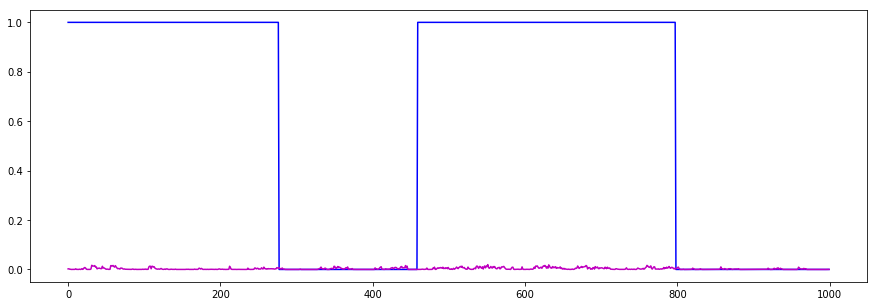

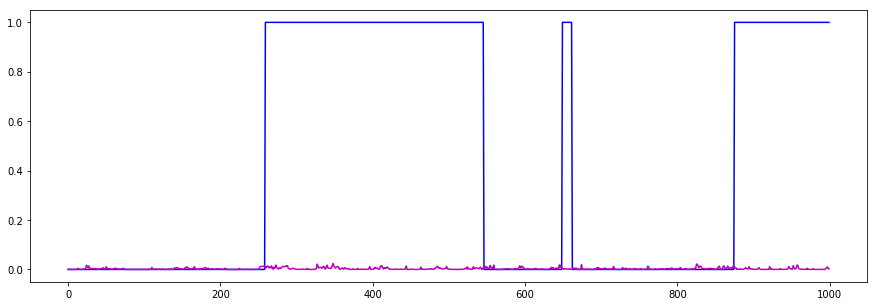

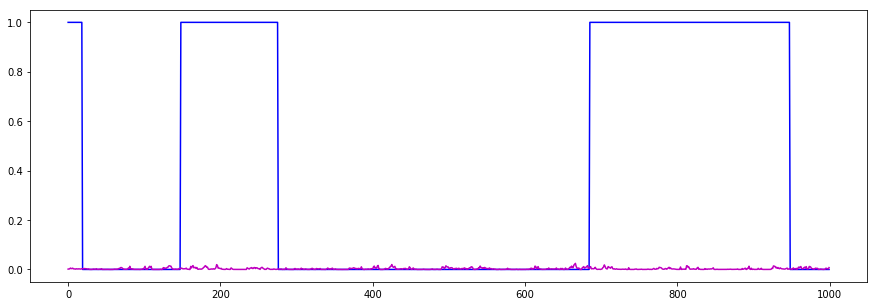

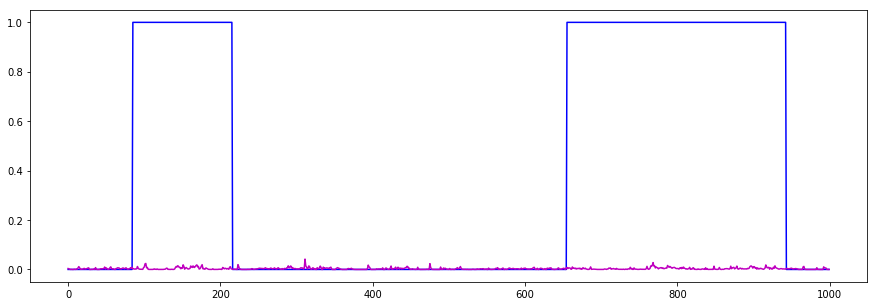

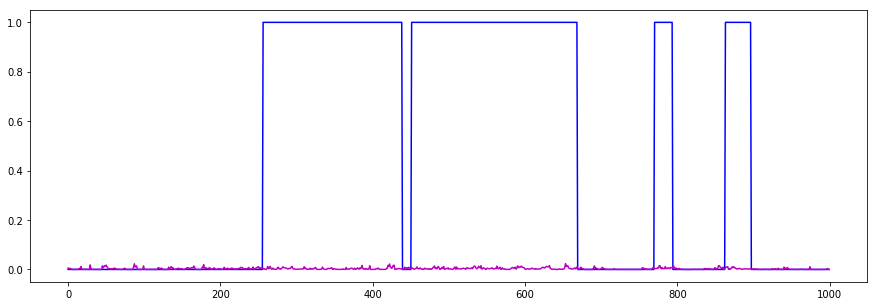

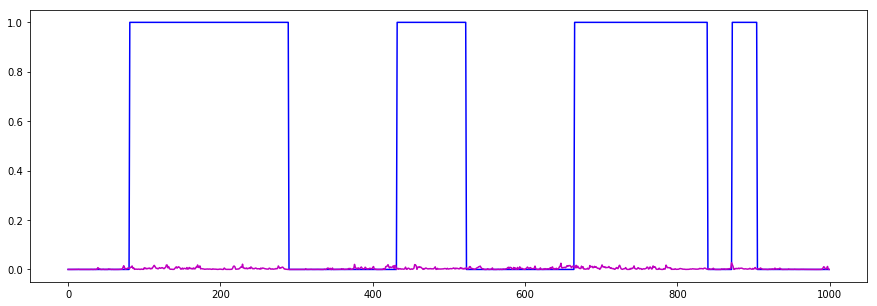

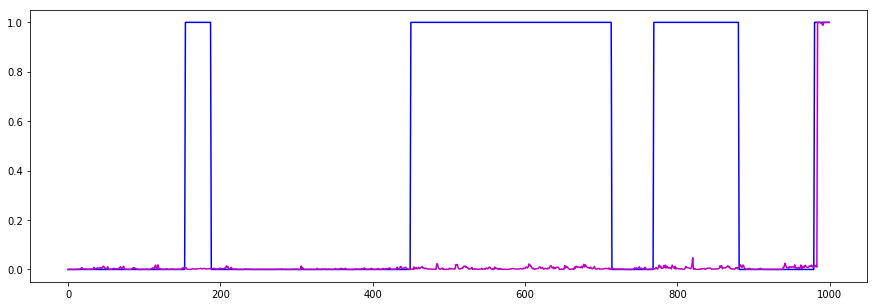

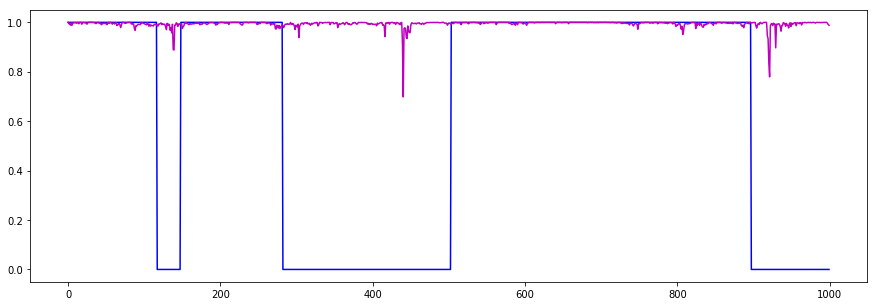

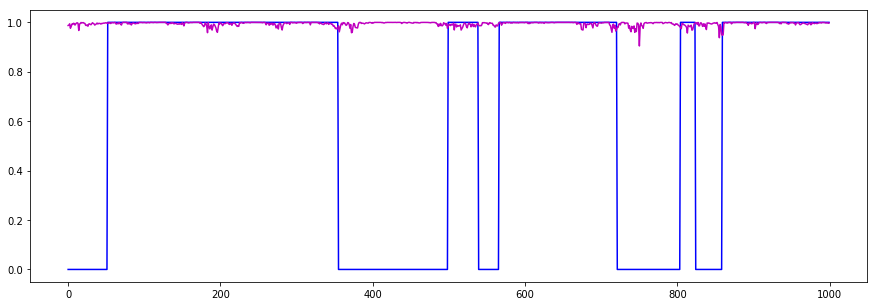

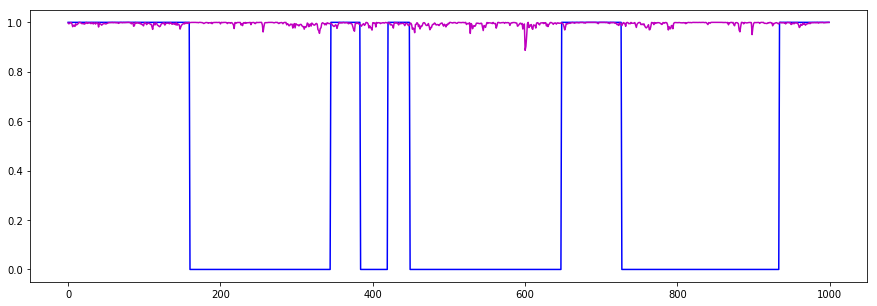

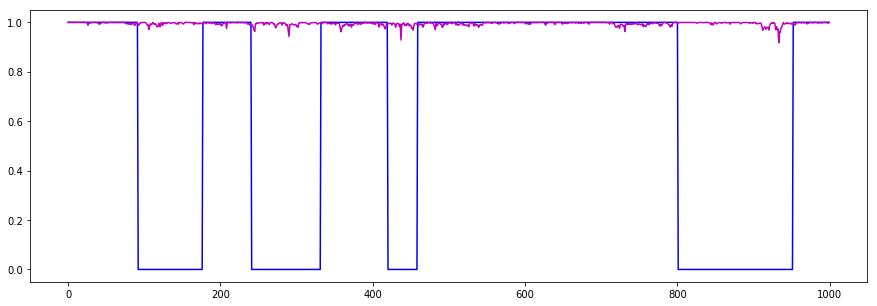

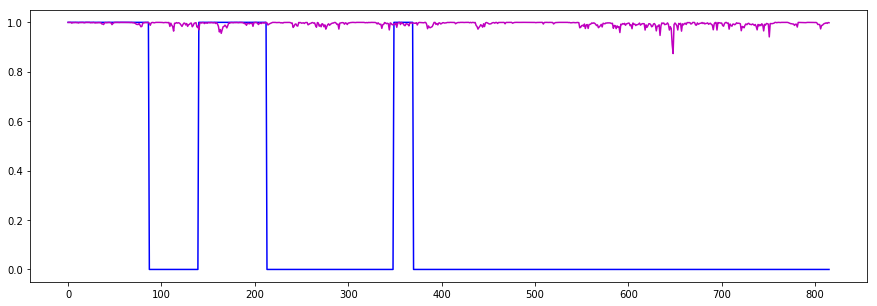

In [8]:
for i in range(0,len(y),1000):
    plt.figure(figsize=(15,5))
    plt.plot(y[i:i+1000],color='b')
    plt.plot(y_pred[i:i+1000],color='m')

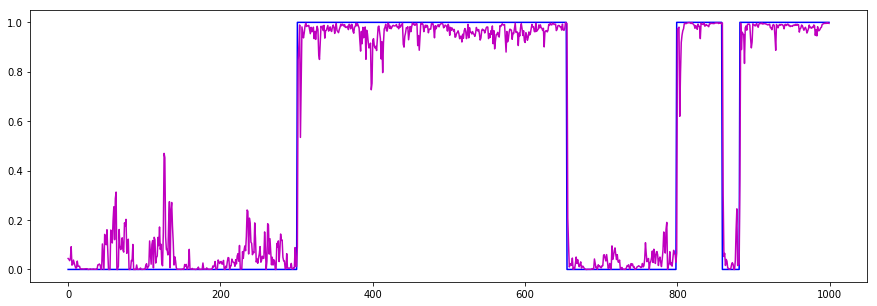

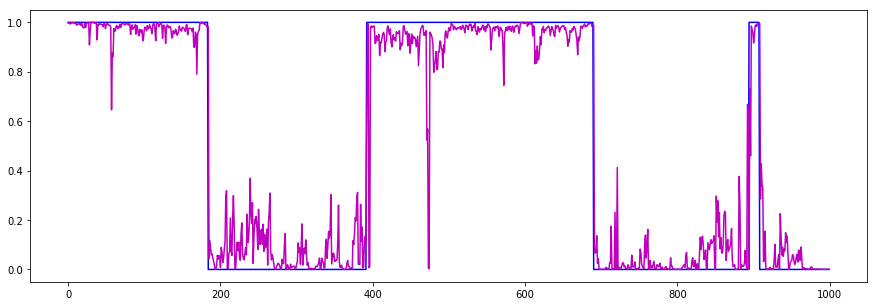

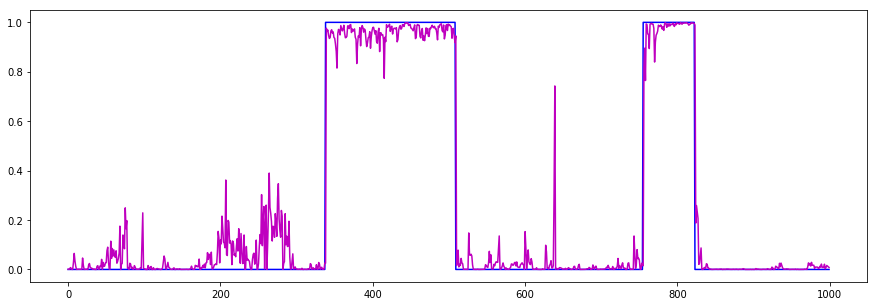

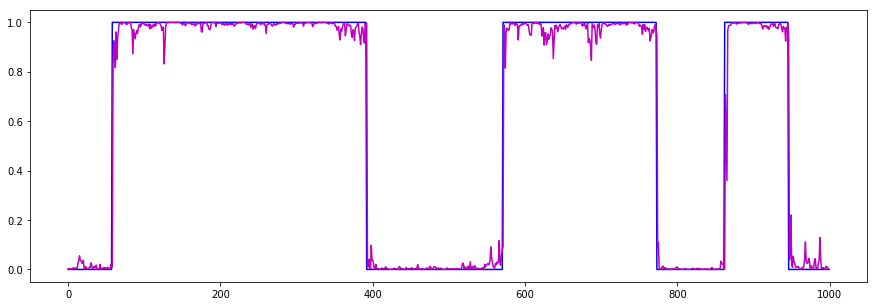

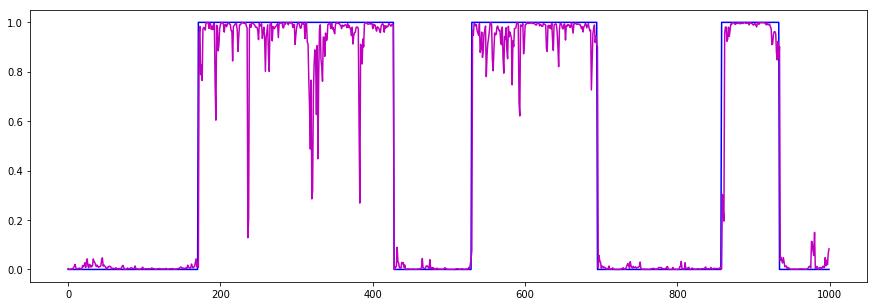

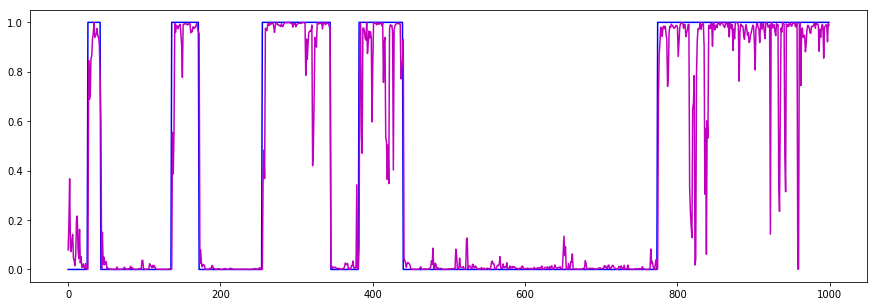

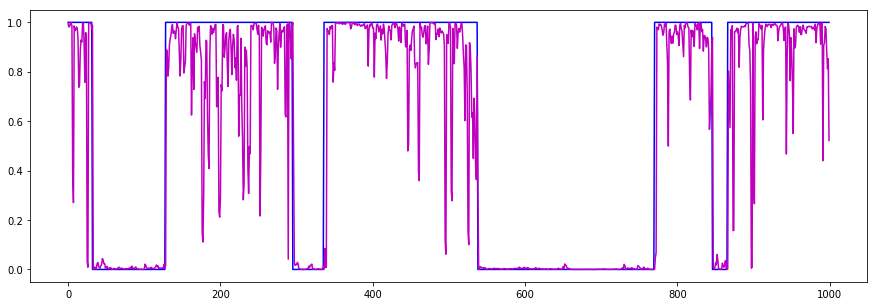

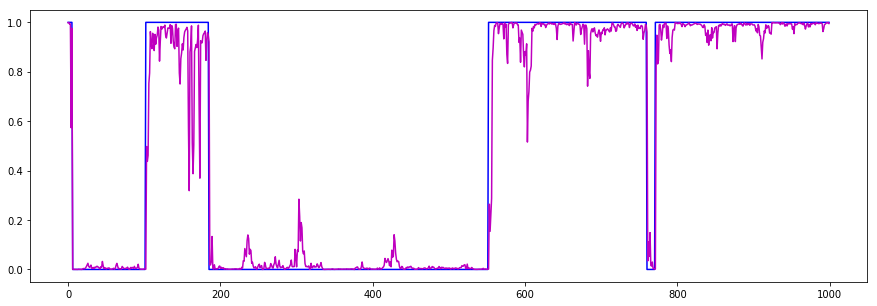

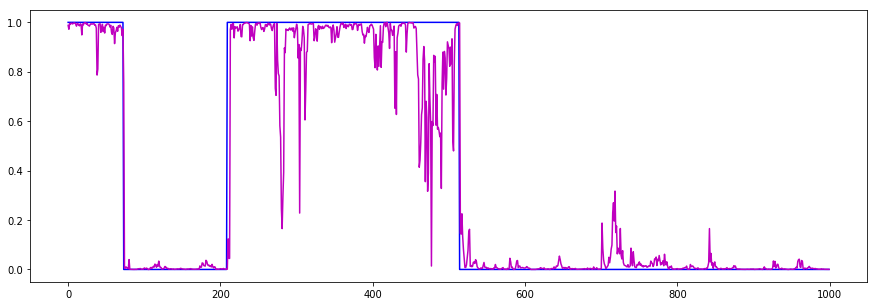

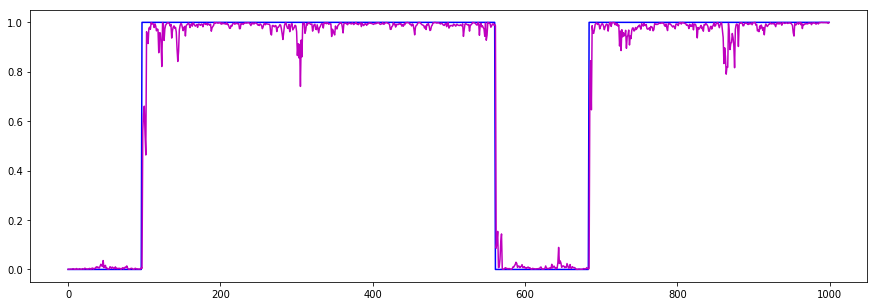

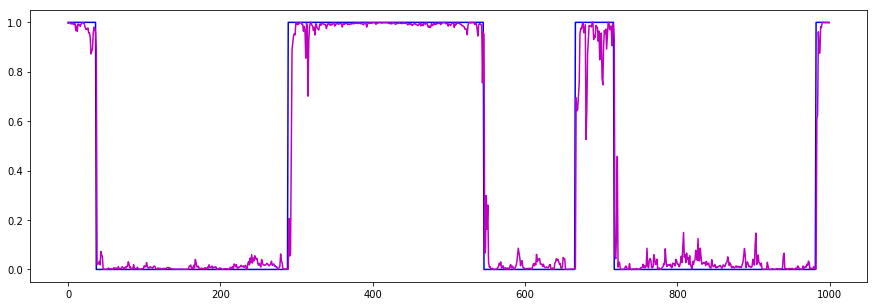

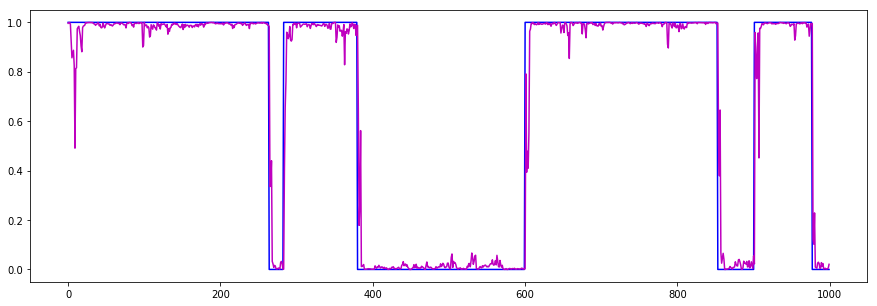

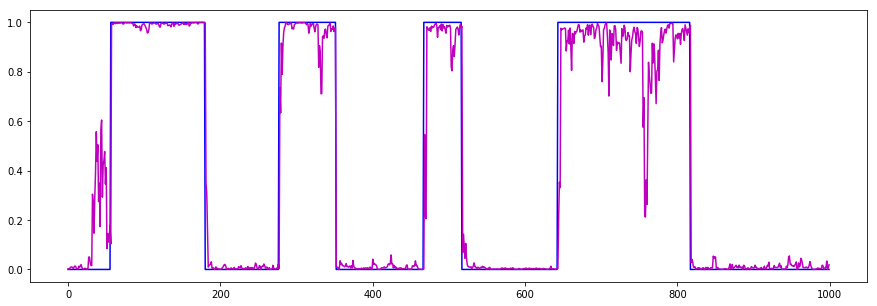

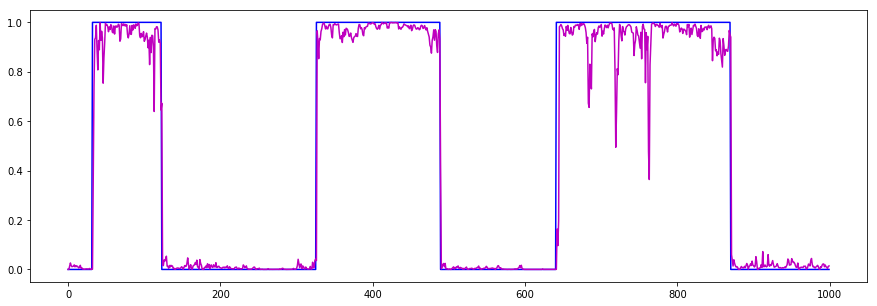

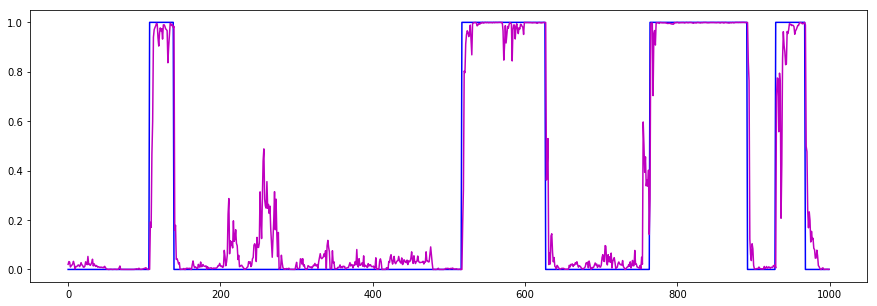

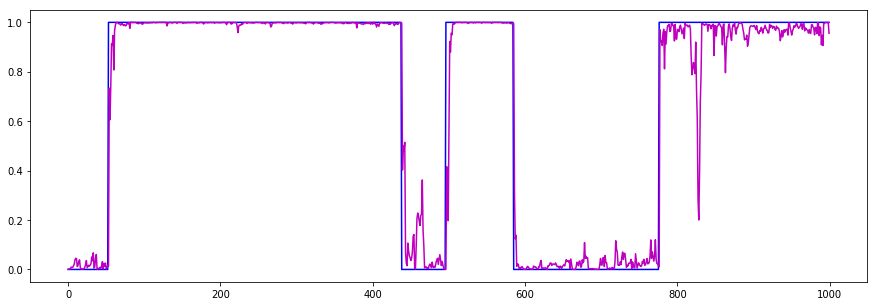

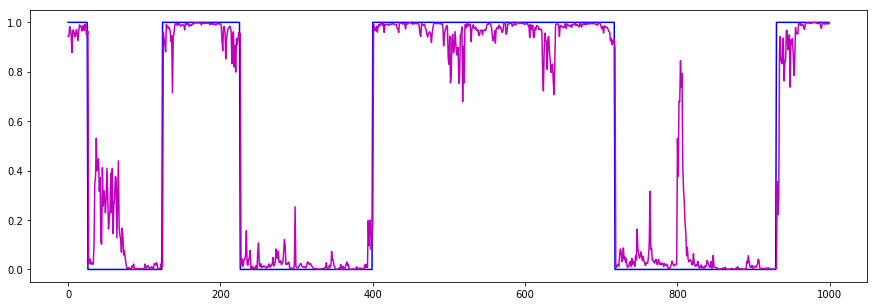

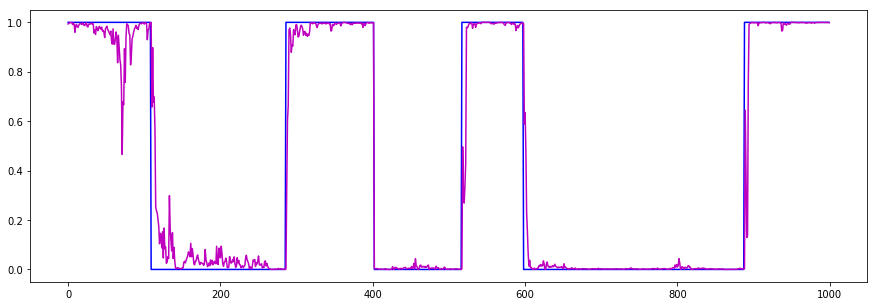

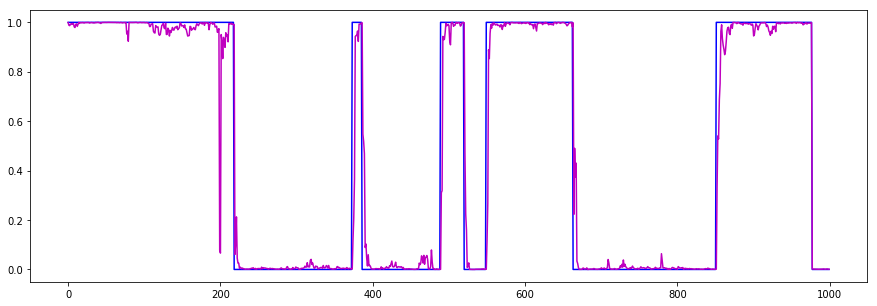

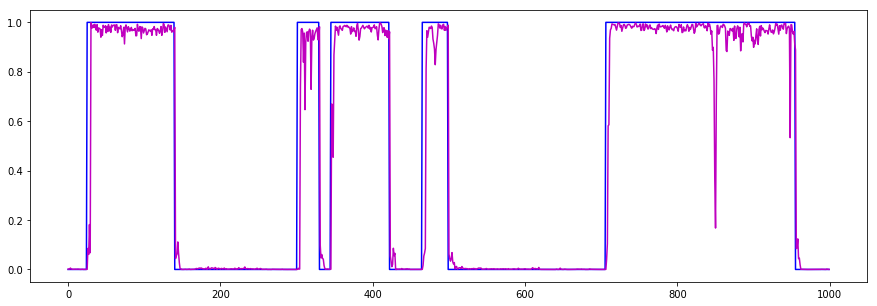

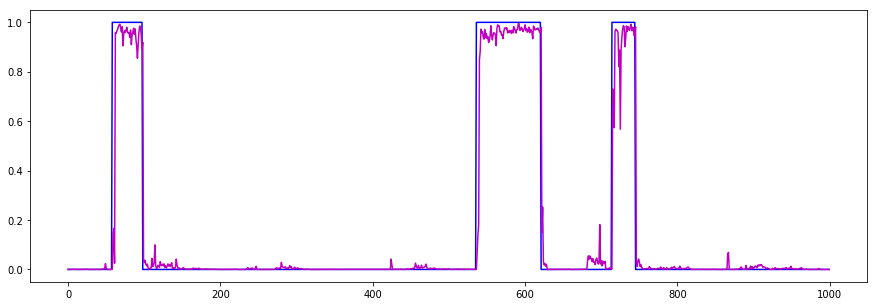

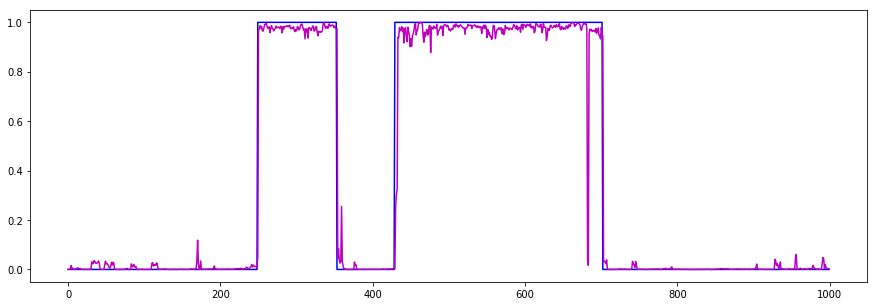

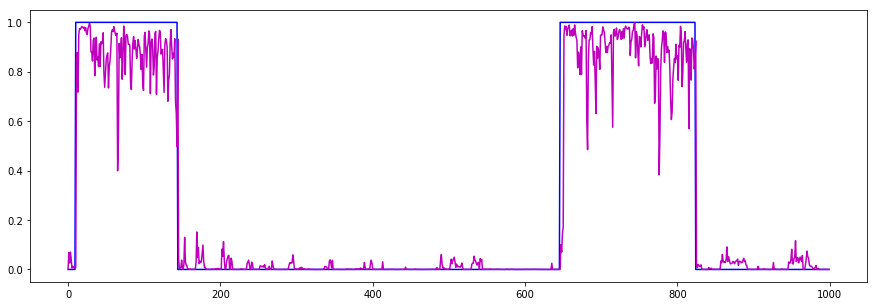

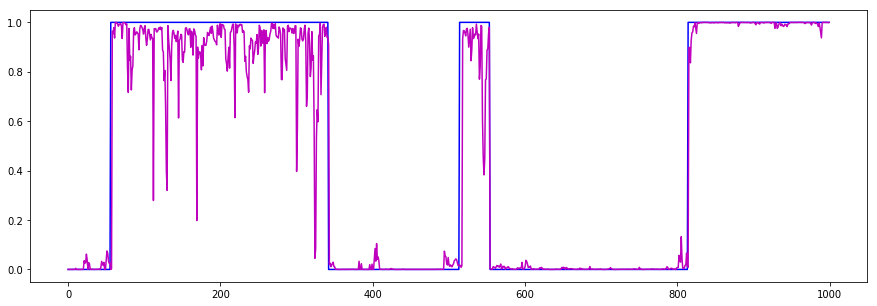

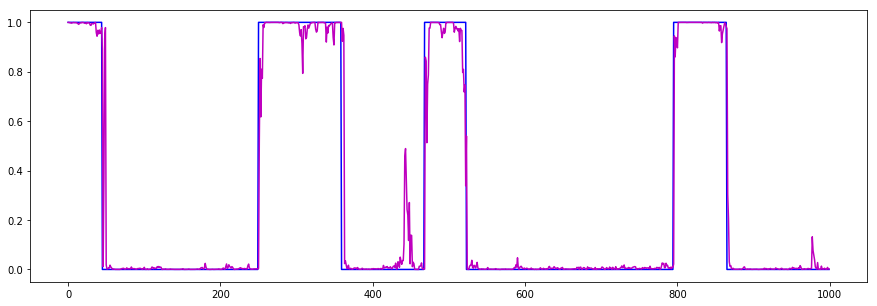

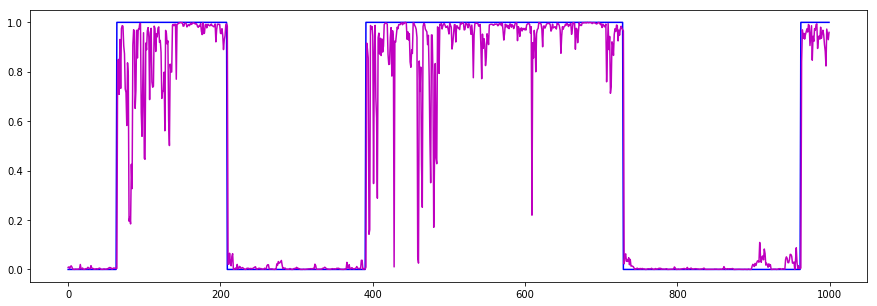

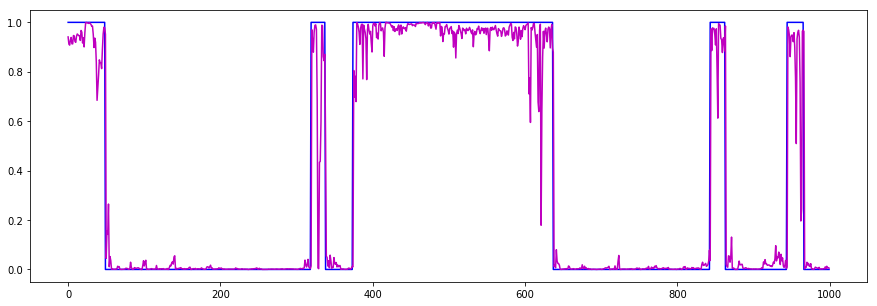

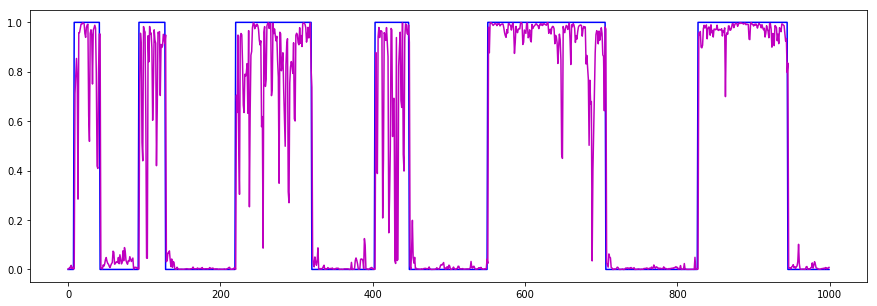

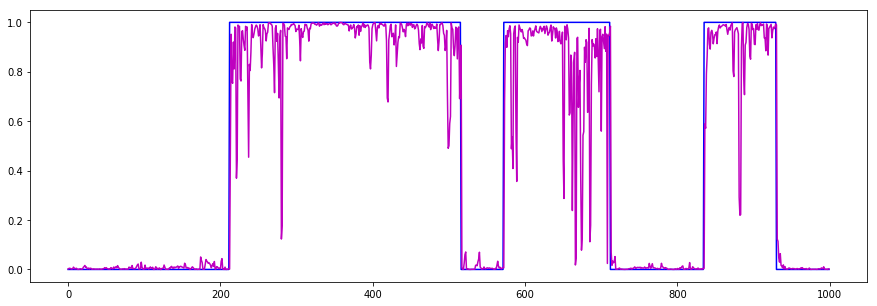

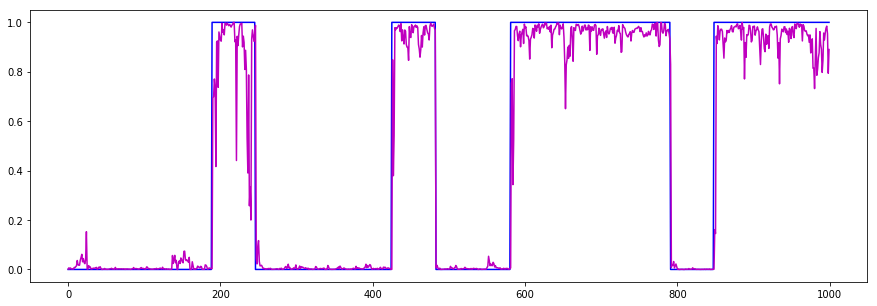

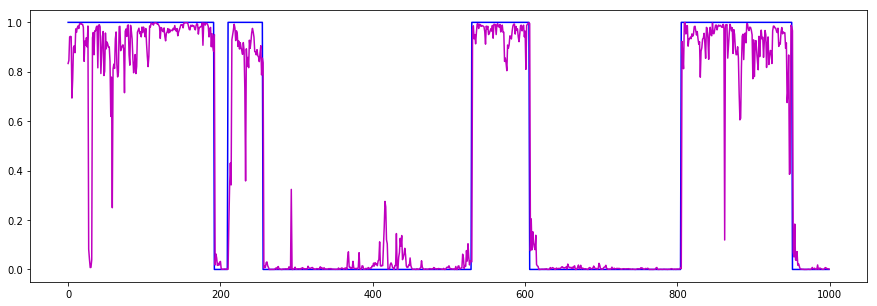

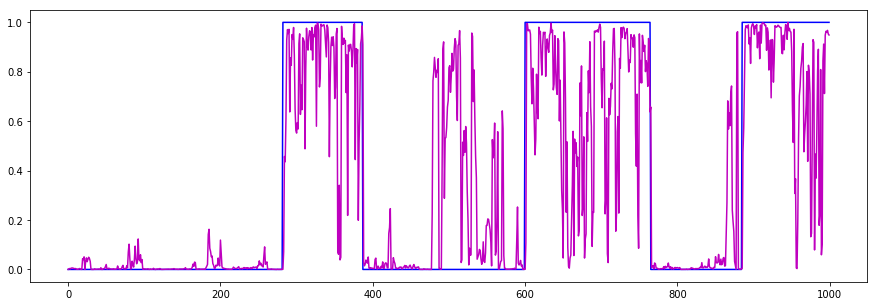

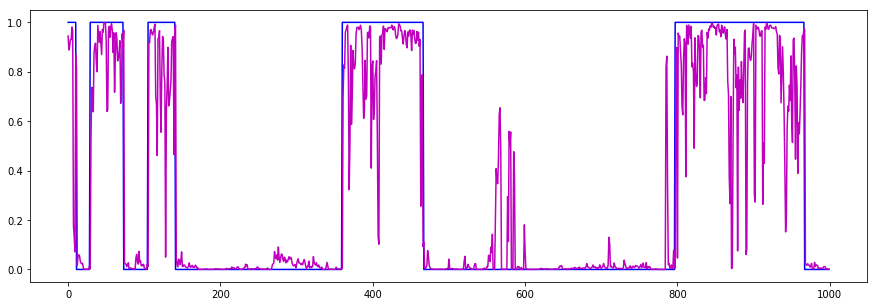

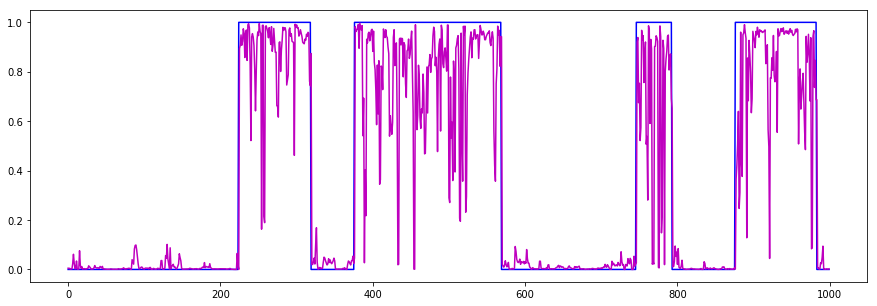

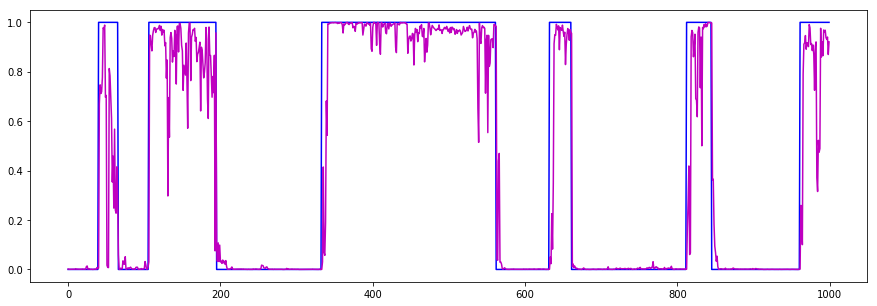

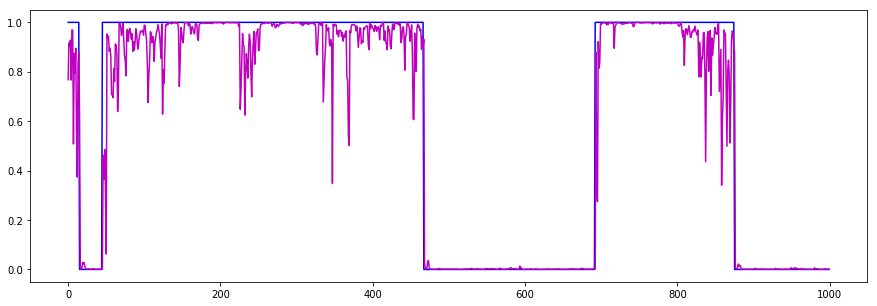

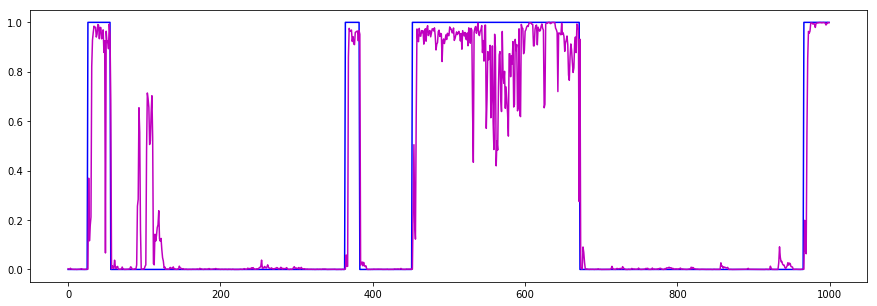

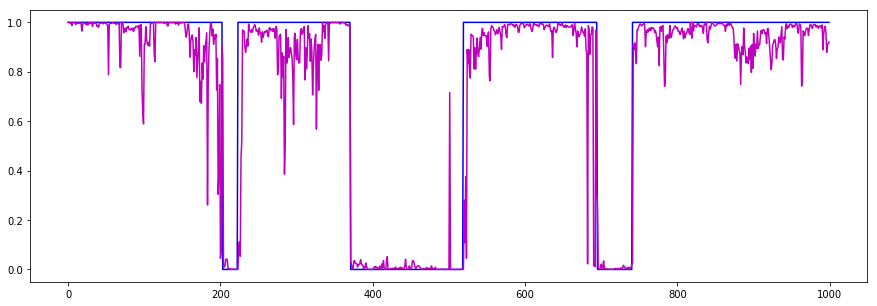

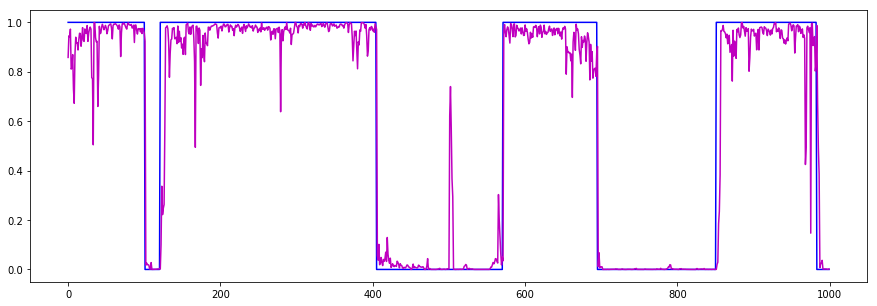

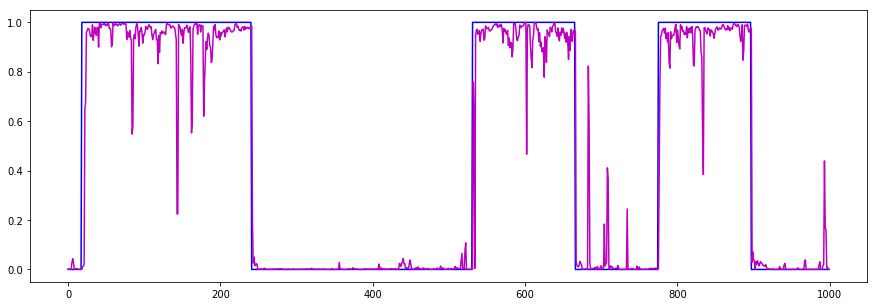

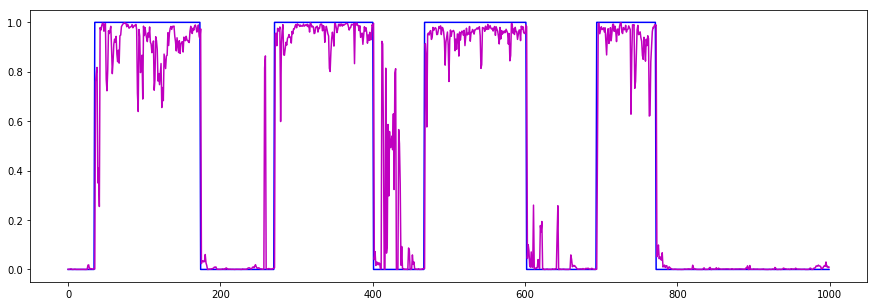

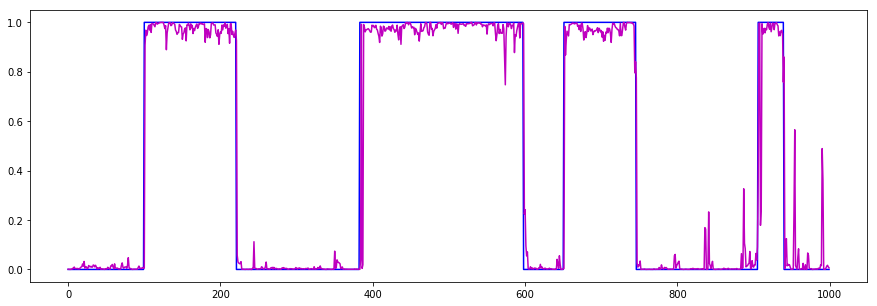

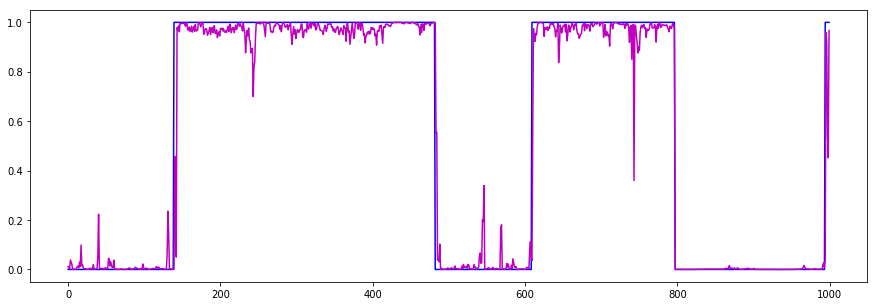

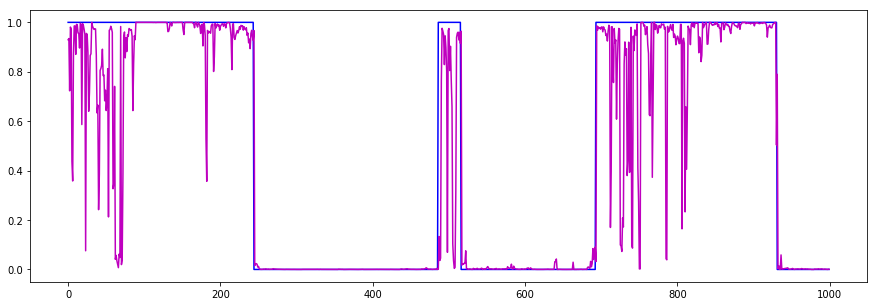

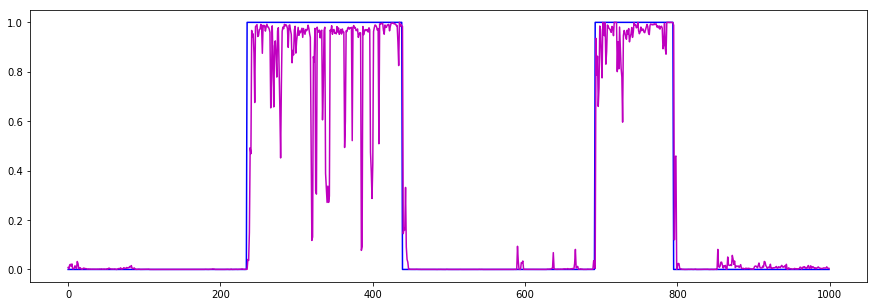

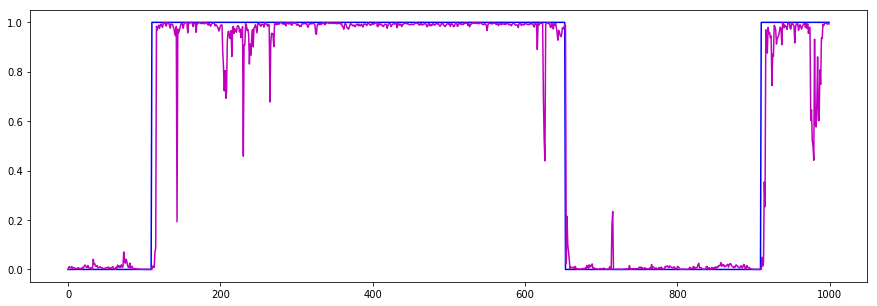

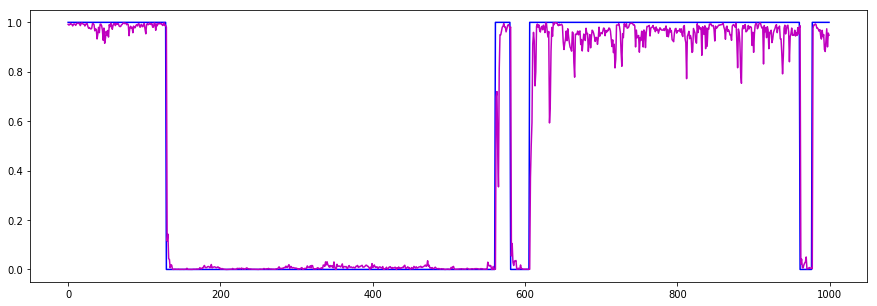

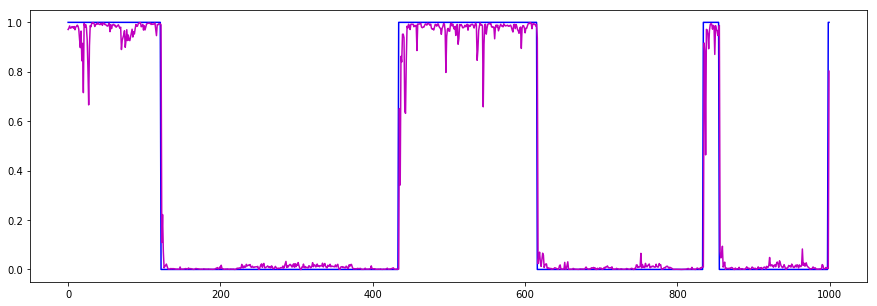

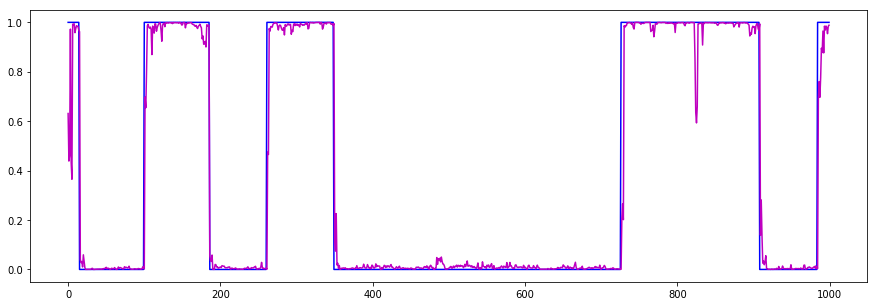

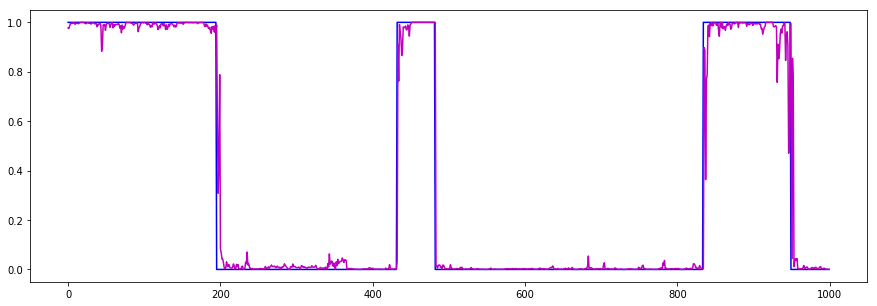

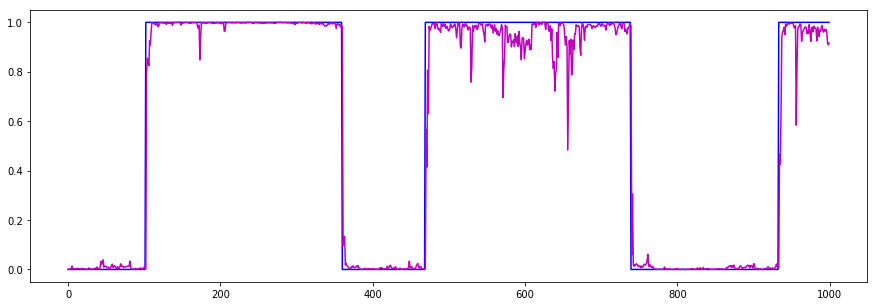

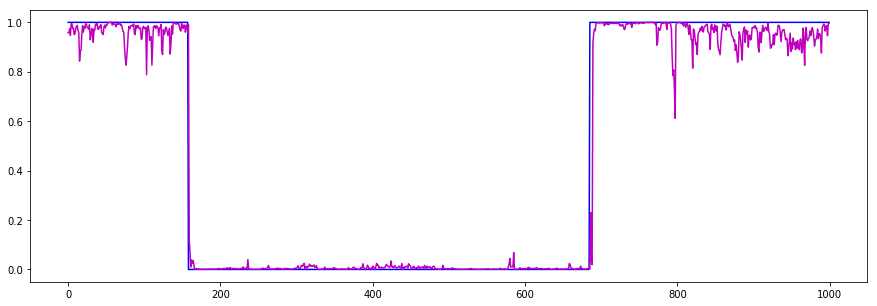

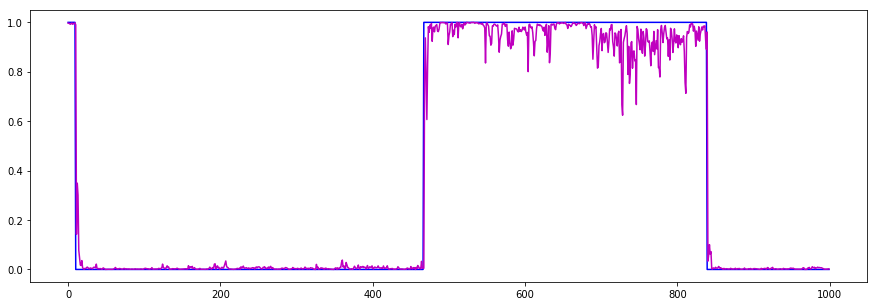

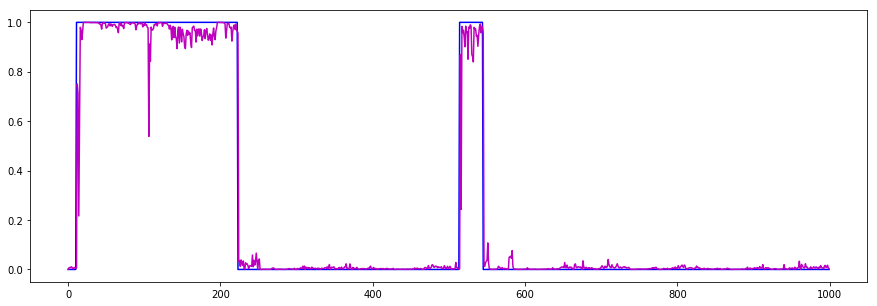

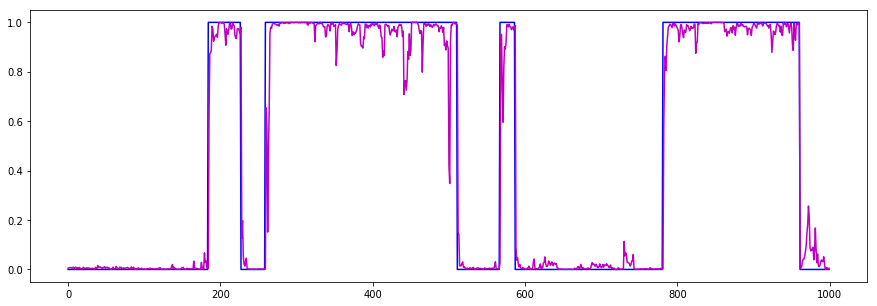

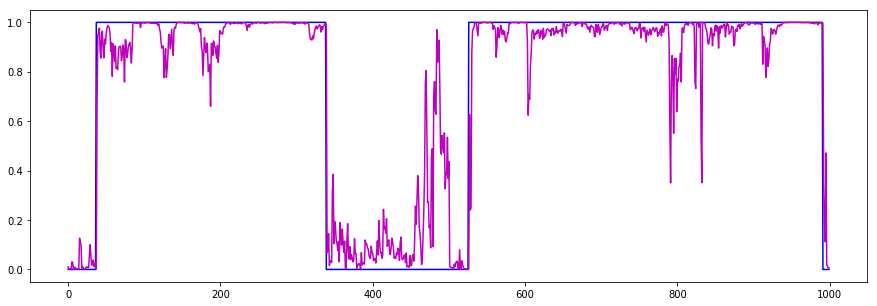

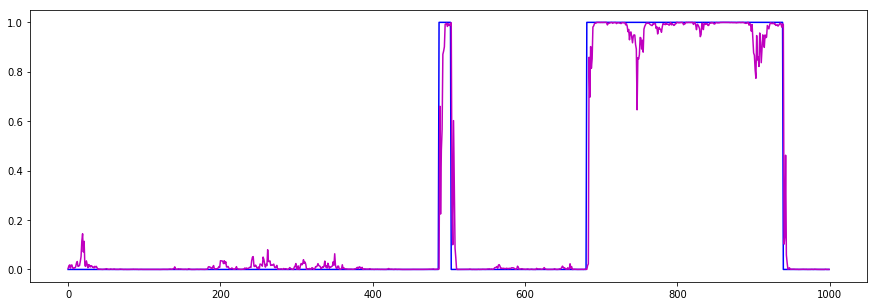

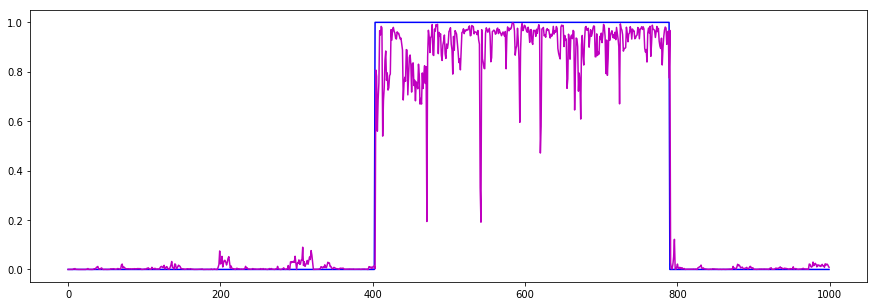

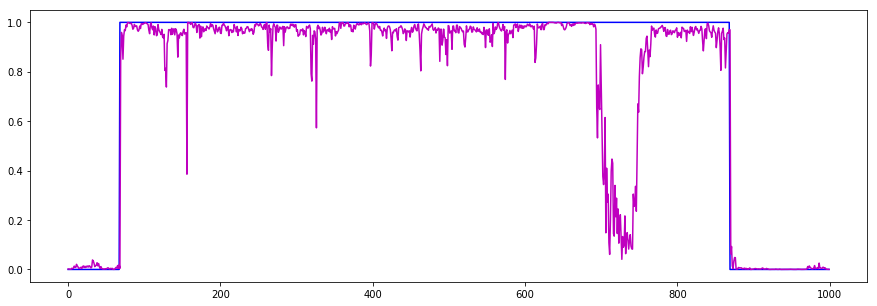

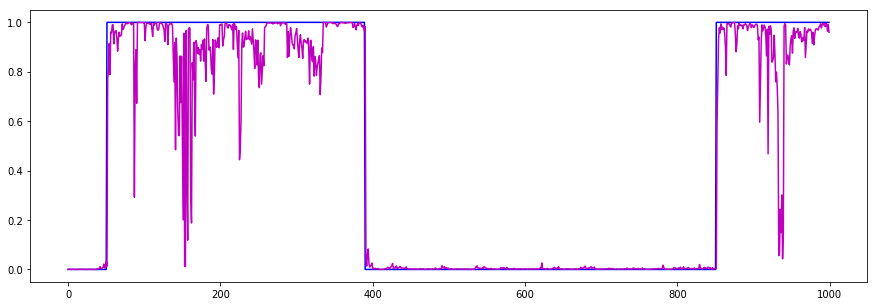

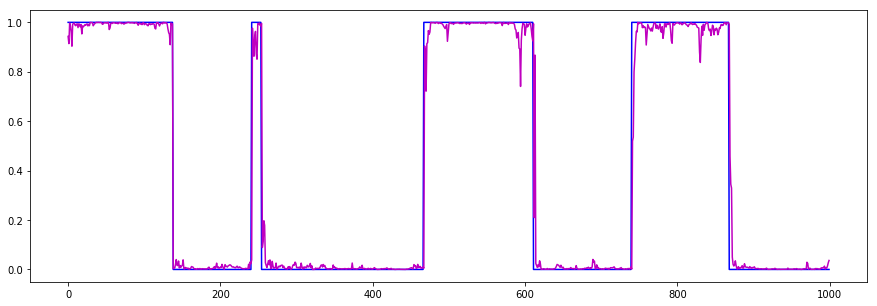

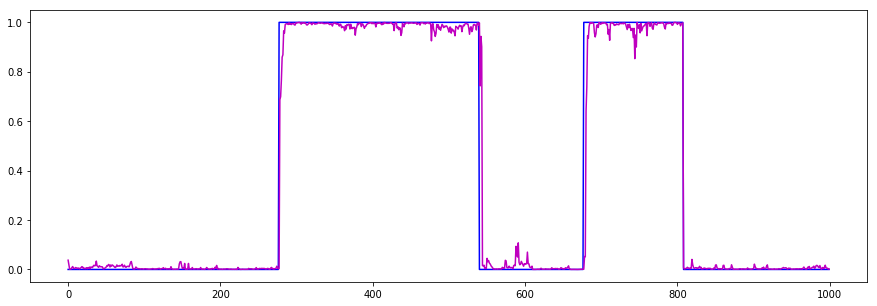

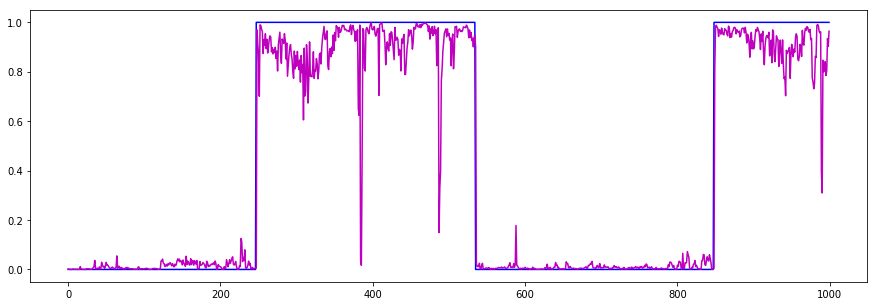

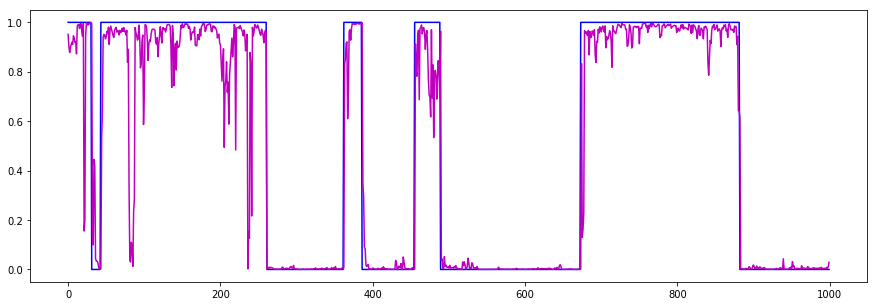

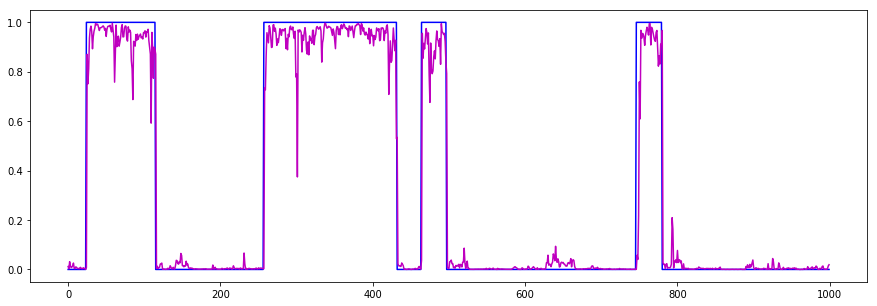

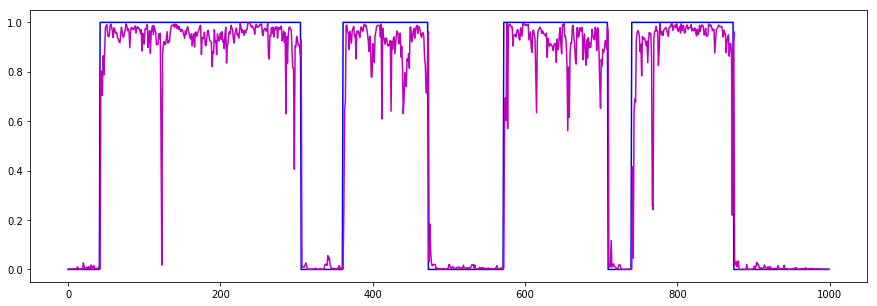

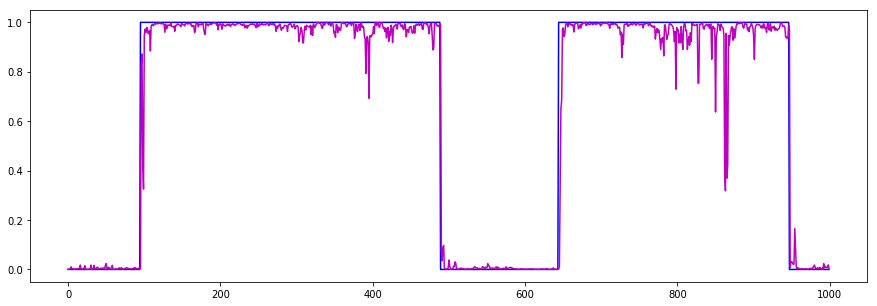

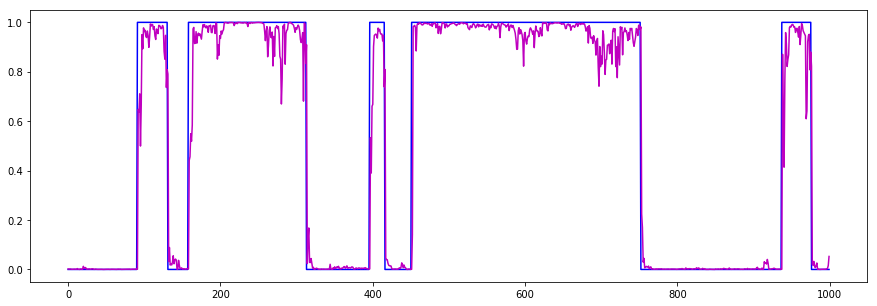

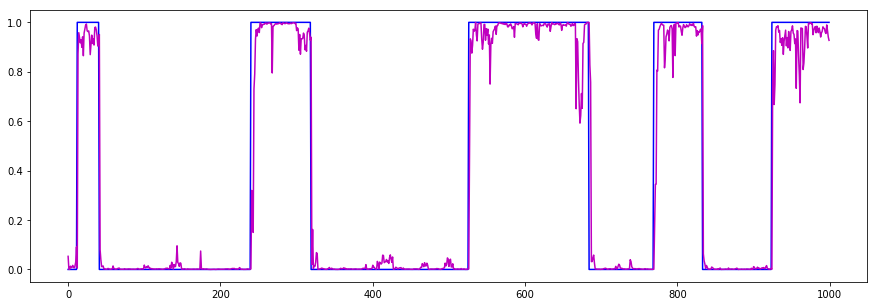

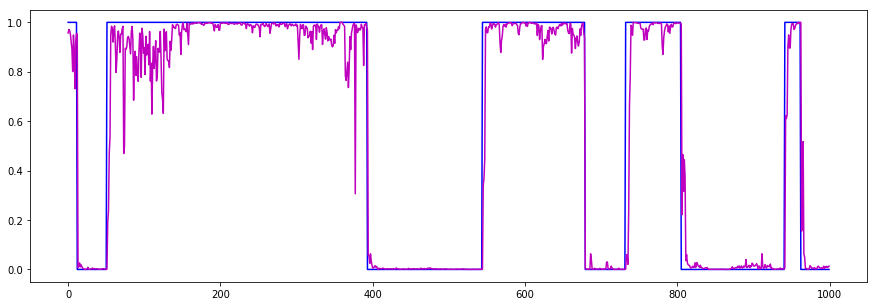

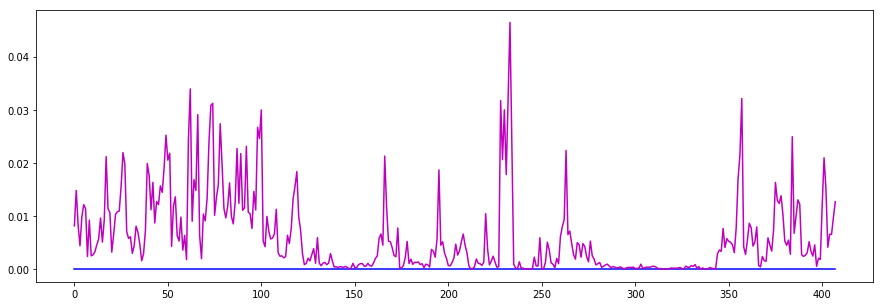

In [42]:
y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
for i in range(0,len(y),1000):
    plt.figure(figsize=(15,5))
    plt.plot(y[i:i+1000],color='b')
    plt.plot(y_pred1[0][i:i+1000],color='m')

In [43]:
from sklearn.metrics import accuracy_score,classification_report
label = [1 if i > 0.5 else 0 for i in y_pred]
label1 = [1 if i > 0.5 else 0 for i in y_pred1[0]]
print(accuracy_score(y,label))
print(classification_report(y,label))
print(accuracy_score(y,label1))
print(classification_report(y,label1))

0.7291642995114191
              precision    recall  f1-score   support

           0       0.67      0.95      0.79     36997
           1       0.90      0.49      0.63     33411

   micro avg       0.73      0.73      0.73     70408
   macro avg       0.78      0.72      0.71     70408
weighted avg       0.78      0.73      0.71     70408

0.9795761845244858
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     36997
           1       0.99      0.97      0.98     33411

   micro avg       0.98      0.98      0.98     70408
   macro avg       0.98      0.98      0.98     70408
weighted avg       0.98      0.98      0.98     70408



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from keras_model import *
import keras


def load_image(paths,gray_flag=0,timestep=10):
    #pathを受け取って画像を返す
    img_feature = []
    for path in paths:
        x = cv2.imread(path.replace('eye','face'), cv2.IMREAD_GRAYSCALE)
        if x is None:
            x = np.array([0]*96*96)
        x = x.reshape(96,96,1)
        img_feature.append(x / 255.0)
    return np.array([img_feature[i:i+timestep] for i in range(len(paths)-timestep)],dtype=np.float32)

def add_positive_label(y):
    y_after = [0]*len(y)
    y_after = y.copy()
    for i in range(len(y)):
        if y[i] != 1: continue
        for j in range(max(i-5,0),min(len(y),i+5)):
            y_after[j] = 1
    return y_after


import glob
import pandas as pd
import cv2
import numpy as np
if __name__ == '__main__':
    sp_files = sorted(glob.glob('/mnt/aoni02/katayama/dataset/DATA2019/sp/*csv'))
    feature_files = sorted(glob.glob('/mnt/aoni02/katayama/dataset/DATA2019/feature/*csv'))

    x_spA=x_spB=y1=y2=[]
    x_img=y3=[]
    x_target=y=[]
    timestep=10
    for sp_f,f in zip(sp_files[80:],feature_files[80:]):
        df = pd.read_csv(sp_f)
        x_spA = np.append(x_spA,[df.iloc[:,:256].values[i:i+timestep] for i in range(len(df)-timestep)],axis=0) if len(x_spA) != 0 else np.array([df.iloc[:-1,:256].values[i:i+timestep] for i in range(len(df)-timestep)])
        x_spB = np.append(x_spB,[df.iloc[:,256:].values[i:i+timestep] for i in range(len(df)-timestep)],axis=0) if len(x_spB) != 0 else np.array([df.iloc[:-1,256:].values[i:i+timestep] for i in range(len(df)-timestep)])
        #x_spA = np.append(x_spA,df.iloc[:-1,:256].values,axis=0) if len(x_spA) != 0 else df.iloc[:,:256].values[:-1]
        #x_spB = np.append(x_spB,df.iloc[:-1,256:].values,axis=0) if len(x_spB) != 0 else df.iloc[:,256:].values[:-1]
        length = len(df)
        df = pd.read_csv(f).iloc[:length,:]
        #print(len(df),length)
        #y1 = np.append(y1,df['utter_A'].values[:length-1]) if len(y1) != 0 else df['utter_A'].values[:length-1]
        #y2 = np.append(y2,df['utter_B'].values[:length-1]) if len(y2) != 0 else df['utter_B'].values[:length-1]
        #y3 = np.append(y3,df['gaze'].values[:length-1]) if len(y3) != 0 else df['gaze'].values[:length-1]
        y1 = np.append(y1,[df['utter_A'].values[i:i+timestep] for i in range(len(df)-timestep)],axis=0) if len(y1) != 0 else np.array([df['utter_A'].values[i:i+timestep] for i in range(len(df)-timestep)])
        y2 = np.append(y2,[df['utter_B'].values[i:i+timestep] for i in range(len(df)-timestep)],axis=0) if len(y2) != 0 else np.array([df['utter_B'].values[i:i+timestep] for i in range(len(df)-timestep)])
        y3 = np.append(y3,[df['gaze'].values[i:i+timestep] for i in range(len(df)-timestep)],axis=0) if len(y3) != 0 else np.array([df['gaze'].values[i:i+timestep] for i in range(len(df)-timestep)])
        x_img = np.append(x_img,load_image(df['path'].values),axis=0) if len(x_img) != 0 else load_image(df['path'].values)
        label = df['target'].map(lambda x:0 if x =='A' else 1).values
        #x_target = np.append(x_target,label[:length-1],axis=0) if len(x_target) != 0 else label[:length-1]
        x_target = np.append(x_target,[label[i:i+timestep] for i in range(len(label)-timestep)],axis=0) if len(x_target) != 0 else np.array([label[i:i+timestep] for i in range(len(label)-timestep)])
        label = df['action'].map(lambda x:1 if x =='Passive' else 0).values
        #label = add_positive_label(label)
        #y = np.append(y,label[1:length]) if len(y) != 0 else label[1:length]
        y = np.append(y,label[timestep:]) if len(y) != 0 else label[timestep:]
    
    x_target = x_target.reshape(-1,timestep,1)
    y1 = y1.reshape(-1,timestep,1)
    y2 = y2.reshape(-1,timestep,1)
    y3 = y3.reshape(-1,timestep,1)

    model = PassiveTrain(singletask=True)
    model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 10, 96, 96, 1 0                                            
__________________________________________________________________________________________________
time_distributed_50 (TimeDistri (None, 10, 92, 92, 3 832         input_21[0][0]                   
__________________________________________________________________________________________________
time_distributed_51 (TimeDistri (None, 10, 92, 92, 3 128         time_distributed_50[0][0]        
__________________________________________________________________________________________________
time_distributed_52 (TimeDistri (None, 10, 88, 88, 3 25632       time_distributed_51[0][0]        
__________________________________________________________________________________________________
time_distr

/home/katayama/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


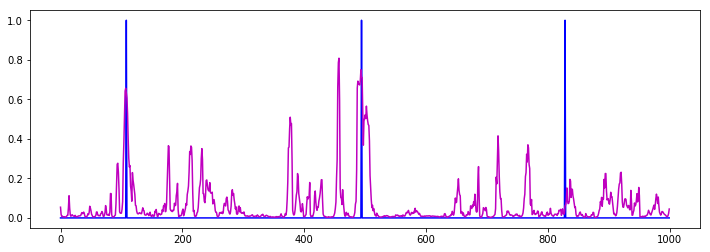

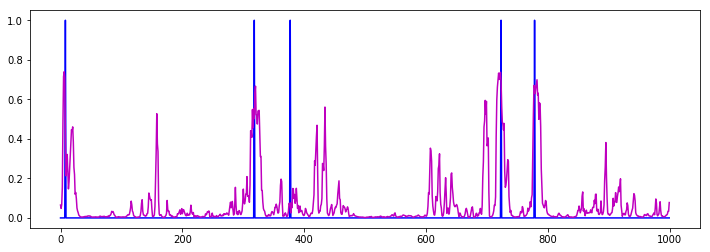

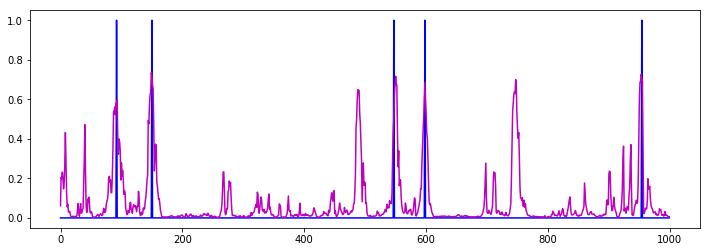

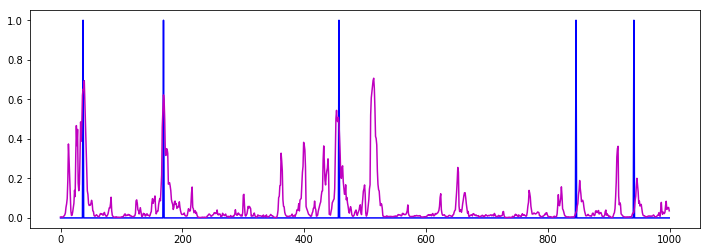

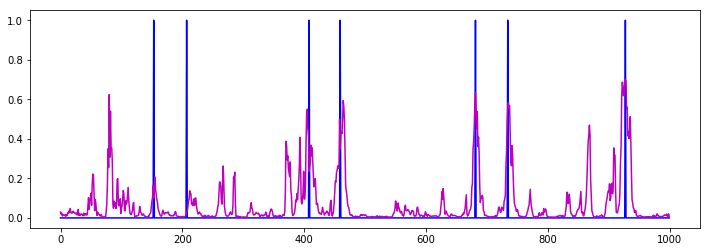

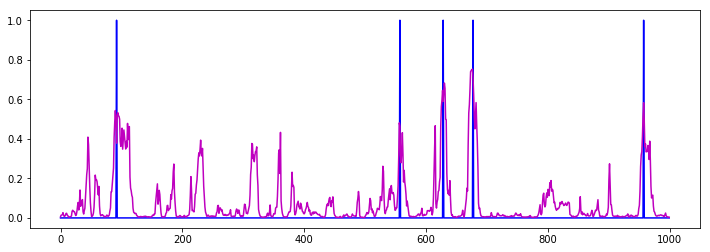

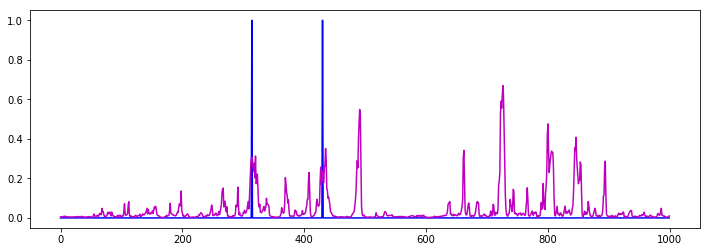

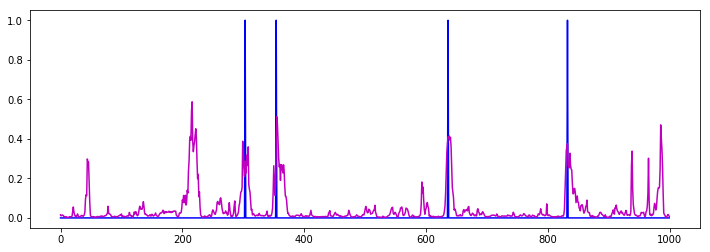

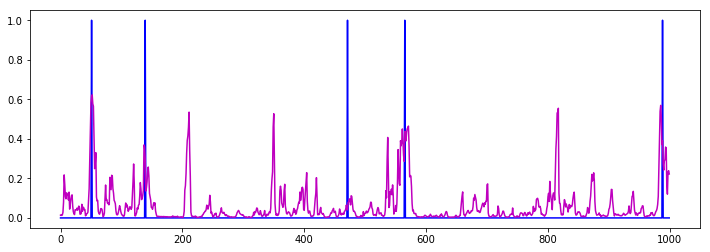

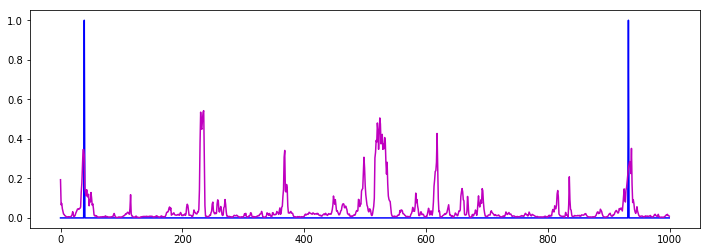

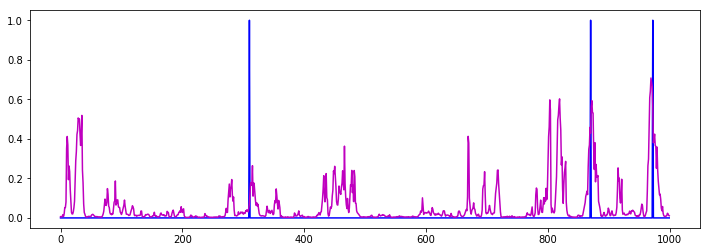

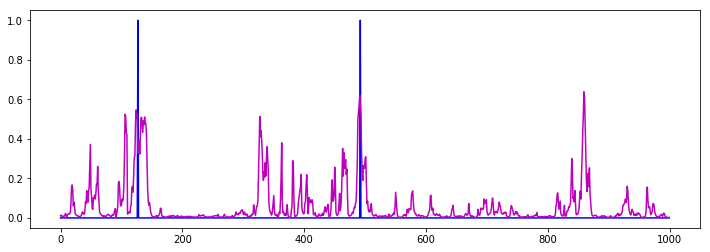

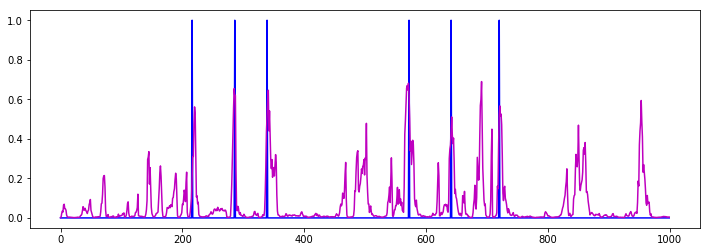

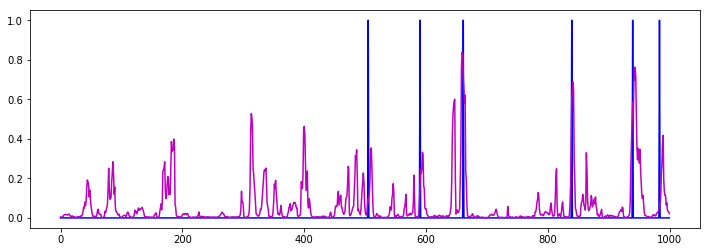

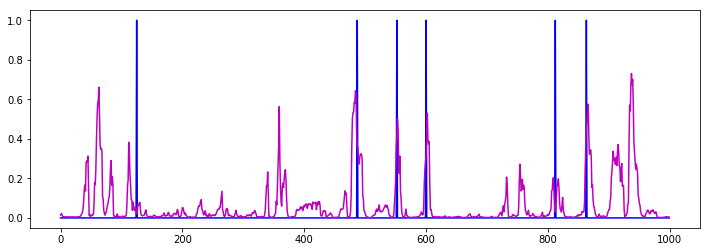

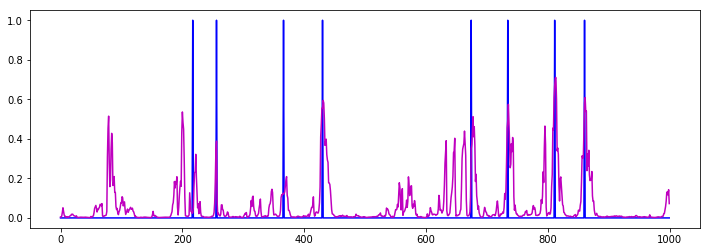

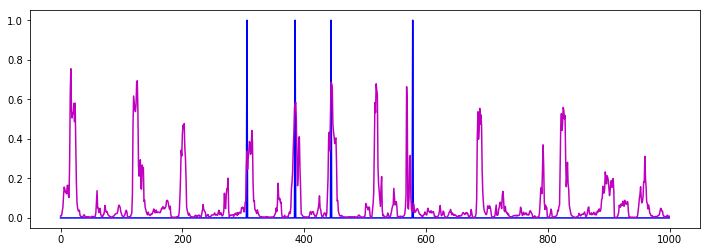

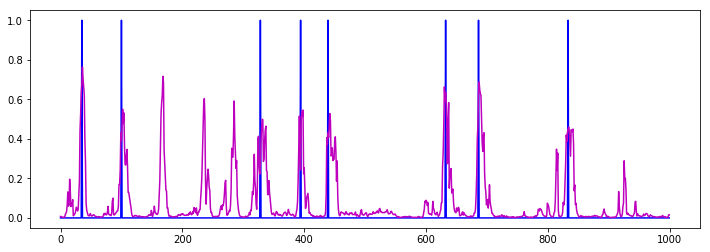

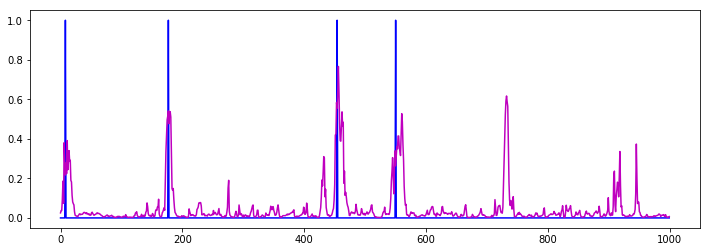

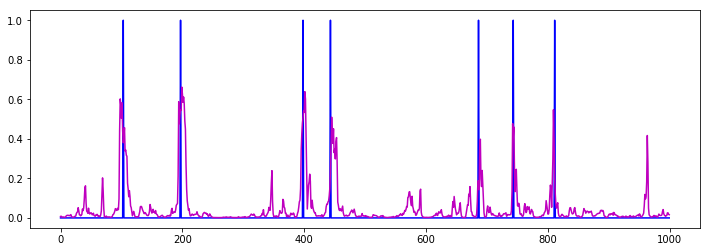

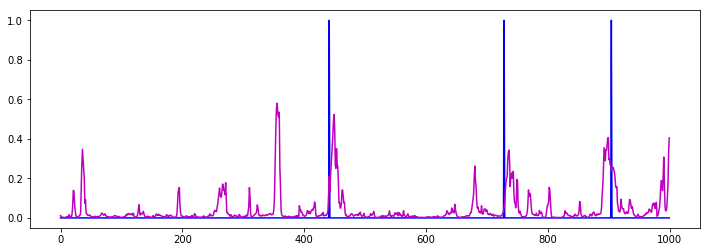

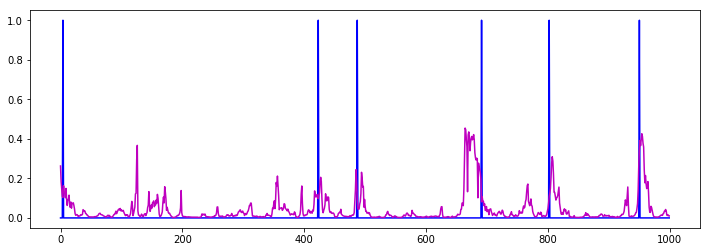

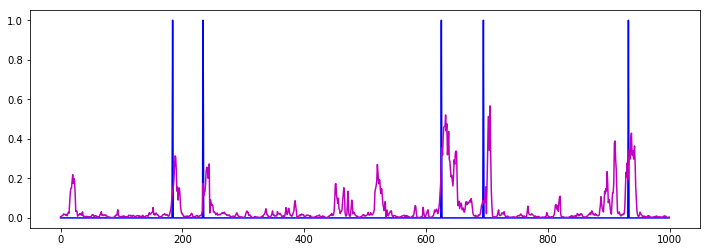

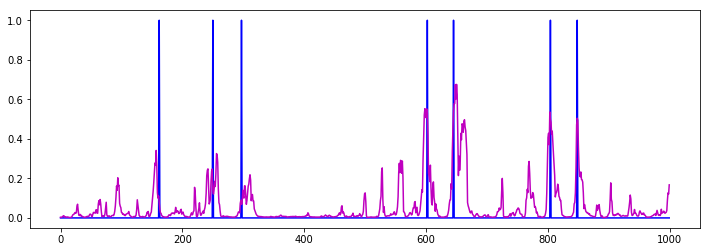

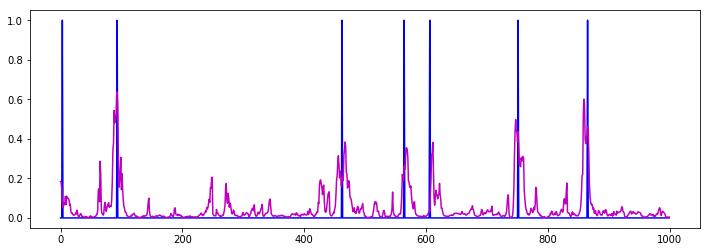

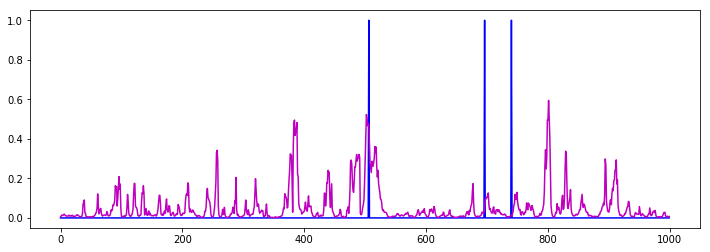

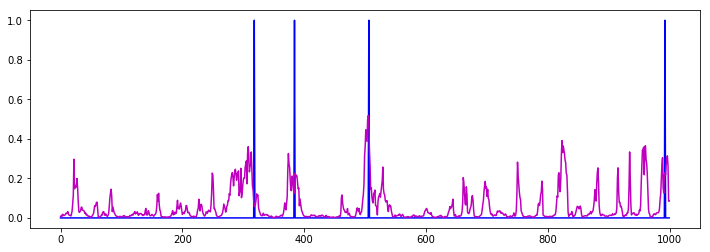

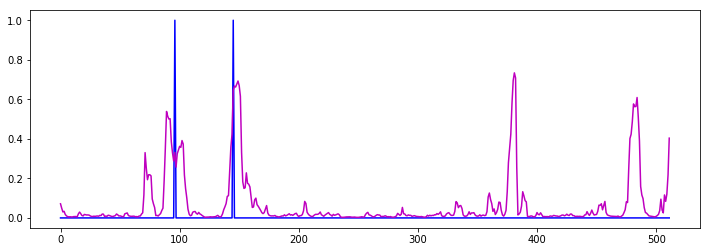

In [5]:
model.load_weights('../keras/result/passive_singletask/train13-53/weights.18-0.20.hdf5')

y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
for i in range(0,len(y),1000):
    plt.figure(figsize=(12,4))
    plt.plot(y[i:i+1000],color='b')
    plt.plot(y_pred1[i:i+1000],color='m')

In [3]:
model.load_weights('result/passive_equal/train13-53/weights.100-0.64.hdf5')
print(model.evaluate([x_spA,x_spB,x_img,x_target],[y,y1,y2,y3]))

7345/7345 [==============================] - 33s 4ms/step
[0.7210458934996873, 0.3819672919013534, 0.46013226535062224, 0.4754931809141005, 0.42068896435652564, 0.8345813478678566, 0.7906739281179793, 0.7715724991161536, 0.8704424774508804]


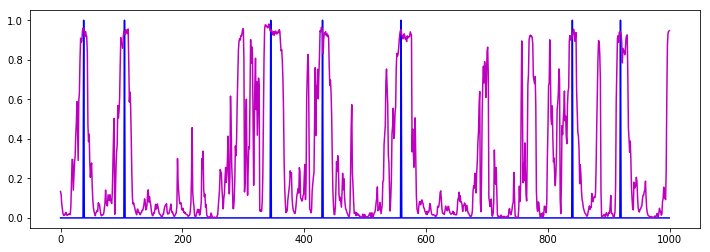

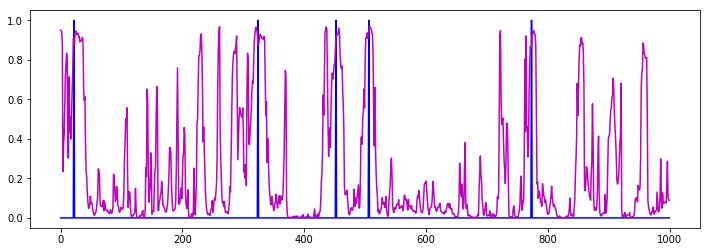

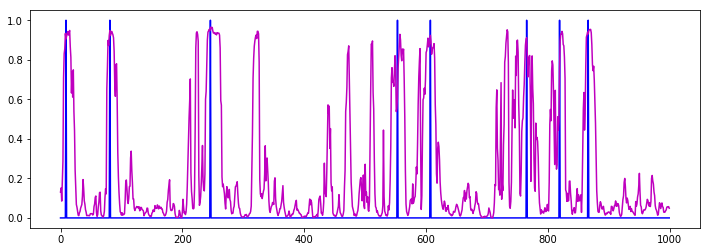

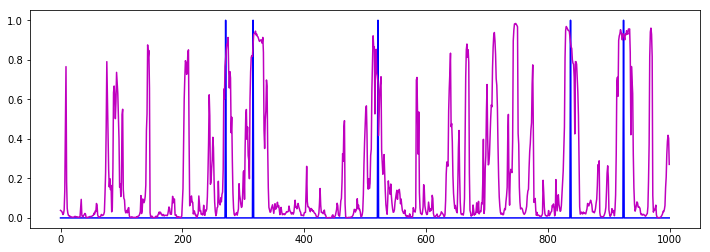

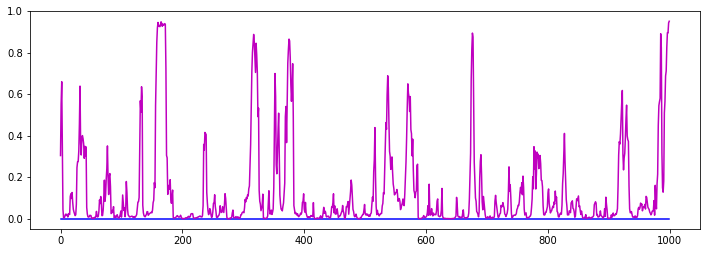

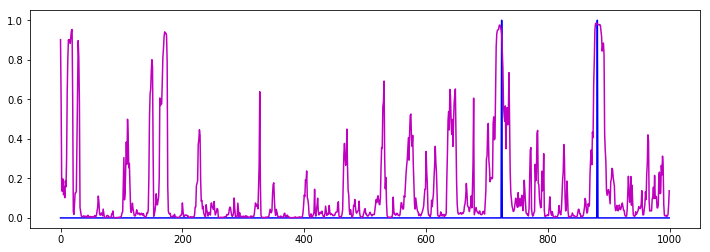

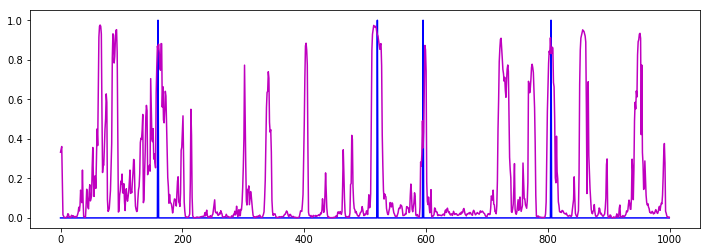

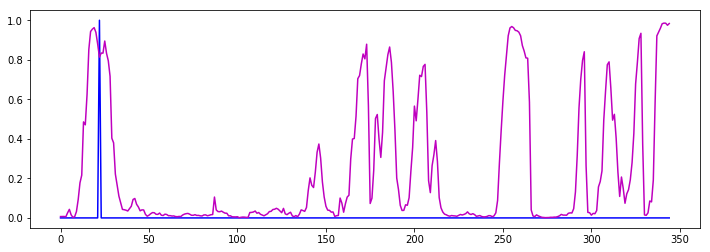

In [4]:
y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
for i in range(0,len(y),1000):
    plt.figure(figsize=(12,4))
    plt.plot(y[i:i+1000],color='b')
    plt.plot(y_pred1[0][i:i+1000],color='m')

# 評価

In [20]:
def filetering(y,N=30):
    """
    行動生成したら，N秒間行動しない処理
    """
    y_aft = np.copy(y)
    for i in range(len(y)):
        if y[i] < 0.5: 
            y_aft[i] = 0
        else:
            
            for j in range(i+1,min(i+N,len(y))):
                y_aft[j] = 0
    return y_aft

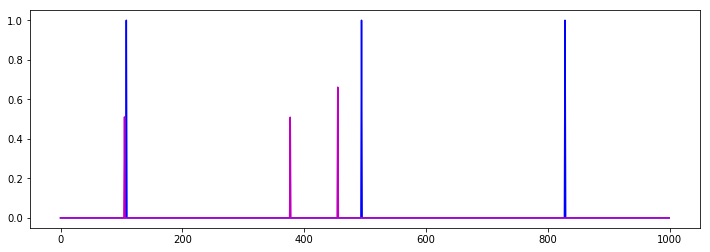

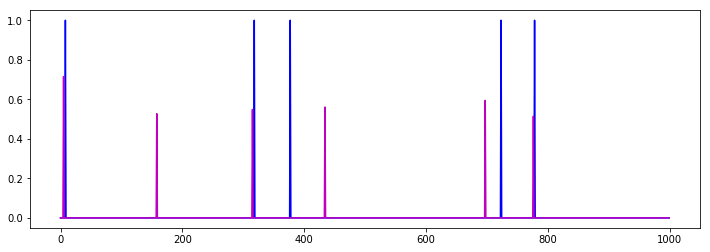

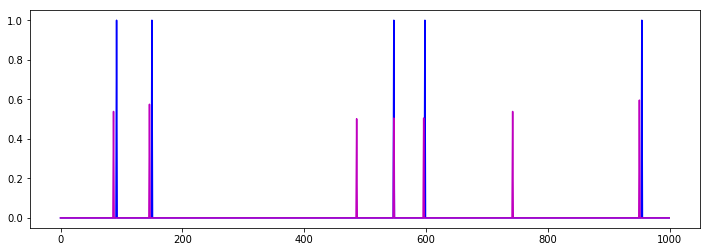

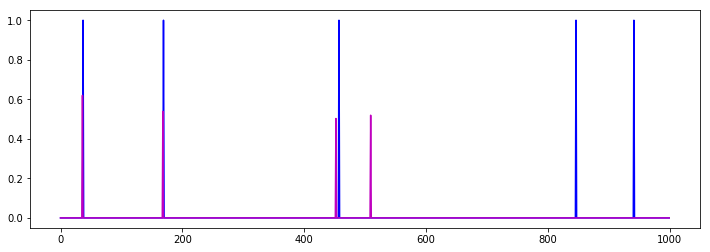

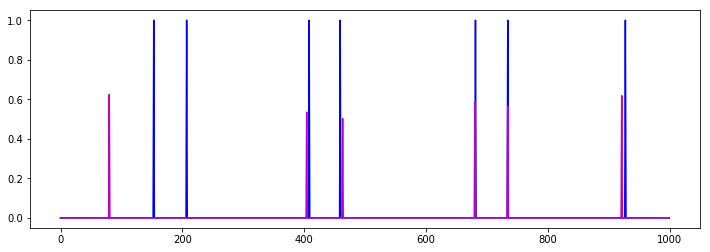

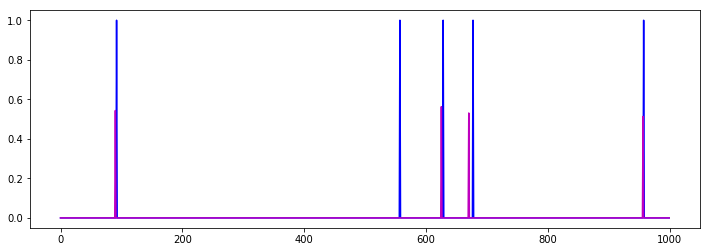

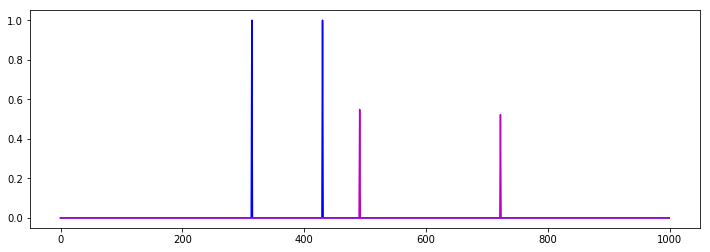

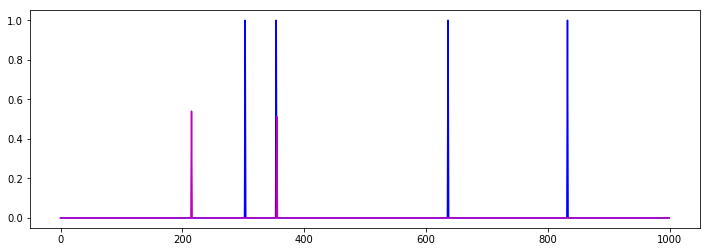

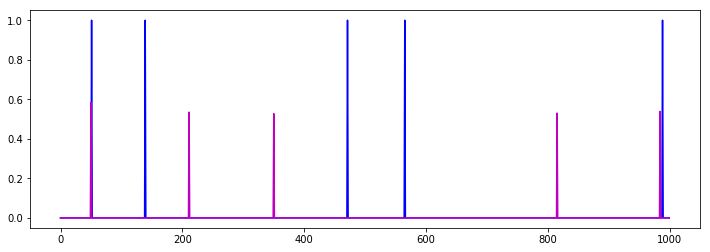

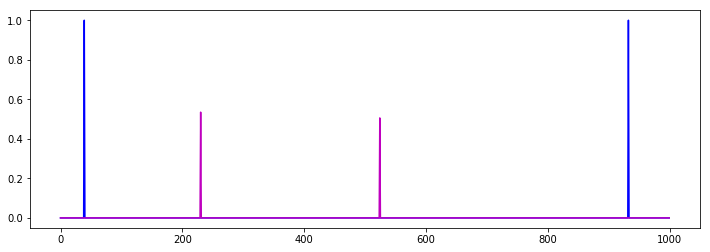

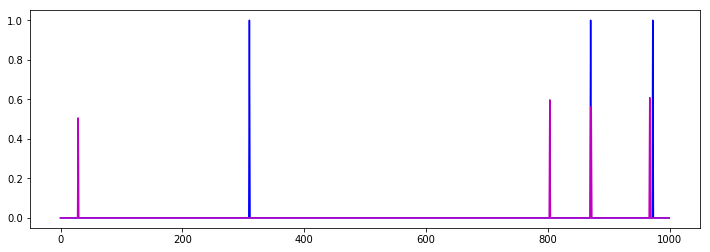

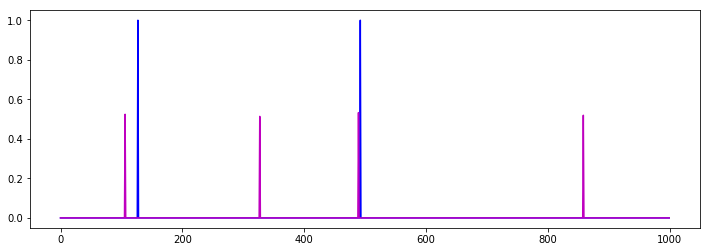

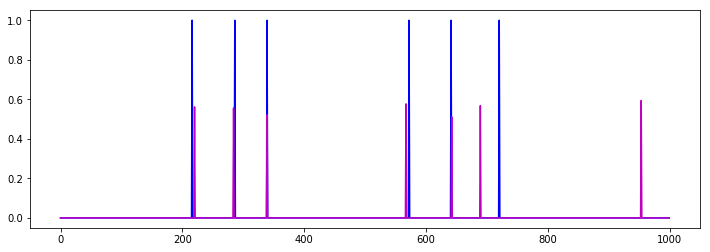

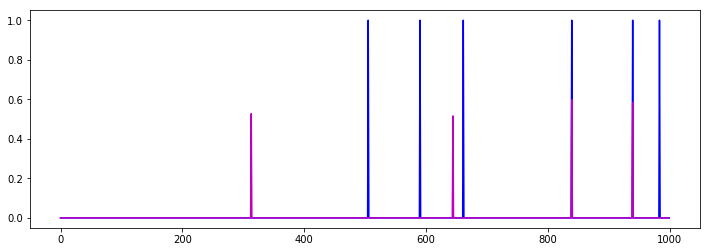

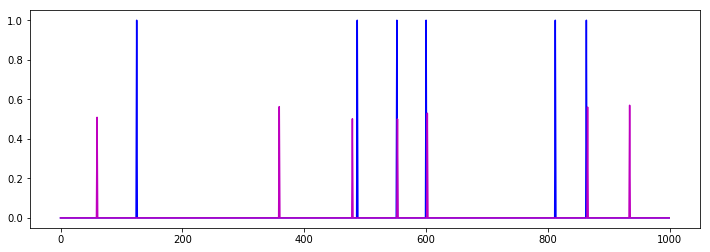

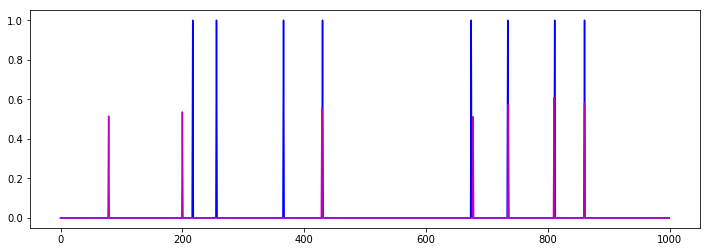

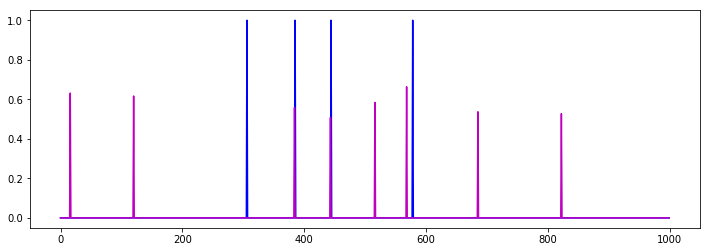

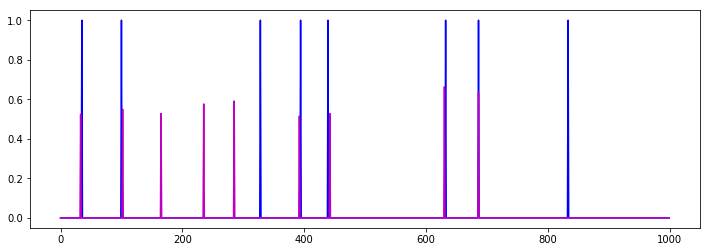

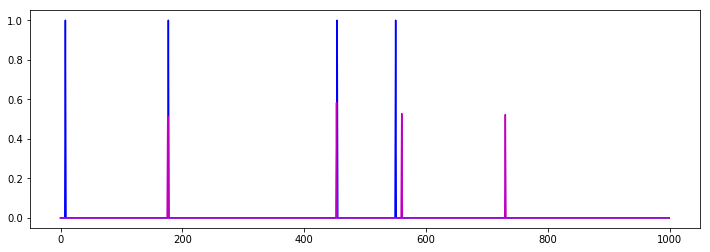

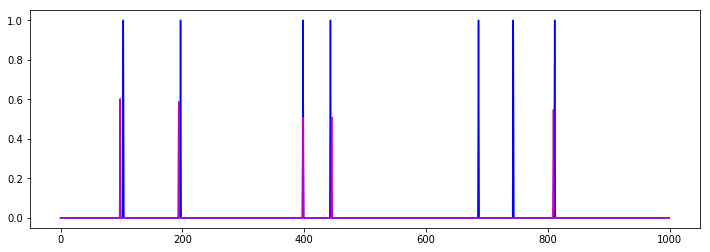

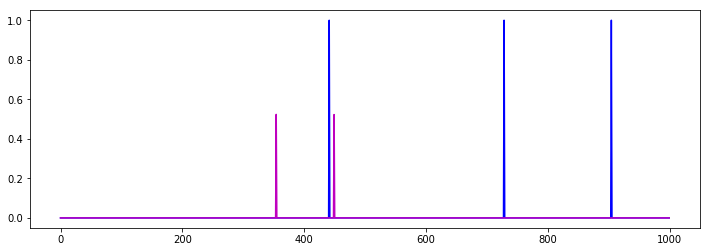

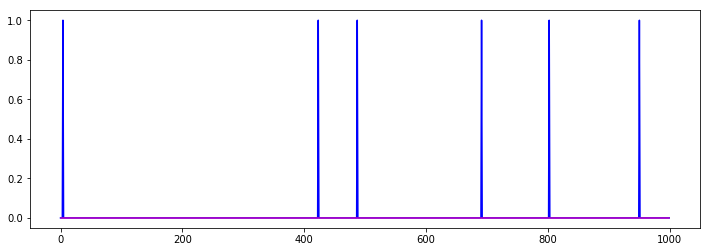

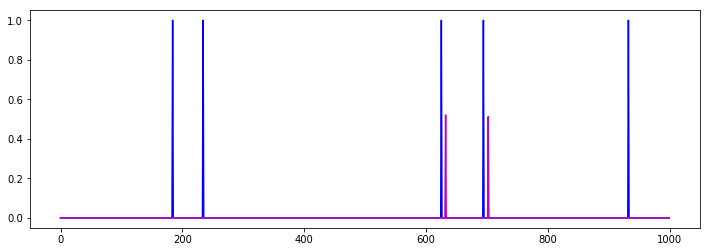

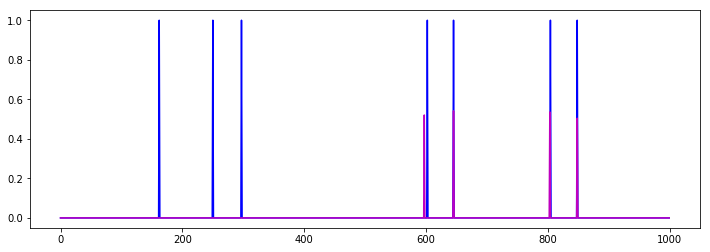

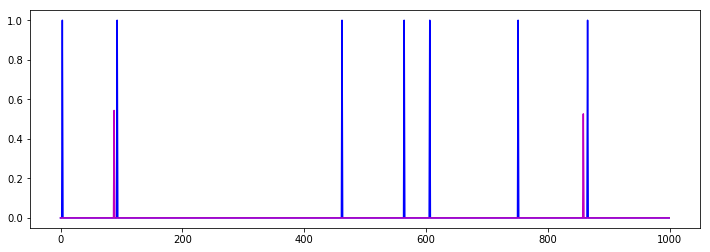

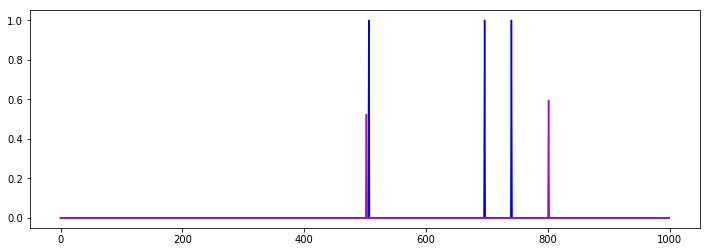

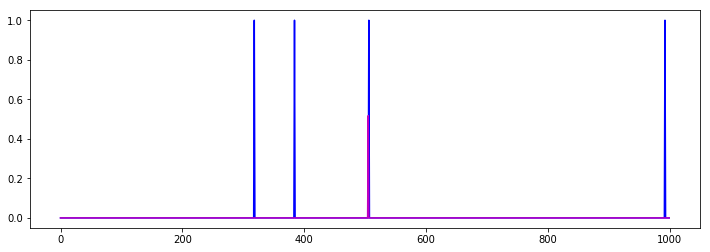

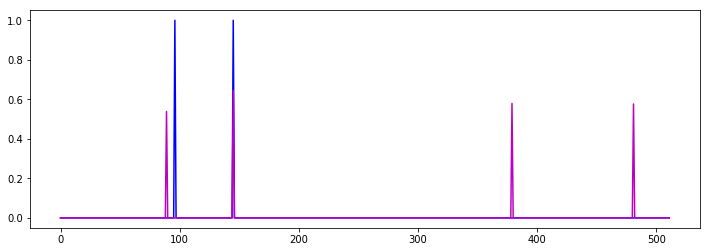

In [21]:
#y_aft1 = filetering(np.reshape(y_pred1[0],(-1,)))
y_aft1 = filetering(y_pred1)
for i in range(0,len(y),1000):
    plt.figure(figsize=(12,4))
    plt.plot(y[i:i+1000],color='b')
    plt.plot(y_aft1[i:i+1000],color='m')

In [22]:
def report_recall_and_precision(y,y_pred,windowsize=5):
    correct = 0
    negative_correct = 0
    for i in range(len(y)):
        if y_pred[i] == 0: continue
        if 1 in y[i-windowsize:i+windowsize]:
            correct += 1
        
    
    precision = correct / np.sum(y_pred>0)
    recall = correct / np.sum(y)
    print(correct)
    print('precision:',precision,'recall:',recall)

print('length',len(y_aft1))
print('positive',np.sum(y_aft1>0))
print('negative',np.sum(y_aft1==0))
report_recall_and_precision(y,y_aft1,windowsize=20)

length 27512
positive 117
negative 27395
75
precision: 0.6410256410256411 recall: 0.5597014925373134


In [16]:
y_aft1.shape

(27512, 1)

In [24]:
PATH_list = sorted(glob.glob('../keras/result/passive_singletask/train13-53/weights*'))
for PATH in PATH_list:
    model.load_weights(PATH)
    y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
    y_aft1 = filetering(np.reshape(y_pred1,(-1,)))
    
    print(PATH)
    report_recall_and_precision(y,y_aft1,windowsize=20)
    print()

../keras/result/passive_singletask/train13-53/weights.01-0.54.hdf5
42
precision: 0.21105527638190955 recall: 0.31343283582089554

../keras/result/passive_singletask/train13-53/weights.02-0.51.hdf5
36
precision: 0.18652849740932642 recall: 0.26865671641791045

../keras/result/passive_singletask/train13-53/weights.03-0.41.hdf5
44
precision: 0.22564102564102564 recall: 0.3283582089552239

../keras/result/passive_singletask/train13-53/weights.04-0.33.hdf5
65
precision: 0.3051643192488263 recall: 0.48507462686567165

../keras/result/passive_singletask/train13-53/weights.05-0.30.hdf5
64
precision: 0.3137254901960784 recall: 0.47761194029850745

../keras/result/passive_singletask/train13-53/weights.06-0.30.hdf5
60
precision: 0.2912621359223301 recall: 0.44776119402985076

../keras/result/passive_singletask/train13-53/weights.07-0.25.hdf5
85
precision: 0.3601694915254237 recall: 0.6343283582089553

../keras/result/passive_singletask/train13-53/weights.08-0.25.hdf5
79
precision: 0.3333333333333

../keras/result/passive_singletask/train13-53/weights.65-0.19.hdf5
91
precision: 0.6066666666666667 recall: 0.6791044776119403

../keras/result/passive_singletask/train13-53/weights.66-0.19.hdf5
91
precision: 0.5723270440251572 recall: 0.6791044776119403

../keras/result/passive_singletask/train13-53/weights.67-0.19.hdf5
89
precision: 0.5973154362416108 recall: 0.664179104477612

../keras/result/passive_singletask/train13-53/weights.68-0.20.hdf5
92
precision: 0.5714285714285714 recall: 0.6865671641791045

../keras/result/passive_singletask/train13-53/weights.69-0.20.hdf5
84
precision: 0.5793103448275863 recall: 0.6268656716417911

../keras/result/passive_singletask/train13-53/weights.70-0.19.hdf5
83
precision: 0.6014492753623188 recall: 0.6194029850746269

../keras/result/passive_singletask/train13-53/weights.71-0.19.hdf5
92
precision: 0.6013071895424836 recall: 0.6865671641791045

../keras/result/passive_singletask/train13-53/weights.72-0.20.hdf5
88
precision: 0.5789473684210527 recal

In [9]:
PATH_list = sorted(glob.glob('../keras/result/passive_equal/train13-53/weights*'))
for PATH in PATH_list:
    model.load_weights(PATH)
    y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
    y_aft1 = filetering(np.reshape(y_pred1[0],(-1,)))
    
    print(PATH)
    report_recall_and_precision(y,y_aft1,windowsize=10)
    print()

../keras/result/passive_equal/train13-53/weights.01-1.31.hdf5
precision: 0.06474666530987416 recall: 0.03125

../keras/result/passive_equal/train13-53/weights.02-1.29.hdf5
precision: 0.0653392919777951 recall: 0.03125

../keras/result/passive_equal/train13-53/weights.03-1.24.hdf5
precision: 0.06423638550750846 recall: 0.03125

../keras/result/passive_equal/train13-53/weights.04-1.21.hdf5
precision: 0.06011425754096904 recall: 0.03125

../keras/result/passive_equal/train13-53/weights.05-1.21.hdf5
precision: 0.05735614606011801 recall: 0.03125

../keras/result/passive_equal/train13-53/weights.06-1.17.hdf5
precision: 0.10937263356053933 recall: 0.0625

../keras/result/passive_equal/train13-53/weights.07-1.12.hdf5
precision: 0.10309792462254244 recall: 0.0625

../keras/result/passive_equal/train13-53/weights.08-1.05.hdf5
precision: 0.1543544526081534 recall: 0.09375

../keras/result/passive_equal/train13-53/weights.09-0.99.hdf5
precision: 0.17383367055892138 recall: 0.125

../keras/result/

../keras/result/passive_equal/train13-53/weights.16-0.82.hdf5
precision: 0.11338099351098997 recall: 0.09375

../keras/result/passive_equal/train13-53/weights.160-0.58.hdf5
precision: 0.14195107092977868 recall: 0.1875

../keras/result/passive_equal/train13-53/weights.161-0.58.hdf5
precision: 0.14388082234862712 recall: 0.1875

../keras/result/passive_equal/train13-53/weights.162-0.58.hdf5
precision: 0.14657196038170528 recall: 0.1875

../keras/result/passive_equal/train13-53/weights.163-0.58.hdf5
precision: 0.13882327874920797 recall: 0.1875

../keras/result/passive_equal/train13-53/weights.164-0.58.hdf5
precision: 0.11976794230173532 recall: 0.15625

../keras/result/passive_equal/train13-53/weights.165-0.58.hdf5
precision: 0.11809674595134906 recall: 0.15625

../keras/result/passive_equal/train13-53/weights.166-0.58.hdf5
precision: 0.12101571509160289 recall: 0.15625

../keras/result/passive_equal/train13-53/weights.167-0.58.hdf5
precision: 0.11154822695747683 recall: 0.15625

../ker

../keras/result/passive_equal/train13-53/weights.41-0.71.hdf5
precision: 0.16207189689975918 recall: 0.1875

../keras/result/passive_equal/train13-53/weights.42-0.71.hdf5
precision: 0.22031423382894239 recall: 0.28125

../keras/result/passive_equal/train13-53/weights.43-0.71.hdf5
precision: 0.22390802302537235 recall: 0.28125

../keras/result/passive_equal/train13-53/weights.44-0.70.hdf5
precision: 0.21179626776783317 recall: 0.25

../keras/result/passive_equal/train13-53/weights.45-0.71.hdf5
precision: 0.21467388040552712 recall: 0.28125

../keras/result/passive_equal/train13-53/weights.46-0.71.hdf5
precision: 0.19002083281988236 recall: 0.25

../keras/result/passive_equal/train13-53/weights.47-0.70.hdf5
precision: 0.22772081128318813 recall: 0.28125

../keras/result/passive_equal/train13-53/weights.48-0.70.hdf5
precision: 0.15598179942596116 recall: 0.1875

../keras/result/passive_equal/train13-53/weights.49-0.70.hdf5
precision: 0.2071475645084054 recall: 0.25

../keras/result/passiv

In [27]:
PATH_list = sorted(glob.glob('../keras/result/passive/train13-83/weights*'))
for PATH in PATH_list:
    model.load_weights(PATH)
    y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
    y_aft1 = filetering(np.reshape(y_pred1[0],(-1,)))
    
    print(PATH)
    report_recall_and_precision(y,y_aft1,windowsize=10)
    print()

../keras/result/passive/train13-83/weights.01-1.40.hdf5
precision: 0.0861912375598639 recall: 0.06481481481481481

../keras/result/passive/train13-83/weights.02-1.30.hdf5
precision: 0.11376703311353928 recall: 0.09259259259259259

../keras/result/passive/train13-83/weights.03-1.22.hdf5
precision: 0.19050096760573718 recall: 0.16666666666666666

../keras/result/passive/train13-83/weights.04-1.17.hdf5
precision: 0.1724079393147922 recall: 0.1574074074074074

../keras/result/passive/train13-83/weights.05-1.12.hdf5
precision: 0.2662745714046614 recall: 0.28703703703703703

../keras/result/passive/train13-83/weights.06-1.07.hdf5
precision: 0.3009510339221998 recall: 0.3333333333333333

../keras/result/passive/train13-83/weights.07-1.04.hdf5
precision: 0.3446268618220709 recall: 0.3888888888888889

../keras/result/passive/train13-83/weights.08-1.04.hdf5
precision: 0.35449851328271226 recall: 0.39814814814814814

../keras/result/passive/train13-83/weights.09-1.03.hdf5
precision: 0.41047842886

In [28]:
PATH_list = sorted(glob.glob('../keras/result/passive/train13-83/weights*'))
for PATH in PATH_list:
    model.load_weights(PATH)
    y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
    y_aft1 = filetering(np.reshape(y_pred1[0],(-1,)))
    
    print(PATH)
    report_recall_and_precision(y,y_aft1,windowsize=20)
    print()

../keras/result/passive/train13-83/weights.01-1.40.hdf5
precision: 0.14775640724548098 recall: 0.1111111111111111

../keras/result/passive/train13-83/weights.02-1.30.hdf5
precision: 0.2047806596043707 recall: 0.16666666666666666

../keras/result/passive/train13-83/weights.03-1.22.hdf5
precision: 0.2540012901409829 recall: 0.2222222222222222

../keras/result/passive/train13-83/weights.04-1.17.hdf5
precision: 0.24339944373853017 recall: 0.2222222222222222

../keras/result/passive/train13-83/weights.05-1.12.hdf5
precision: 0.3521695944384231 recall: 0.37962962962962965

../keras/result/passive/train13-83/weights.06-1.07.hdf5
precision: 0.38454854334503313 recall: 0.42592592592592593

../keras/result/passive/train13-83/weights.07-1.04.hdf5
precision: 0.43488627801356566 recall: 0.49074074074074076

../keras/result/passive/train13-83/weights.08-1.04.hdf5
precision: 0.4369400279996221 recall: 0.49074074074074076

../keras/result/passive/train13-83/weights.09-1.03.hdf5
precision: 0.4748672020

In [29]:
PATH_list = sorted(glob.glob('../keras/result/passive/train13-83/weights*'))
for PATH in PATH_list:
    model.load_weights(PATH)
    y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
    y_aft1 = filetering(np.reshape(y_pred1[0],(-1,)))
    
    print(PATH)
    report_recall_and_precision(y,y_aft1,windowsize=30)
    print()

../keras/result/passive/train13-83/weights.01-1.40.hdf5
precision: 0.25857371267959167 recall: 0.19444444444444445

../keras/result/passive/train13-83/weights.02-1.30.hdf5
precision: 0.31854769271791 recall: 0.25925925925925924

../keras/result/passive/train13-83/weights.03-1.22.hdf5
precision: 0.3598351610330591 recall: 0.3148148148148148

../keras/result/passive/train13-83/weights.04-1.17.hdf5
precision: 0.30424930467316275 recall: 0.2777777777777778

../keras/result/passive/train13-83/weights.05-1.12.hdf5
precision: 0.42947511516880865 recall: 0.46296296296296297

../keras/result/passive/train13-83/weights.06-1.07.hdf5
precision: 0.48486555465243303 recall: 0.5370370370370371

../keras/result/passive/train13-83/weights.07-1.04.hdf5
precision: 0.5579673000928767 recall: 0.6296296296296297

../keras/result/passive/train13-83/weights.08-1.04.hdf5
precision: 0.5523581486032959 recall: 0.6203703703703703

../keras/result/passive/train13-83/weights.09-1.03.hdf5
precision: 0.60364474833551

In [13]:
PATH_list = sorted(glob.glob('../keras/result/passive/train20-70/weights*'))
for PATH in PATH_list:
    model.load_weights(PATH)
    y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
    y_aft1 = filetering(np.reshape(y_pred1[0],(-1,)))
    
    print(PATH)
    report_recall_and_precision(y,y_aft1,windowsize=10)
    print()

../keras/result/passive/train20-70/weights.01-0.59.hdf5
precision: 0.7 recall: 0.07608695652173914

../keras/result/passive/train20-70/weights.02-0.52.hdf5
precision: 0.5952380952380952 recall: 0.5434782608695652

../keras/result/passive/train20-70/weights.03-0.50.hdf5
precision: 0.5537459283387622 recall: 0.6159420289855072

../keras/result/passive/train20-70/weights.04-0.49.hdf5
precision: 0.49834983498349833 recall: 0.5471014492753623

../keras/result/passive/train20-70/weights.05-0.48.hdf5
precision: 0.5016181229773463 recall: 0.5615942028985508

../keras/result/passive/train20-70/weights.06-0.49.hdf5
precision: 0.4733893557422969 recall: 0.6123188405797102

../keras/result/passive/train20-70/weights.07-0.49.hdf5
precision: 0.5 recall: 0.5688405797101449

../keras/result/passive/train20-70/weights.08-0.50.hdf5
precision: 0.446875 recall: 0.5181159420289855

../keras/result/passive/train20-70/weights.09-0.50.hdf5
precision: 0.4883720930232558 recall: 0.532608695652174

../keras/resu

In [15]:
PATH_list = sorted(glob.glob('../keras/result/passive/train30-91/weights*'))
for PATH in PATH_list:
    model.load_weights(PATH)
    y_pred1 = model.predict([x_spA,x_spB,x_img,x_target])
    y_aft1 = filetering(np.reshape(y_pred1[0],(-1,)))
    
    print(PATH)
    report_recall_and_precision(y,y_aft1,windowsize=10)
    print()

../keras/result/passive/train30-91/weights.01-0.66.hdf5
precision: 0.36304700162074555 recall: 0.5221445221445221

../keras/result/passive/train30-91/weights.02-0.55.hdf5
precision: 0.43781942078364566 recall: 0.5990675990675991

../keras/result/passive/train30-91/weights.03-0.54.hdf5
precision: 0.3665594855305466 recall: 0.5314685314685315

../keras/result/passive/train30-91/weights.04-0.55.hdf5
precision: 0.4 recall: 0.5641025641025641

../keras/result/passive/train30-91/weights.05-0.54.hdf5
precision: 0.35392320534223703 recall: 0.49417249417249415

../keras/result/passive/train30-91/weights.06-0.57.hdf5
precision: 0.29780564263322884 recall: 0.4428904428904429

../keras/result/passive/train30-91/weights.07-0.58.hdf5
precision: 0.33713355048859933 recall: 0.4825174825174825

../keras/result/passive/train30-91/weights.08-0.58.hdf5
precision: 0.3696027633851468 recall: 0.4988344988344988

../keras/result/passive/train30-91/weights.09-0.60.hdf5
precision: 0.3687821612349914 recall: 0.5

# 重み読み込めてるか確認

In [2]:
model = PassiveTrain()

In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 10, 32, 96, 1 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 10, 28, 92, 3 832         input_10[0][0]                   
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 10, 24, 88, 3 25632       time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 10, 12, 44, 3 0           time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distr

In [5]:
model.layers[-17].get_weights()

[array([[-0.00344626, -0.01252244,  0.10839153, ...,  0.0212588 ,
         -0.08083834,  0.07644197],
        [-0.01238323, -0.11571723,  0.04806567, ...,  0.0659442 ,
          0.05686282, -0.0219995 ],
        [ 0.00099913, -0.04836212,  0.10733746, ..., -0.02444947,
         -0.12454064,  0.04292509],
        ...,
        [ 0.00058112,  0.00013946,  0.04391918, ..., -0.12004384,
          0.0376644 ,  0.07698586],
        [-0.00172468,  0.04915415, -0.0364063 , ..., -0.02571552,
          0.00683716, -0.02973988],
        [-0.02619985, -0.03172692, -0.02244098, ..., -0.06483141,
          0.04792014, -0.02162909]], dtype=float32),
 array([[ 0.02477872, -0.07797981,  0.05316674, ..., -0.08421075,
         -0.01589485, -0.05270572],
        [ 0.06851848, -0.02010698, -0.03543571, ..., -0.03529118,
          0.09580345,  0.09589958],
        [-0.03579452,  0.01471849, -0.05048466, ..., -0.0213848 ,
          0.01438967, -0.11769105],
        ...,
        [ 0.02103314, -0.01040381,  0.0

In [4]:
# keras_model.py の gazemodel や utterance の重みを load しない
model.layers[-17].get_weights()

[array([[ 0.153003  , -0.06019743, -0.07511964, ..., -0.05937405,
          0.08130053, -0.11446514],
        [ 0.13212739, -0.04301031, -0.01250569, ..., -0.0098664 ,
          0.0341263 ,  0.04600578],
        [-0.00310881,  0.10524601, -0.13862677, ...,  0.05755749,
          0.15349753, -0.03677868],
        ...,
        [-0.09577104, -0.00929922,  0.01413272, ..., -0.00644941,
          0.0830127 , -0.06573811],
        [ 0.00937967,  0.01452481, -0.05157596, ..., -0.09991705,
         -0.02750784,  0.0939461 ],
        [ 0.05355312, -0.04383893,  0.04957148, ..., -0.06506207,
         -0.06352638,  0.04103419]], dtype=float32),
 array([[ 0.09219607,  0.08623427, -0.12823862, ...,  0.05851954,
          0.00371512, -0.01903746],
        [ 0.01874231, -0.10068908, -0.00220019, ..., -0.04521097,
         -0.05123134, -0.03928671],
        [ 0.02556273, -0.05869307,  0.04516213, ...,  0.08681616,
         -0.08363508,  0.1074949 ],
        ...,
        [ 0.00288024,  0.01447639,  0.0

# 評価結果の可視化

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../keras/passive_result.csv')
df_f = pd.read_csv('../keras/passive_lang_freeze_result.csv')
df_not_f = pd.read_csv('../keras/passive_lang_not_freeze_result.csv')

In [3]:
df

precision    recall        f1  \
0   0.431138  0.537313  0.478405   
1   0.520958  0.649254  0.578073   
2   0.551515  0.679104  0.608696   
3   0.592105  0.671642  0.629371   
4   0.611842  0.694030  0.650350   
5   0.625000  0.708955  0.664336   
6   0.664474  0.753731  0.706294   
7   0.677632  0.768657  0.720280   

                                               error  window  
0  2,3,3,1,2,2,2,3,2,2,2,-1,2,-3,2,0,1,4,2,1,4,3,...       5  
1  2,3,3,7,1,2,2,2,3,2,2,2,-1,2,-3,2,0,1,4,2,1,5,...      10  
2  3,6,-4,5,3,5,6,2,4,4,10,3,1,-4,5,3,3,6,4,14,14...      15  
3  5,6,10,5,16,8,6,7,2,4,5,5,2,-1,2,4,3,6,4,15,14...      20  
4  5,6,10,5,16,8,6,7,2,4,5,5,2,-1,2,4,3,6,4,15,14...      25  
5  5,6,10,5,16,8,6,7,2,4,5,25,5,2,-1,2,4,3,6,4,15...      30  
6  5,6,10,5,16,30,8,6,7,2,4,5,25,5,2,-1,2,4,3,6,4...      35  
7  5,6,10,5,16,30,8,6,7,2,4,5,25,5,-39,2,-1,35,2,...      40

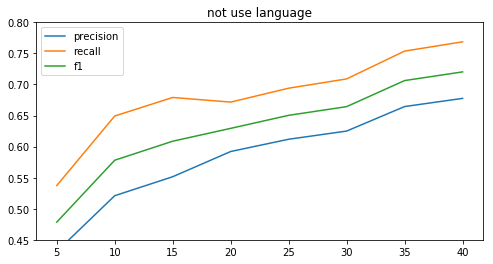

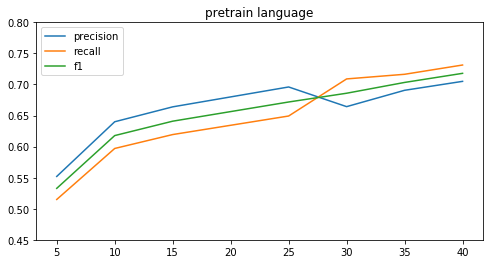

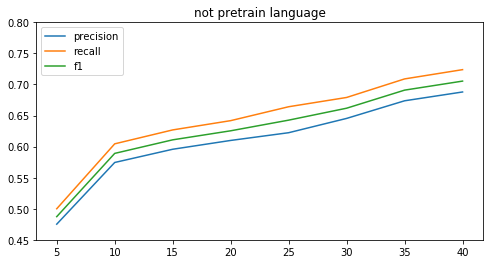

In [68]:
plt.figure(figsize=(8,4))
plt.title('not use language')
plt.plot(df['window'],df['precision'])
plt.plot(df['window'],df['recall'])
plt.plot(df['window'],df['f1'])
plt.ylim(0.45,0.8)
plt.legend()

plt.figure(figsize=(8,4))
plt.title('pretrain language')
plt.plot(df['window'],df_f['precision'])
plt.plot(df['window'],df_f['recall'])
plt.plot(df['window'],df_f['f1'])
plt.ylim(0.45,0.8)
plt.legend()

plt.figure(figsize=(8,4))
plt.title('not pretrain language')
plt.plot(df['window'],df_not_f['precision'])
plt.plot(df['window'],df_not_f['recall'])
plt.plot(df['window'],df_not_f['f1'])
plt.ylim(0.45,0.8)
plt.legend()

In [103]:
error = list(map(float,df['error'].values[-1].split(',')))

([array([  0.,   0.,   0.,   0., 134.,   0.,   0.,   0.,   0.,   0.]),
  array([ 7.,  4.,  8., 24., 53.,  5.,  0.,  0.,  1.,  1.])],
 array([-35. , -27.6, -20.2, -12.8,  -5.4,   2. ,   9.4,  16.8,  24.2,
         31.6,  39. ]),
 <a list of 2 Lists of Patches objects>)

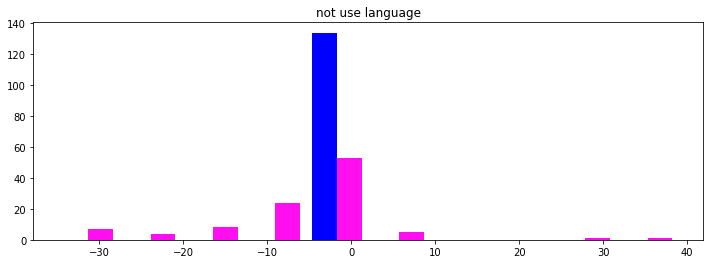

In [104]:
plt.figure(figsize=(12,4))
plt.title('not use language')
error = list(map(minus,error))
label = [0]*134
plt.hist([label,error],color=['b','#FF0FF0'])

In [101]:
error_f = list(map(float,df_f['error'].values[-1].split(',')))
error_not_f = list(map(float,df_not_f['error'].values[-1].split(',')))

In [98]:
def minus(a):
    return -a

([array([  0.,   0.,   0.,   0.,   0.,   0.,   0., 134.,   0.,   0.]),
  array([ 2.,  4.,  4.,  4.,  2.,  5., 33., 39.,  4.,  1.])],
 array([-39. , -33.8, -28.6, -23.4, -18.2, -13. ,  -7.8,  -2.6,   2.6,
          7.8,  13. ]),
 <a list of 2 Lists of Patches objects>)

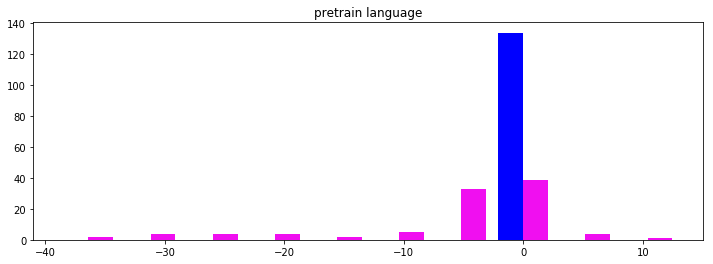

In [99]:
plt.figure(figsize=(12,4))
plt.title('pretrain language')
error_f = list(map(minus,error_f))
label = [0]*134
plt.hist([label,error_f],color=['b','#F00FF0'])

([array([  0.,   0.,   0.,   0., 134.,   0.,   0.,   0.,   0.,   0.]),
  array([ 5.,  4.,  3.,  6., 67., 11.,  0.,  0.,  0.,  1.])],
 array([-37. , -29.4, -21.8, -14.2,  -6.6,   1. ,   8.6,  16.2,  23.8,
         31.4,  39. ]),
 <a list of 2 Lists of Patches objects>)

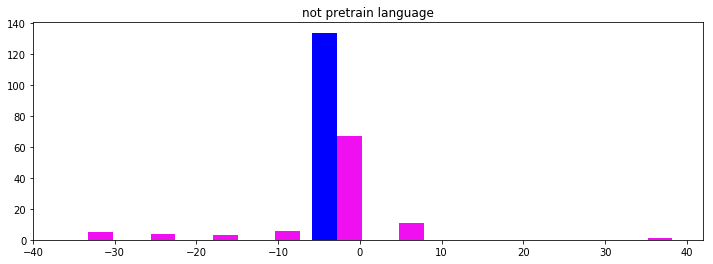

In [102]:
plt.figure(figsize=(12,4))
plt.title('not pretrain language')
error_not_f = list(map(minus,error_not_f))
label = [0]*134
plt.hist([label,error_not_f],color=['b','#F00FF0'])

In [60]:
error = list(map(float,df['error'].values[3].split(',')))
print(np.mean(error))
error = list(map(abs,error))
print(np.average(error))

5.066666666666666
5.488888888888889


In [61]:
error = list(map(float,df_f['error'].values[3].split(',')))
print(np.mean(error))
error = list(map(abs,error))
print(np.average(error))

2.623529411764706
3.2823529411764705


In [62]:
df_f

precision    recall        f1  \
0   0.552000  0.514925  0.532819   
1   0.640000  0.597015  0.617761   
2   0.664000  0.619403  0.640927   
3   0.680000  0.634328  0.656371   
4   0.696000  0.649254  0.671815   
5   0.664336  0.708955  0.685921   
6   0.690647  0.716418  0.703297   
7   0.705036  0.731343  0.717949   

                                               error  window  
0  2,4,1,4,4,1,4,3,-3,2,2,4,3,2,2,3,4,3,1,2,1,-4,...       5  
1  2,5,4,1,4,4,1,4,3,-3,6,2,2,4,3,2,2,5,5,5,3,4,3...      10  
2  2,5,4,1,4,4,1,4,3,-3,6,2,2,4,3,2,2,5,5,5,3,4,3...      15  
3  2,5,4,1,4,4,1,4,18,3,-3,6,2,2,4,3,2,2,5,5,5,3,...      20  
4  2,5,4,1,4,4,1,4,18,24,3,-3,6,2,2,4,3,2,2,5,5,5...      25  
5  2,5,4,-7,2,5,5,2,4,19,25,3,28,-2,6,2,3,16,3,2,...      30  
6  2,3,5,30,2,4,6,2,3,19,26,3,30,25,28,-4,-1,33,6...      35  
7  2,3,5,30,2,4,6,2,3,19,26,3,30,25,28,-4,-1,33,6...      40

In [63]:
df_not_f

precision    recall        f1  \
0   0.475177  0.500000  0.487273   
1   0.574468  0.604478  0.589091   
2   0.595745  0.626866  0.610909   
3   0.609929  0.641791  0.625455   
4   0.622378  0.664179  0.642599   
5   0.645390  0.679104  0.661818   
6   0.673759  0.708955  0.690909   
7   0.687943  0.723881  0.705455   

                                               error  window  
0  1,4,4,0,4,4,1,2,2,4,-1,4,2,4,2,1,2,4,4,2,3,1,2...       5  
1  1,5,4,4,6,0,4,4,1,2,2,4,-1,4,2,4,2,1,2,6,5,5,4...      10  
2  1,5,4,4,6,0,4,4,1,2,2,4,-1,4,2,4,2,1,2,6,5,5,4...      15  
3  1,5,4,4,6,0,4,4,1,2,2,4,-1,4,2,4,2,1,2,6,5,5,4...      20  
4  1,6,3,4,6,1,4,4,0,2,24,2,1,3,2,4,2,1,2,6,5,23,...      25  
5  1,5,4,4,6,0,4,4,1,2,25,2,25,28,4,-1,4,2,4,2,1,...      30  
6  1,5,4,4,6,0,4,4,1,2,32,25,2,25,28,4,-1,4,2,4,2...      35  
7  1,5,4,4,6,0,4,4,1,2,32,25,2,25,28,37,4,-1,4,2,...      40

In [64]:
error = list(map(float,df_not_f['error'].values[3].split(',')))
print(np.mean(error))
error = list(map(abs,error))
print(np.average(error))

2.953488372093023
3.488372093023256


In [70]:
import glob
files = sorted(glob.glob('/mnt/aoni02/katayama/dataset/DATA2019/feature/*'))
len(files)

91

In [71]:
cnt = 0
for i in range(80,91):
    f = pd.read_csv(files[i])
    cnt += np.sum(f['action'].map(lambda x:1 if x == 'Passive' else 0).values == 1)

In [72]:
cnt

134

In [105]:
df = pd.read_csv('../keras/evaluate/passive_lang_not_freeze_sp20_old_result.csv')

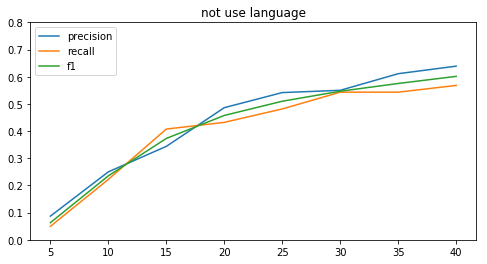

In [109]:
plt.figure(figsize=(8,4))
plt.title('not use language')
plt.plot(df['window'],df['precision'])
plt.plot(df['window'],df['recall'])
plt.plot(df['window'],df['f1'])
plt.ylim(0,0.8)
plt.legend()

In [116]:
df = pd.read_csv('../keras/evaluate/passive_lang_not_freeze_sp20_result.csv')

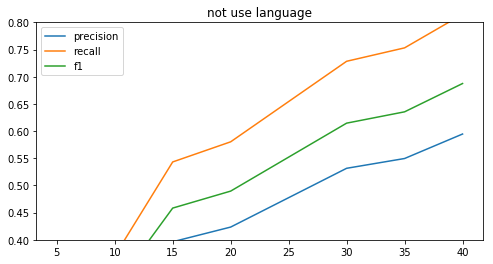

In [117]:
plt.figure(figsize=(8,4))
plt.title('not use language')
plt.plot(df['window'],df['precision'])
plt.plot(df['window'],df['recall'])
plt.plot(df['window'],df['f1'])
plt.ylim(0.4,0.8)
plt.legend()

In [118]:
df

precision    recall        f1  \
0   0.142857  0.185185  0.161290   
1   0.270270  0.370370  0.312500   
2   0.396396  0.543210  0.458333   
3   0.423423  0.580247  0.489583   
4   0.477477  0.654321  0.552083   
5   0.531532  0.728395  0.614583   
6   0.549550  0.753086  0.635417   
7   0.594595  0.814815  0.687500   

                                               error  window  
0              -4,-5,-3,1,-1,3,-3,3,-1,2,-3,3,1,-5,3       5  
1  6,8,-7,-7,-4,1,7,-5,-2,1,4,7,-10,6,7,3,-1,4,2,...      10  
2  6,8,13,10,14,-7,-12,-11,11,-7,-4,1,7,11,-5,-2,...      15  
3  6,8,13,10,14,-7,-12,-11,19,11,-7,-4,1,17,7,11,...      20  
4  6,8,13,10,14,-24,-7,-12,22,-11,19,11,-7,-4,1,1...      25  
5  6,8,13,10,14,-24,29,-7,-12,22,-11,26,19,11,-7,...      30  
6  6,8,13,10,14,30,-24,29,-7,-12,22,-11,26,19,11,...      35  
7  6,8,13,10,36,-37,30,-24,29,-7,-12,22,-11,26,19...      40

In [121]:
df = pd.read_csv('../keras/evaluate/passive_lang_freeze_sp20_result.csv')

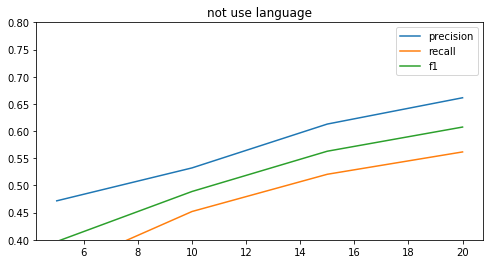

In [122]:
plt.figure(figsize=(8,4))
plt.title('not use language')
plt.plot(df['window'],df['precision'])
plt.plot(df['window'],df['recall'])
plt.plot(df['window'],df['f1'])
plt.ylim(0.4,0.8)
plt.legend()

In [124]:
df = pd.read_csv('../keras/evaluate/passive_lang_freeze_sp20_result1.csv')

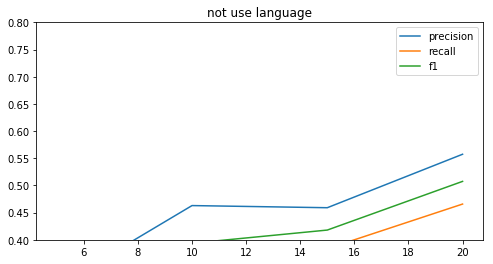

In [125]:
plt.figure(figsize=(8,4))
plt.title('not use language')
plt.plot(df['window'],df['precision'])
plt.plot(df['window'],df['recall'])
plt.plot(df['window'],df['f1'])
plt.ylim(0.4,0.8)
plt.legend()

In [2]:
df = pd.read_csv('../keras/evaluate/passive_lang_not_freeze_sp20_result2.csv')

In [3]:
df

precision    recall        f1  \
0   0.250000  0.235294  0.242424   
1   0.343750  0.323529  0.333333   
2   0.388889  0.411765  0.400000   
3   0.416667  0.441176  0.428571   

                                               error  window  
0              -1,3,-1,4,4,1,0,-2,1,1,3,1,-1,-1,3,-4       5  
1  -1,2,4,1,9,5,-9,0,0,-2,-6,1,5,5,-5,4,-7,-1,-2,...      10  
2  -1,2,4,13,13,1,-12,5,-9,-5,-13,-2,-6,1,7,5,2,-...      15  
3  -1,2,-19,4,13,13,1,-12,5,-9,-5,-13,-2,-6,1,7,5...      20

# 予測結果の可視化

In [5]:
from keras_model import *
import keras

Using TensorFlow backend.
/home/katayama/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
def load_image(paths,gray_flag=0,timestep=10):
    #pathを受け取って画像を返す
    img_feature = []
    for path in paths:
        x = cv2.imread(path.replace('eye','face'), cv2.IMREAD_GRAYSCALE)
        if x is None:
            x = np.array([0]*96*96)
        x = x.reshape(96,96,1)
        img_feature.append(x / 255.0)
    return np.array([img_feature[i:i+timestep] for i in range(len(paths)-timestep)],dtype=np.float32)

def add_positive_label(y):
    y_after = [0]*len(y)
    y_after = y.copy()
    for i in range(len(y)):
        if y[i] != 1: continue
        for j in range(max(i-5,0),min(len(y),i+5)):
            y_after[j] = 1
    return y_after

def filetering(y,N=30):
    """
    行動生成したら，N秒間行動しない処理
    """
    y_aft = np.copy(y)
    for i in range(len(y)):
        if y[i] < 0.5: 
            y_aft[i] = 0
        else:
            for j in range(i+1,min(i+N,len(y))):
                y_aft[j] = 0
    return y_aft

def report_recall_and_precision(y,y_pred,windowsize=5):
    correct = 0
    negative_correct = 0
    Error = []
    for i in range(len(y)):
        if y_pred[i] == 0: continue
        if 1 in y[i-windowsize:i+windowsize]:
            correct += 1
            error_dist = np.where(y[i-windowsize:i+windowsize]==1)[0][0] - windowsize
            Error.append(error_dist)
    precision = correct / np.sum(y_pred>0) if y_pred.sum() != 0 else 0
    recall = correct / np.sum(y==1)
    
    #print('precision:',precision,'recall:',recall)
    return precision,recall,Error
    
import glob
import pandas as pd
import cv2
import numpy as np
from collections import Counter
if __name__ == '__main__':
    sp_files = sorted(glob.glob('/mnt/aoni02/katayama/dataset/DATA2019/sp/*csv'))
    feature_files = sorted(glob.glob('/mnt/aoni02/katayama/dataset/DATA2019/feature/*csv'))
    lang_files = sorted(glob.glob('/mnt/aoni02/katayama/dataset/DATA2019/decode_new/*csv'))
    x_spA=x_spB=y1=y2=[]
    x_img=y3=[]
    X=X_pre=X_pre_id=X_id=[]
    x_target=y=[]
    timestep=10
    sp_step = 2
    for sp_f,f,lf in zip(sp_files[83:],feature_files[83:],lang_files[80:]):
        df = pd.read_csv(sp_f)
        df = df[:len(df)//sp_step*sp_step]
        x_spA = np.append(x_spA,[df.iloc[:,:256].values[i:i+sp_step*timestep] for i in range(0,len(df)-sp_step*timestep,sp_step)],axis=0) if len(x_spA) != 0 else np.array([df.iloc[:,:256].values[i:i+sp_step*timestep] for i in range(0,len(df)-sp_step*timestep,sp_step)])
        x_spB = np.append(x_spB,[df.iloc[:,256:].values[i:i+sp_step*timestep] for i in range(0,len(df)-sp_step*timestep,sp_step)],axis=0) if len(x_spB) != 0 else np.array([df.iloc[:,256:].values[i:i+sp_step*timestep] for i in range(0,len(df)-sp_step*timestep,sp_step)])
        
        length = len(df) // sp_step
        df = pd.read_csv(f).iloc[:length,:]
        
        #y1 = np.append(y1,df['utter_A'].values[:length-1]) if len(y1) != 0 else df['utter_A'].values[:length-1]
        #y2 = np.append(y2,df['utter_B'].values[:length-1]) if len(y2) != 0 else df['utter_B'].values[:length-1]
        #y3 = np.append(y3,df['gaze'].values[:length-1]) if len(y3) != 0 else df['gaze'].values[:length-1]
        y1 = np.append(y1,[df['utter_A'].values[i:i+timestep] for i in range(len(df)-timestep)],axis=0) if len(y1) != 0 else np.array([df['utter_A'].values[i:i+timestep] for i in range(len(df)-timestep)])
        y2 = np.append(y2,[df['utter_B'].values[i:i+timestep] for i in range(len(df)-timestep)],axis=0) if len(y2) != 0 else np.array([df['utter_B'].values[i:i+timestep] for i in range(len(df)-timestep)])
        y3 = np.append(y3,[df['gaze'].values[i:i+timestep] for i in range(len(df)-timestep)],axis=0) if len(y3) != 0 else np.array([df['gaze'].values[i:i+timestep] for i in range(len(df)-timestep)])
        x_img = np.append(x_img,load_image(df['path'].values),axis=0) if len(x_img) != 0 else load_image(df['path'].values)
        label = df['target'].map(lambda x:0 if x =='A' else 1).values
        
        x_target = np.append(x_target,[label[i:i+timestep] for i in range(len(label)-timestep)],axis=0) if len(x_target) != 0 else np.array([label[i:i+timestep] for i in range(len(label)-timestep)])
        label = df['action'].map(lambda x:1 if x =='Passive' else 2 if 'Continue' in x else 0).values
        label = add_positive_label(label)
        
        y = np.append(y,label[timestep:]) if len(y) != 0 else label[timestep:]
        """
        df = pd.read_csv(lf)[:length]
        X_pre = np.append(X_pre,[df['pre_content'].values[i+timestep-1] for i in range(len(df)-timestep)],axis=0) \
                if len(X_pre) != 0 else np.array([df['pre_content'].values[i+timestep-1] for i in range(len(df)-timestep)])
        X = np.append(X,[df['content'].values[i+timestep-1] for i in range(len(df)-timestep)],axis=0) \
                if len(X) != 0 else np.array([df['content'].values[i+timestep-1] for i in range(len(df)-timestep)])
        X_id = np.append(X_id,[df['ID'].values[i+timestep-1] for i in range(len(df)-timestep)],axis=0) \
                if len(X_id) != 0 else np.array([df['ID'].values[i+timestep-1] for i in range(len(df)-timestep)])
        X_pre_id = np.append(X_pre_id,[df['pre_ID'].values[i+timestep-1] for i in range(len(df)-timestep)],axis=0) \
                if len(X_pre_id) != 0 else np.array([df['pre_ID'].values[i+timestep-1] for i in range(len(df)-timestep)])"""
        
    #feature = np.array([word2id(w.split()) for w in wakati(X)])
    #feature_pre = np.array([word2id(w.split()) for w in wakati(X_pre)])
    x_spA = x_spA.reshape(-1,10,2,256)
    x_spB = x_spB.reshape(-1,10,2,256)
    x_target = x_target.reshape(-1,timestep,1)
    #y = y.reshape(-1,1)
    y1 = y1.reshape(-1,timestep,1)
    y2 = y2.reshape(-1,timestep,1)
    y3 = y3.reshape(-1,timestep,1)
    index = np.where(y!=2)[0]
    print(Counter(y[index]))
    model = PassiveTrain()
    #model = ActiveTrain()
    model.summary()

Counter({0: 7174, 1: 804})
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 10, 96, 96, 1 0                                            
__________________________________________________________________________________________________
time_distributed_19 (TimeDistri (None, 10, 92, 92, 3 832         input_16[0][0]                   
__________________________________________________________________________________________________
time_distributed_20 (TimeDistri (None, 10, 92, 92, 3 128         time_distributed_19[0][0]        
__________________________________________________________________________________________________
time_distributed_21 (TimeDistri (None, 10, 88, 88, 3 25632       time_distributed_20[0][0]        
__________________________________________________________________________________

In [9]:
PATH_list = sorted(glob.glob('result/passive_sp20/train13-83/weights*'))
for PATH in PATH_list[10:11]:
    model.load_weights(PATH)
    y_pred1 = model.predict([x_spA[index],x_spB[index],x_img[index],x_target[index]])

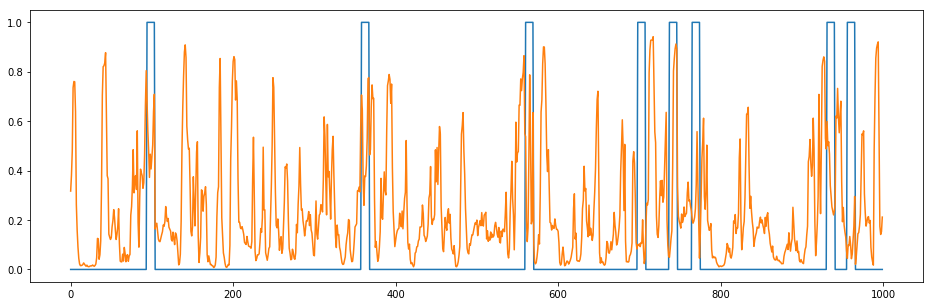

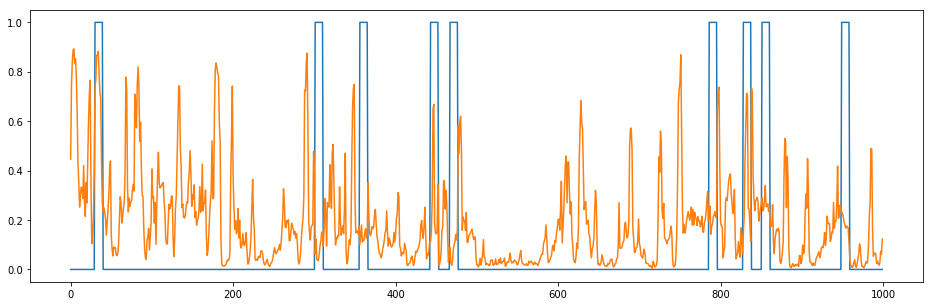

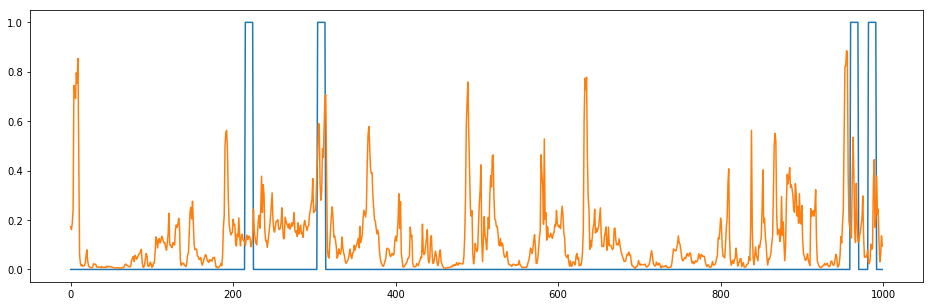

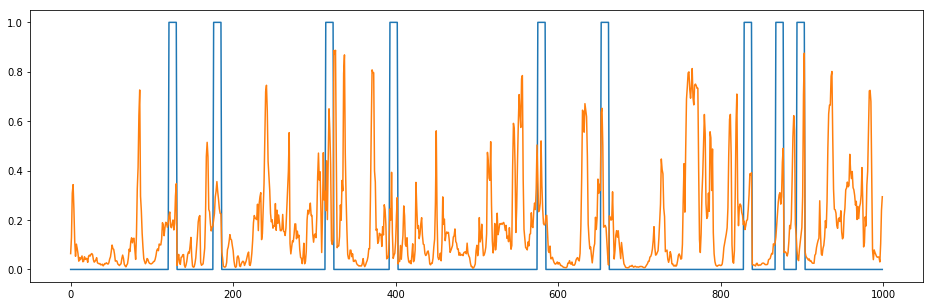

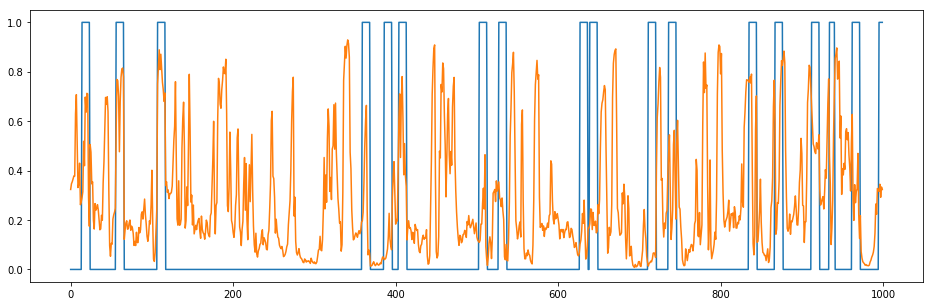

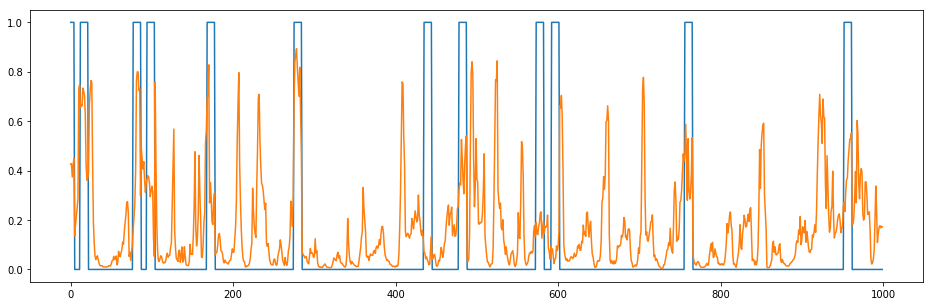

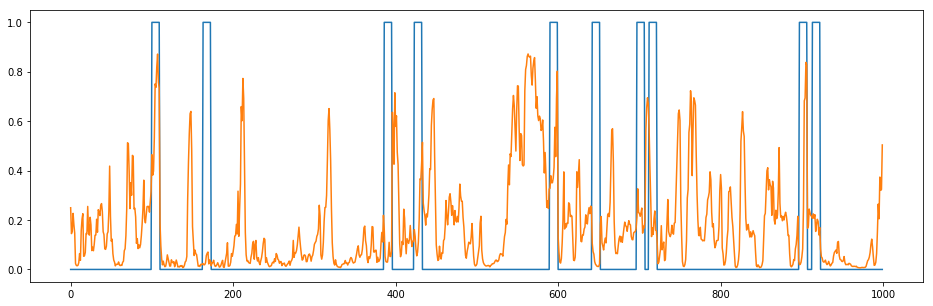

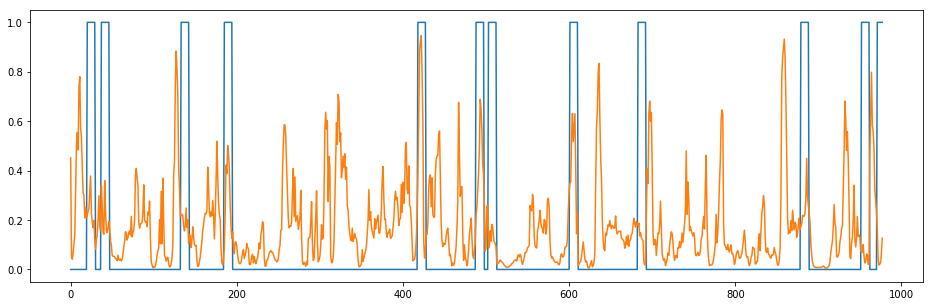

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(0,len(y_pred1[0]),1000):
    plt.figure(figsize=(16,5))
    plt.plot(y[index][i:i+1000])
    plt.plot(y_pred1[0][i:i+1000])

In [8]:
model.evaluate([x_spA[index],x_spB[index],x_img[index],x_target[index]],[y[index],y1[index],y2[index],y3[index]])

6716/6716 [==============================] - 45s 7ms/step


[0.6999780761123484,
 0.08345047334800383,
 0.9372904805145923,
 0.7210375982214113,
 0.3808124920951248,
 0.9827278141751042,
 0.5202501493241547,
 0.48558665941147094,
 0.8371947578477887]